In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz, yaml
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import pickle, glob

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from matplotlib import cm


from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

import csv
from math import *

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')
freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

In [22]:
# Defining what I want to keep the same 

plt.rcParams.update({'font.size': 13})

freqlist=[1000,900,800,700,600,500]

goodfreqlist=[938,900,807,700,630,538]

colors=['b.','g.','y.','c.','r.','m.']

def get_slice_xy(xes,yes,zes,val,ax,tol):
        if ax=='x':
            col = np.where((xes < val+tol) & (xes > val-tol))[0]
        if ax=='y':
            col = np.where((yes < val+tol) & (yes > val-tol))[0]
        return col

In [ ]:
# This notebook aims to investigate the dropped points that Audrey discovered in flights 533,534,535
# A key difference to note between my process and Audrey's is that I use beam slices based on position, 
# Whereas she used slices based on time

In [10]:
# Reading in File for Flight 533
# Plotting inputs pols: 1,3,9,11,15 cpols:8

fly = '533'

pklfile = glob.glob(pckldir+'*'+fly+'*')[0]
print(pklfile)

with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]

for fi in range(0,len(documents["flight_info"]["flights"])):
    if fly == flights[fi]: f = fi
print('FLIGHT: ', documents["flight_info"]["flights"][f])

pol = documents["flight_info"]["pols"][f]

if pol=='N':
    pols = N_pols
    cpols = E_pols
else:
    pols = E_pols
    cpols = N_pols
    
    
print(fly,pol,pols,cpols)

/hirax/GBO_Analysis_Outputs/flight_pickles/FLY533_20210826T182904Z_ver_20230412T211305_concat.pkl
FLIGHT:  533
533 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14]


frequency index:1000
frequency:409.375
input:1


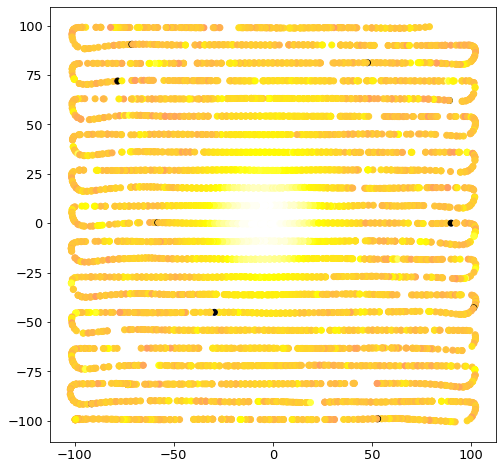

In [20]:
# Flight 533 Input:1 

plt.figure(1,figsize=(8,8))

freq = 1000
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= pols[0]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

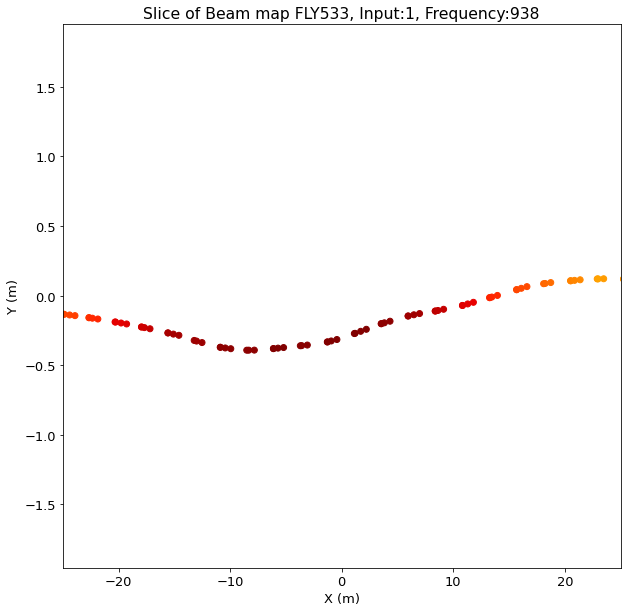

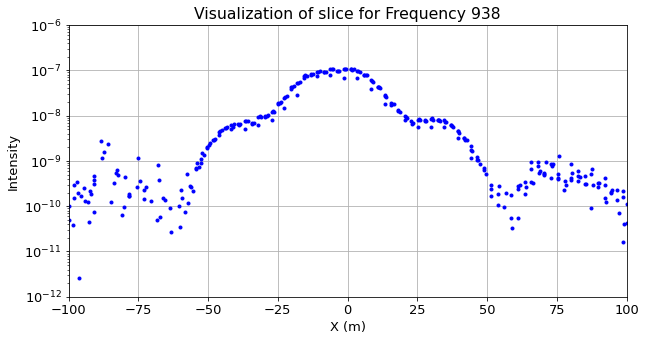

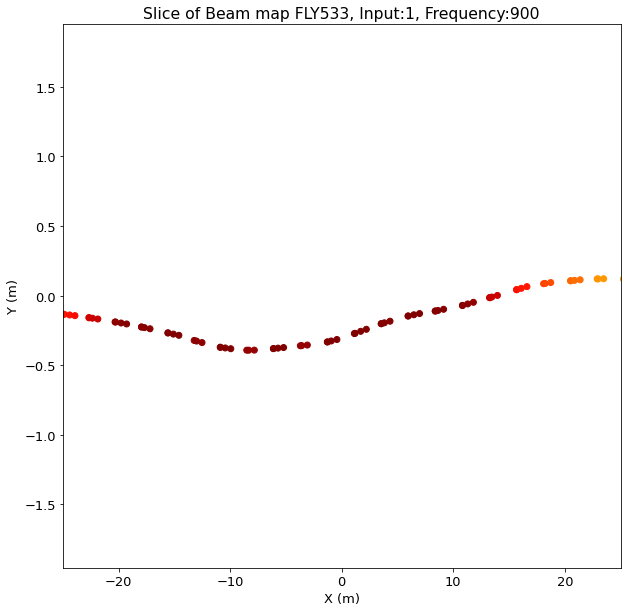

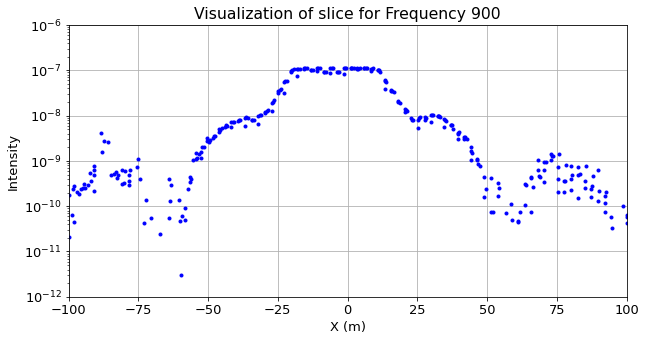

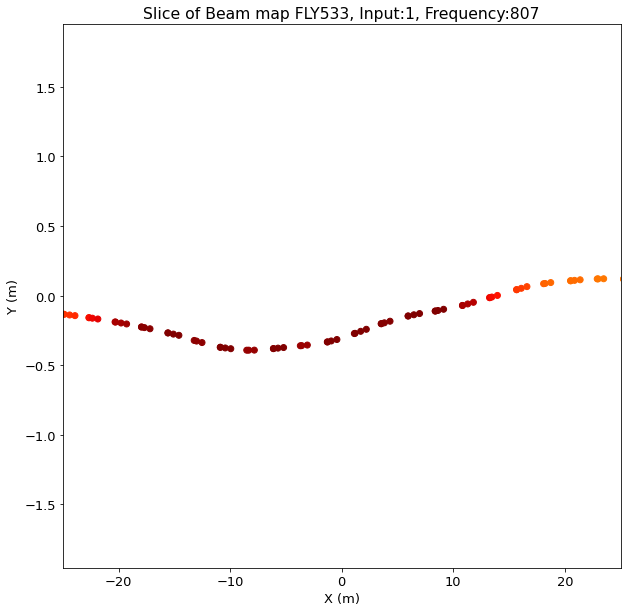

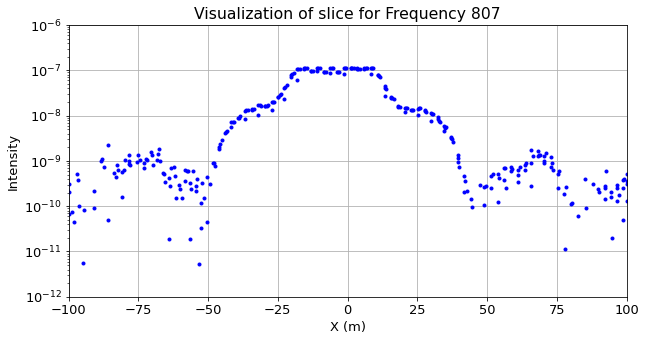

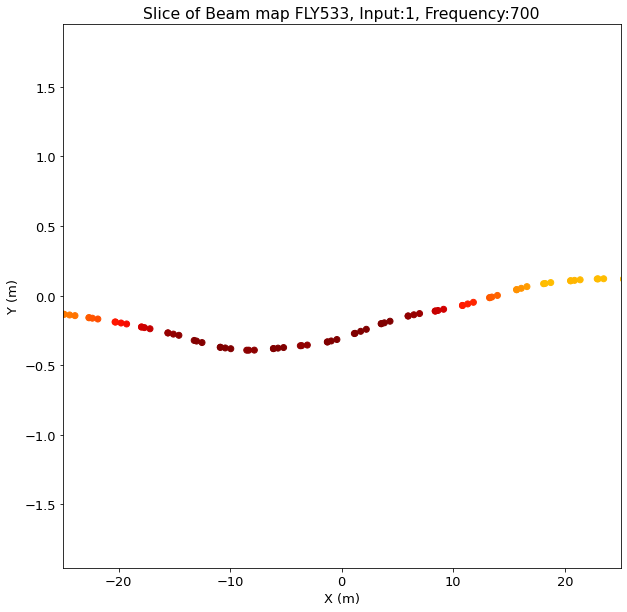

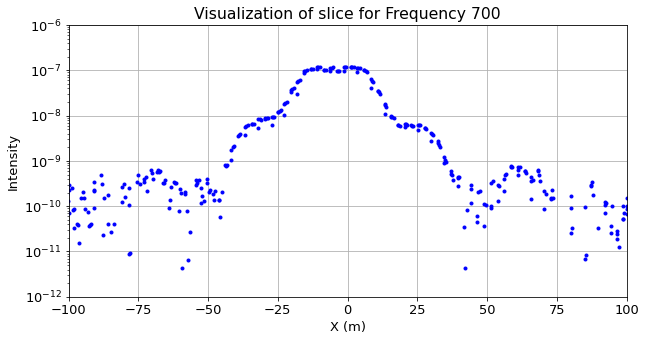

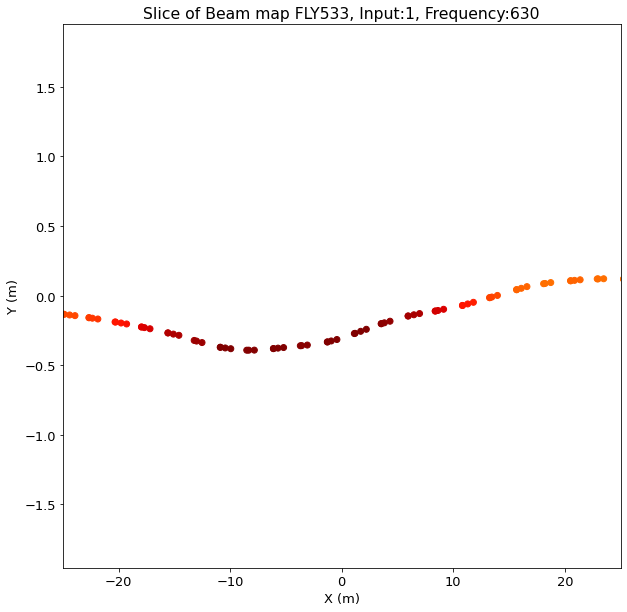

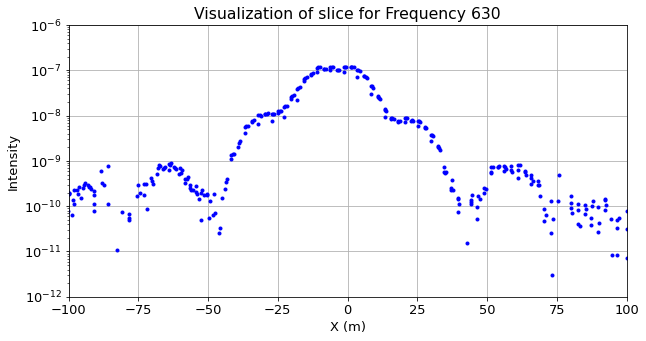

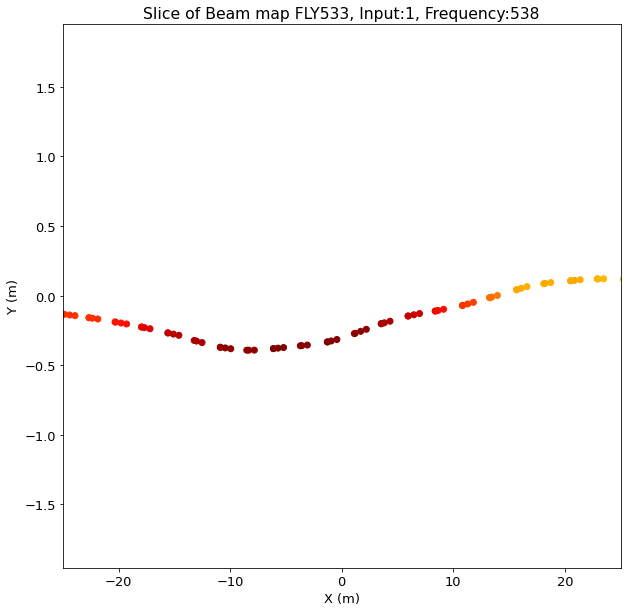

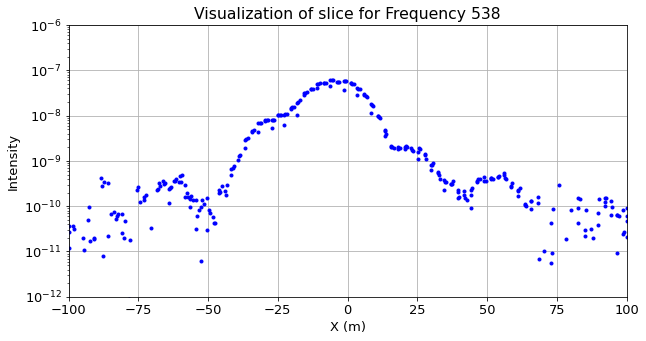

In [19]:
# Flight 533 Input:1

for f in goodfreqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,0,'y',2)


    
    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.xlim(-25,25)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))
    #plt.xlim(5.35,5.48)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(x[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title(f"Visualization of slice for Frequency {f}")
    plt.xlim(-100,100)
    plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

In [ ]:
# We notice there are still some dropped points for each frequency
# We also notice that it looks like these dropped points could be repeated values

1


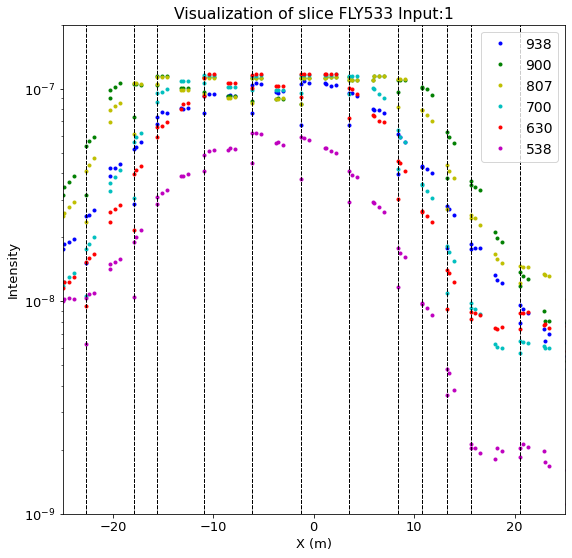

In [25]:
# Zooming in on center of peak and plotting all freqs together 

plt.figure(1,figsize=(9,9))
print(dish)

for f, color in zip(goodfreqlist, colors):

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,0,'y',2)
    
    plt.semilogy(x[pp], z[pp], color,label=str(f))

# Finding where X values have multiple y values 
# These values occur for every frequency so don't have to put this bit in the loop 
    
xmult_y=[]

for x_val in x[pp]:
    if np.count_nonzero(np.isclose(x, x_val, atol=.000001)) > 1:
        xmult_y.append(x_val)

# print(xmult_y)
    
# Creating vertical lines where there are multiple values per x 
    
for p in xmult_y:
    
    plt.axvline(p, color='k', linestyle='--',linewidth=1)


plt.legend(prop={'size': 14},loc='upper right')
plt.xlabel('X (m)')
plt.ylabel('Intensity')
plt.title("Visualization of slice FLY533 Input:" +str(dish))
plt.xlim(-25,25)
plt.ylim(1E-9, 2E-7)
# plt.grid()
plt.show()

frequency index:1000
frequency:409.375
input:3


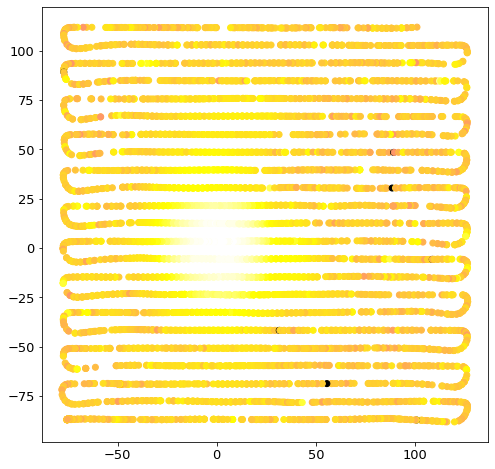

In [26]:
# Flight 533 Input:3

plt.figure(1,figsize=(8,8))

freq = 1000
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= pols[1]
print('input:'+str(dish))
f
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

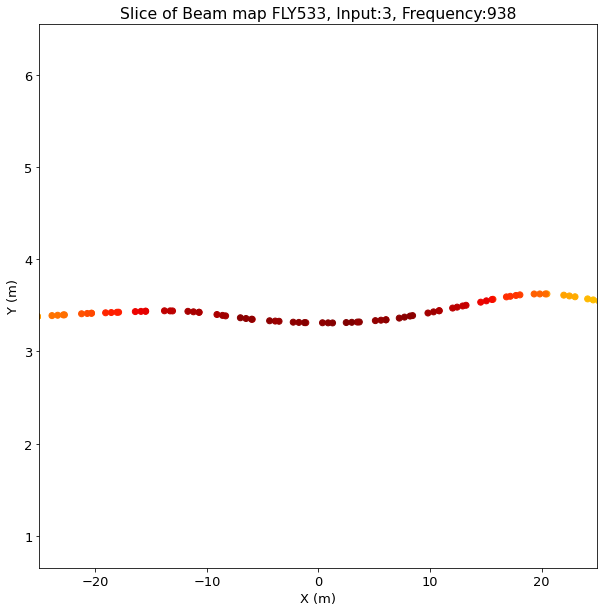

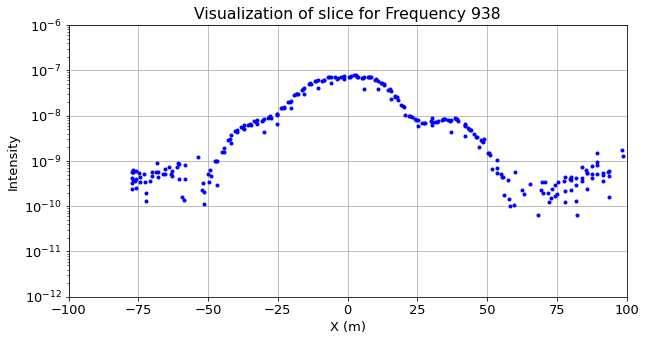

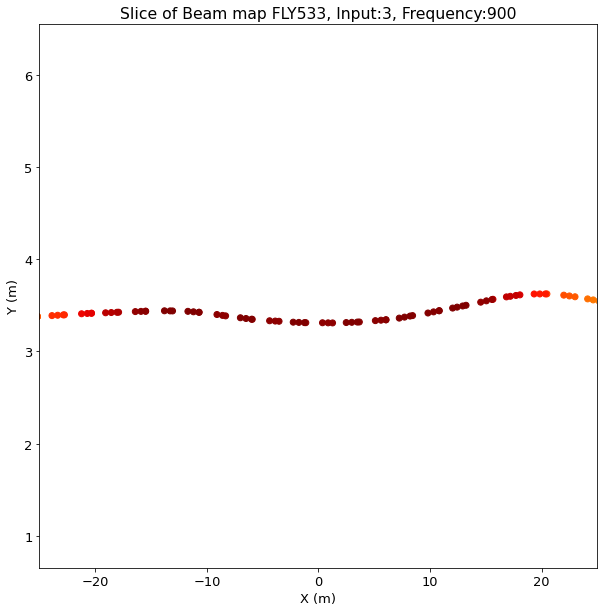

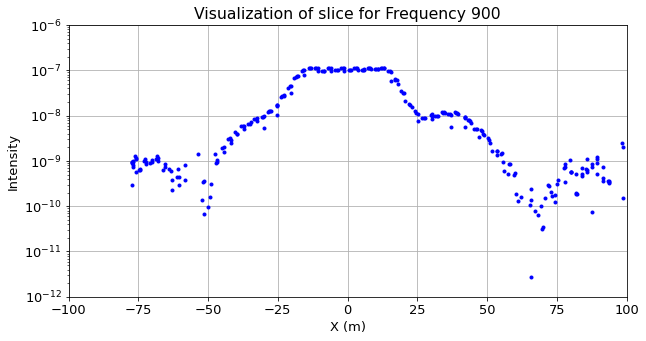

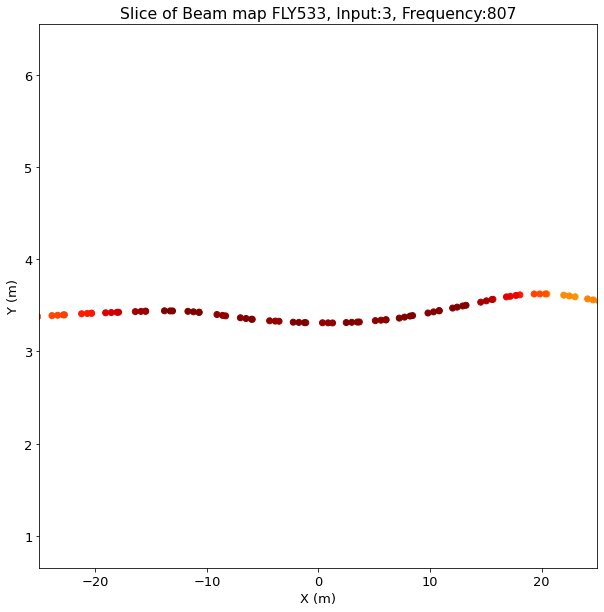

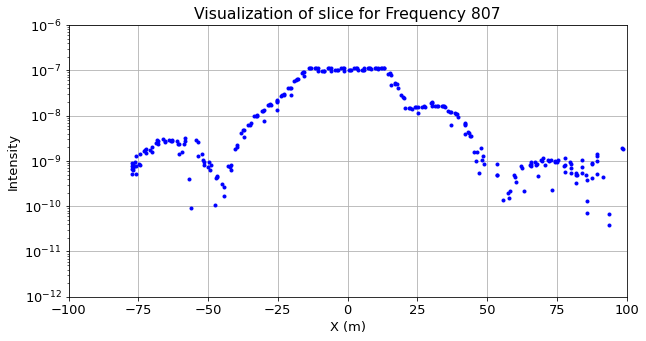

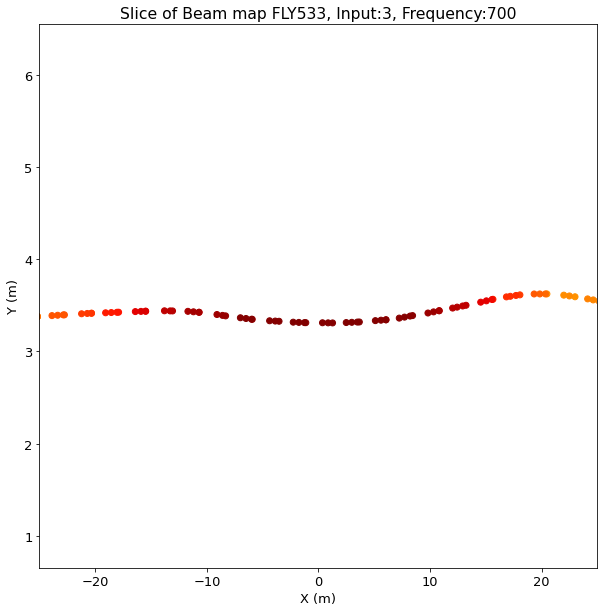

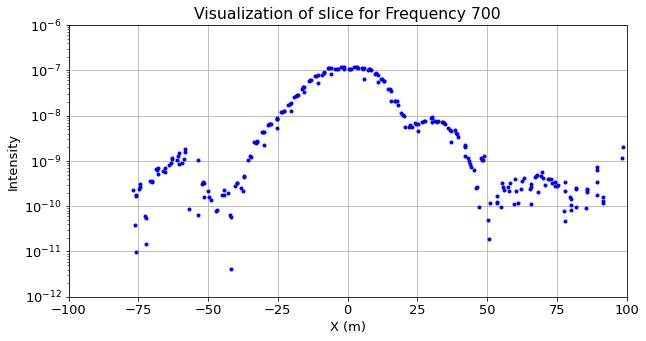

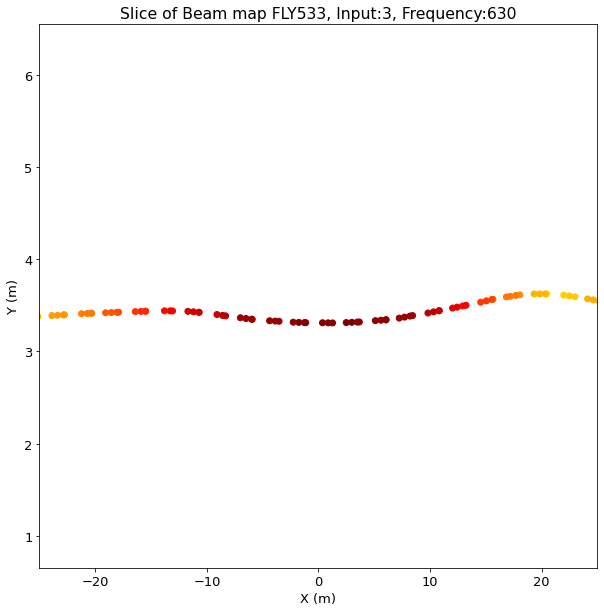

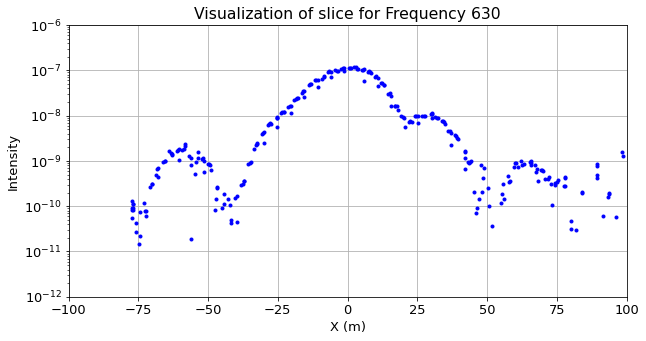

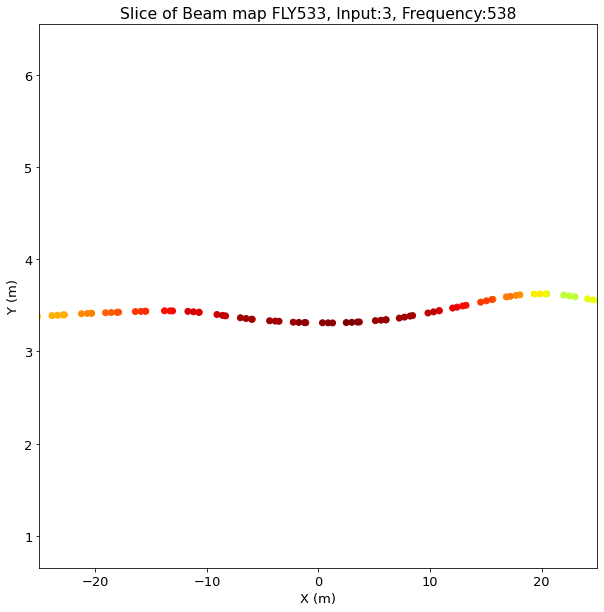

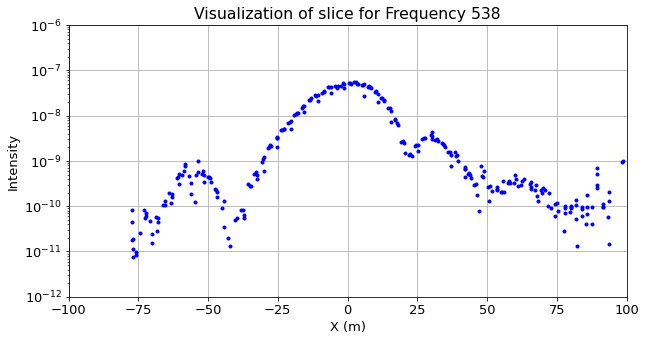

In [27]:
# Flight 533 Input:3

for f in goodfreqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,3.5,'y',3)


    
    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.xlim(-25,25)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(x[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title(f"Visualization of slice for Frequency {f}")
    plt.xlim(-100,100)
    plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

3


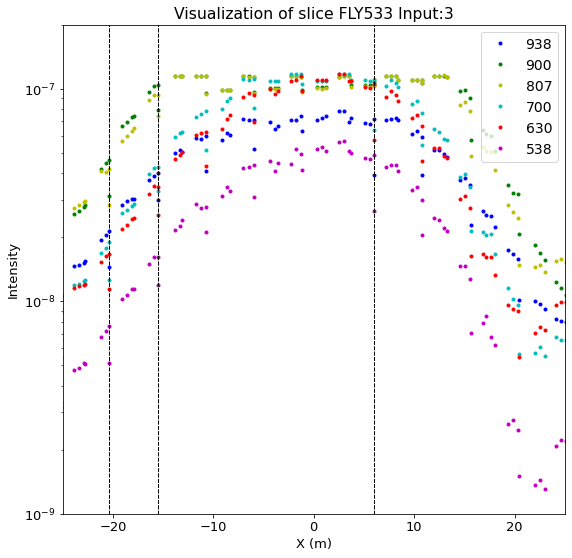

In [28]:
# Zooming in on center of peak and plotting all freqs together 

plt.figure(1,figsize=(9,9))
print(dish)

for f, color in zip(goodfreqlist, colors):

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,3.5,'y',3)
    
    plt.semilogy(x[pp], z[pp], color,label=str(f))

# Finding where X values have multiple y values 
# These values occur for every frequency so don't have to put this bit in the loop 
    
xmult_y=[]

for x_val in x[pp]:
    if np.count_nonzero(np.isclose(x, x_val, atol=.000001)) > 1:
        xmult_y.append(x_val)

# print(xmult_y)
    
# Creating vertical lines where there are multiple values per x 
    
for p in xmult_y:
    
    plt.axvline(p, color='k', linestyle='--',linewidth=1)


plt.legend(prop={'size': 14},loc='upper right')
plt.xlabel('X (m)')
plt.ylabel('Intensity')
plt.title("Visualization of slice FLY533 Input:" +str(dish))
plt.xlim(-25,25)
plt.ylim(1E-9, 2E-7)
# plt.grid()
plt.show()

frequency index:938
frequency:433.59375
input:9


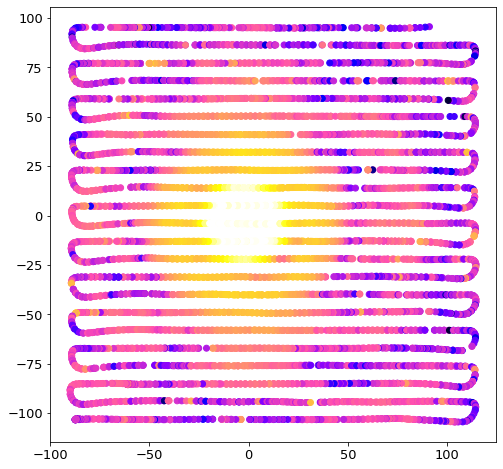

In [32]:
# Flight 533 Input:9

plt.figure(1,figsize=(8,8))
 
freq = 938
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= pols[2]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

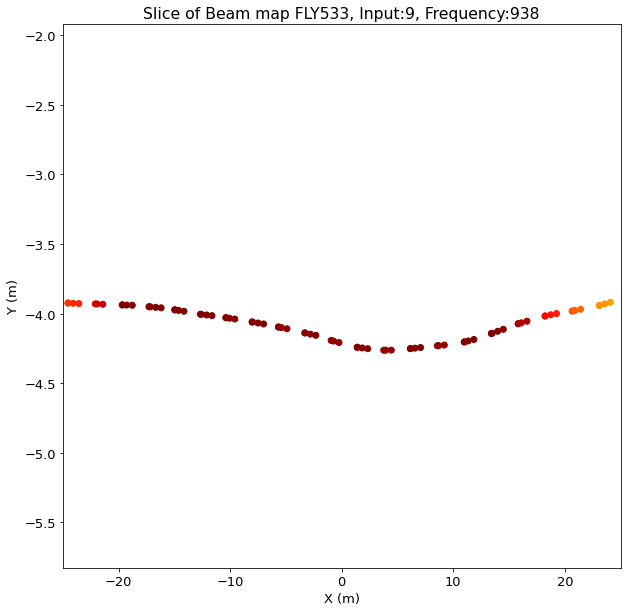

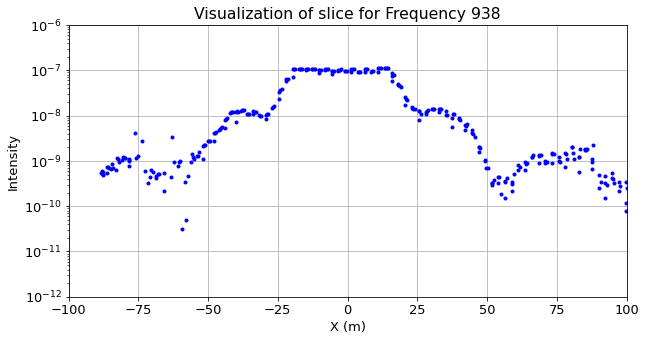

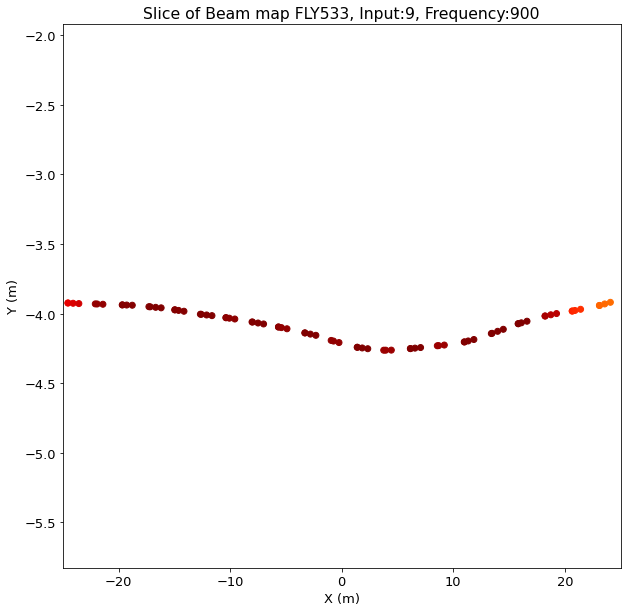

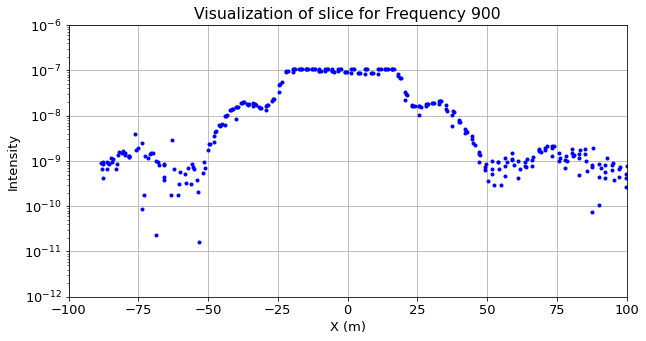

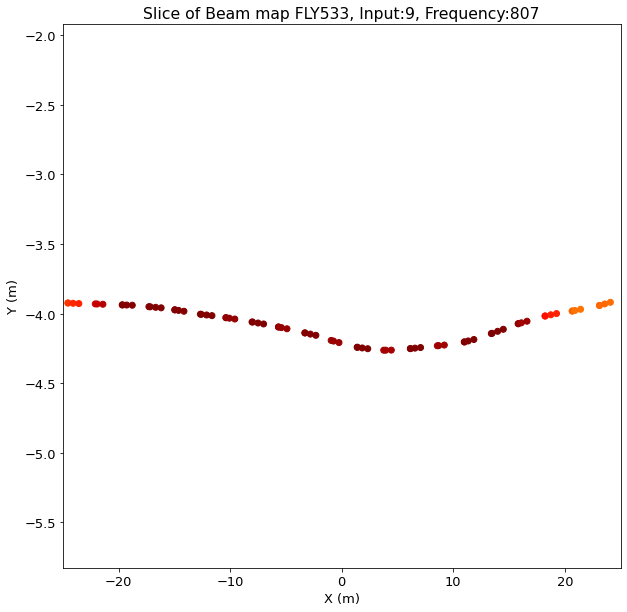

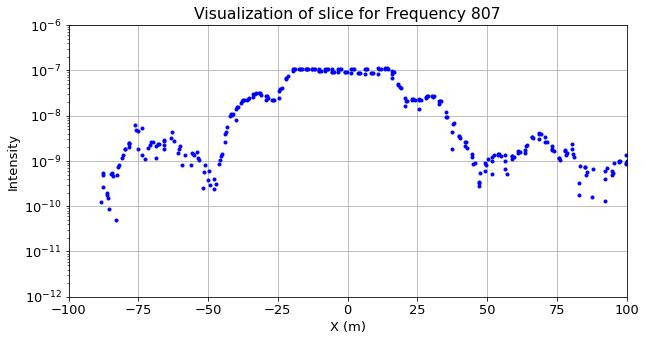

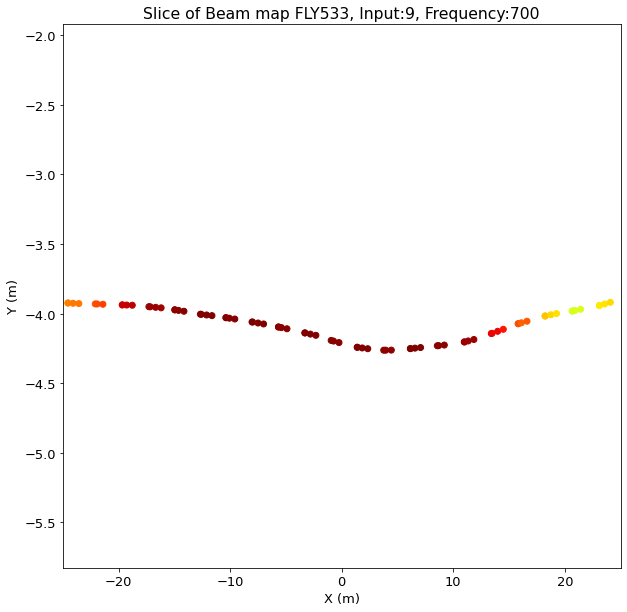

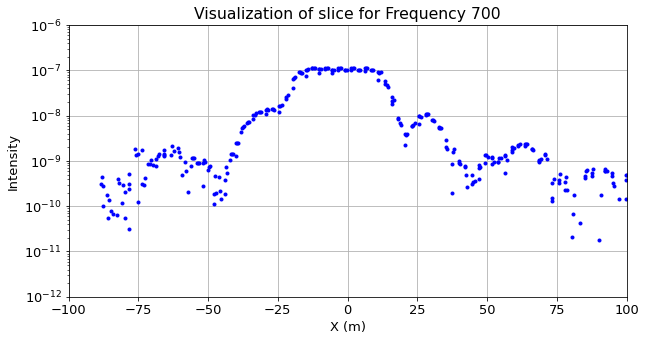

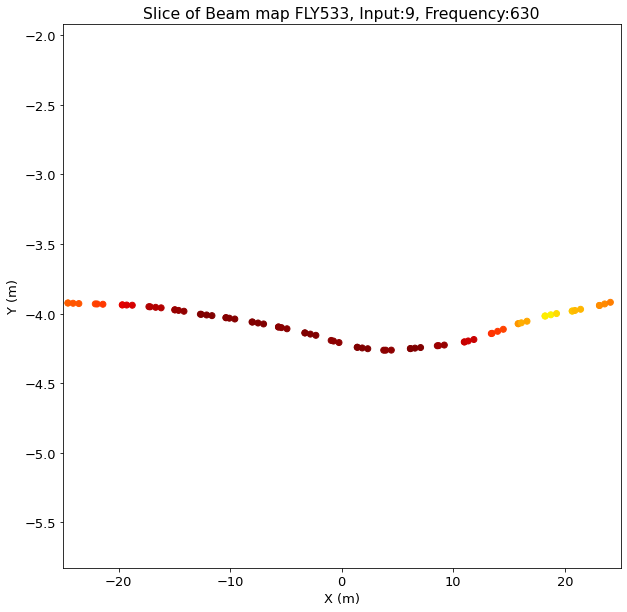

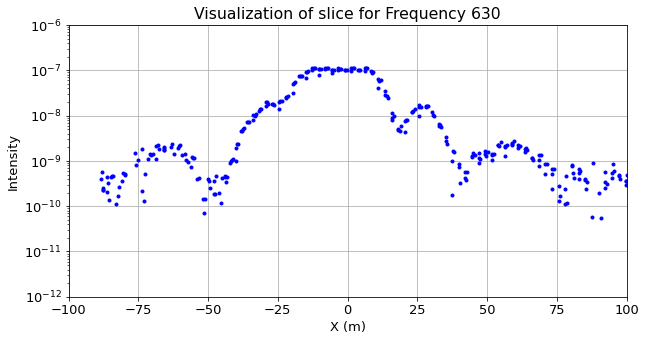

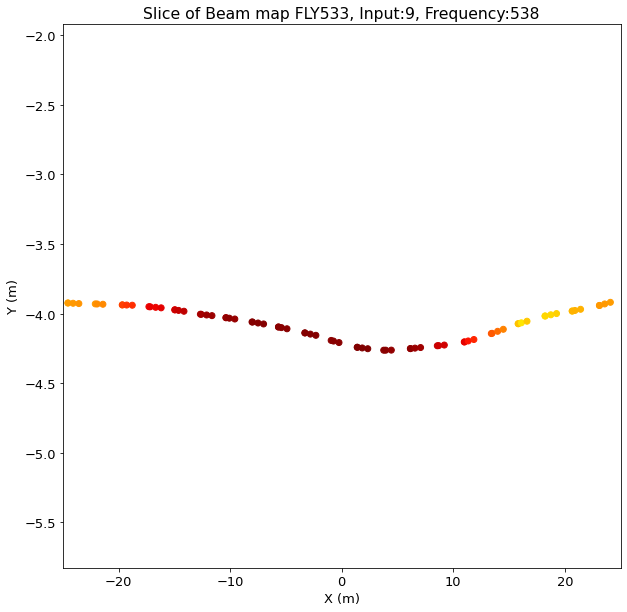

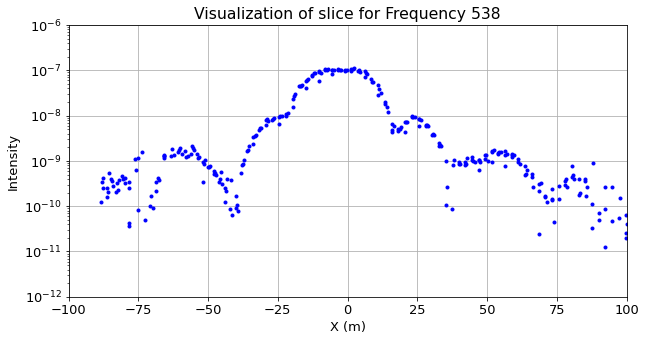

In [31]:
# Flight 533 Input:9

for f in goodfreqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,-4,'y',2)


    
    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.xlim(-25,25)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(x[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title(f"Visualization of slice for Frequency {f}")
    plt.xlim(-100,100)
    plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

9


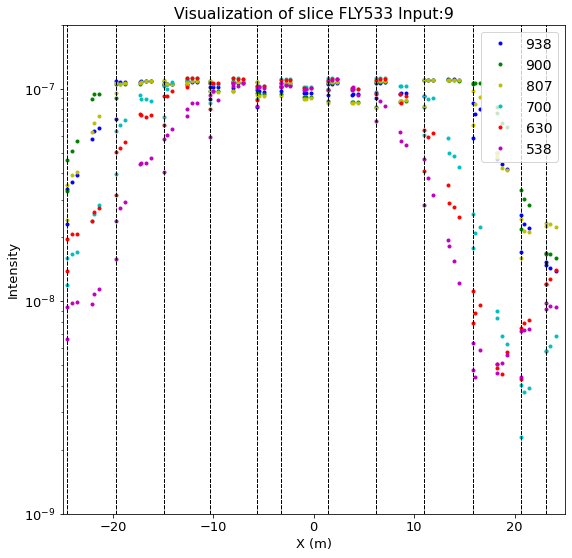

In [33]:
# Zooming in on center of peak and plotting all freqs together 

plt.figure(1,figsize=(9,9))
print(dish)

for f, color in zip(goodfreqlist, colors):

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,-4,'y',2)
    
    plt.semilogy(x[pp], z[pp], color,label=str(f))

# Finding where X values have multiple y values 
# These values occur for every frequency so don't have to put this bit in the loop 
    
xmult_y=[]

for x_val in x[pp]:
    if np.count_nonzero(np.isclose(x, x_val, atol=.000001)) > 1:
        xmult_y.append(x_val)

# print(xmult_y)
    
# Creating vertical lines where there are multiple values per x 
    
for p in xmult_y:
    
    plt.axvline(p, color='k', linestyle='--',linewidth=1)


plt.legend(prop={'size': 14},loc='upper right')
plt.xlabel('X (m)')
plt.ylabel('Intensity')
plt.title("Visualization of slice FLY533 Input:" +str(dish))
plt.xlim(-25,25)
plt.ylim(1E-9, 2E-7)
# plt.grid()
plt.show()

### 

frequency index:938
frequency:433.59375
input:11


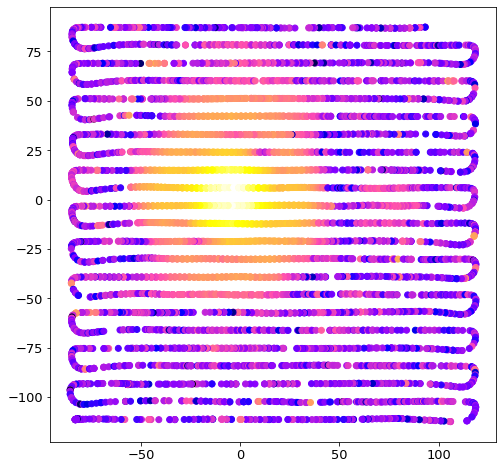

In [35]:
# Flight 533 Input:11 

plt.figure(1,figsize=(8,8))
 
freq = 938
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= pols[3]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

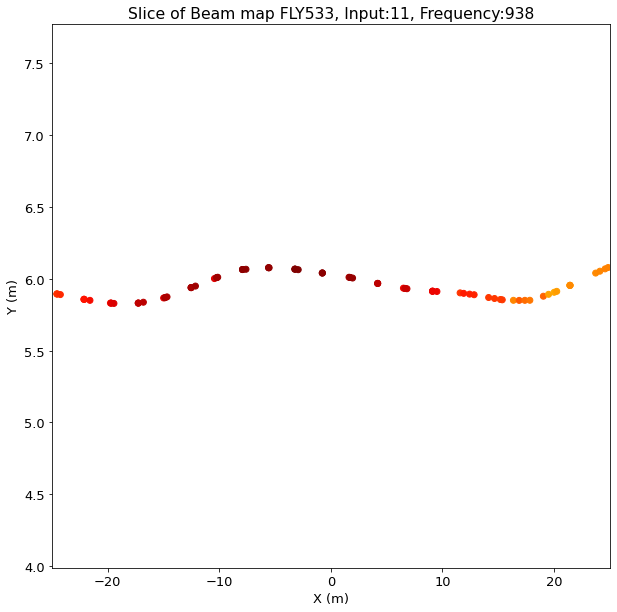

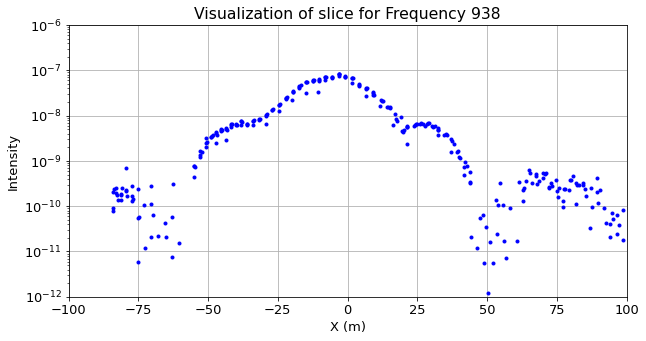

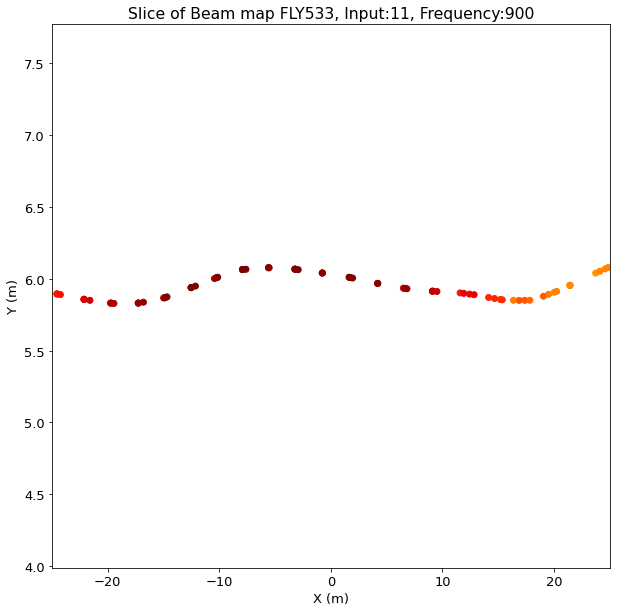

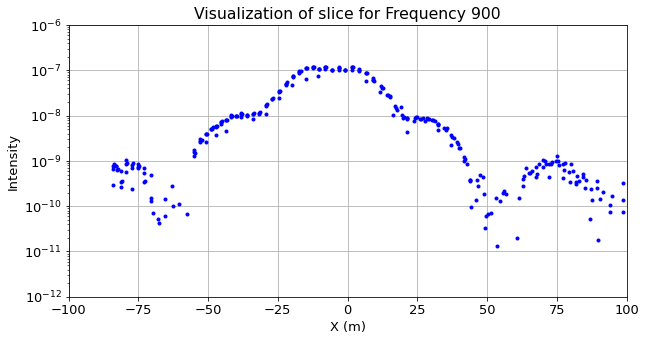

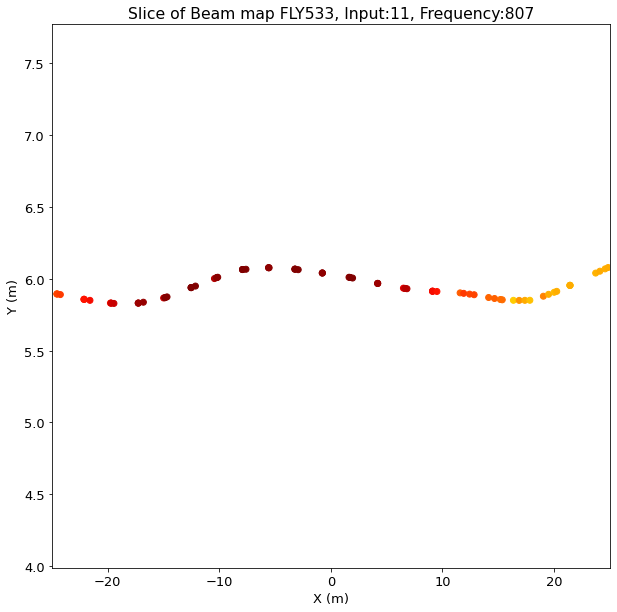

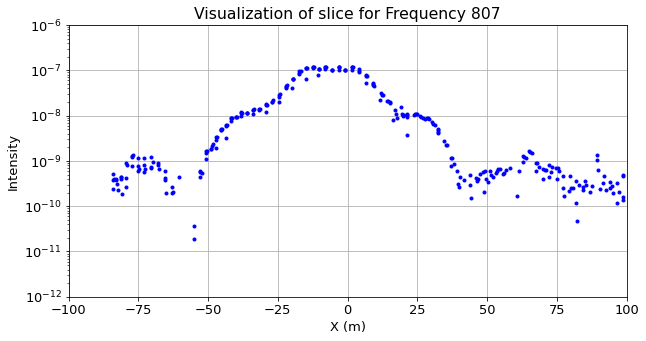

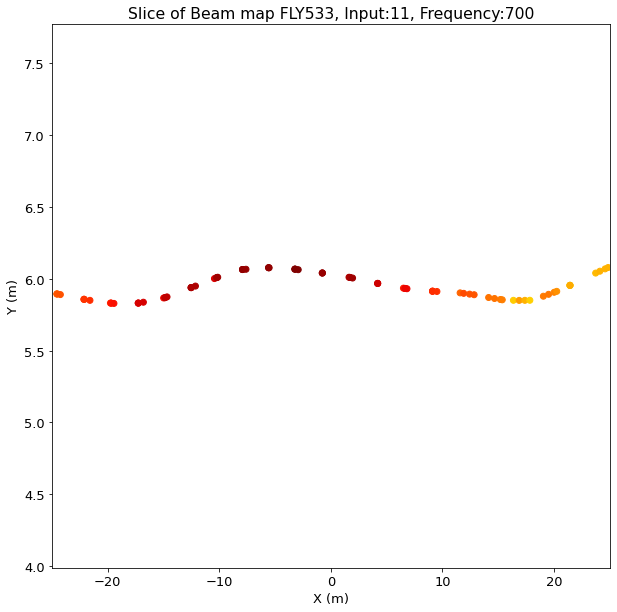

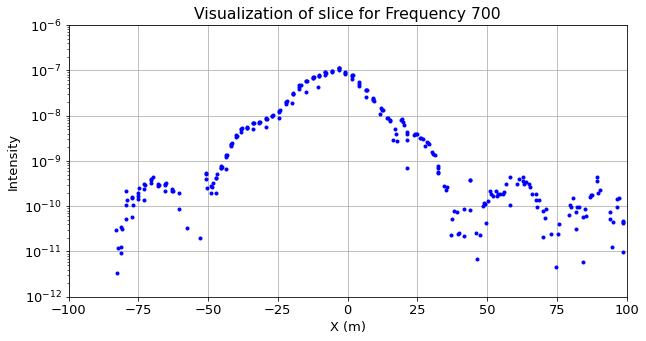

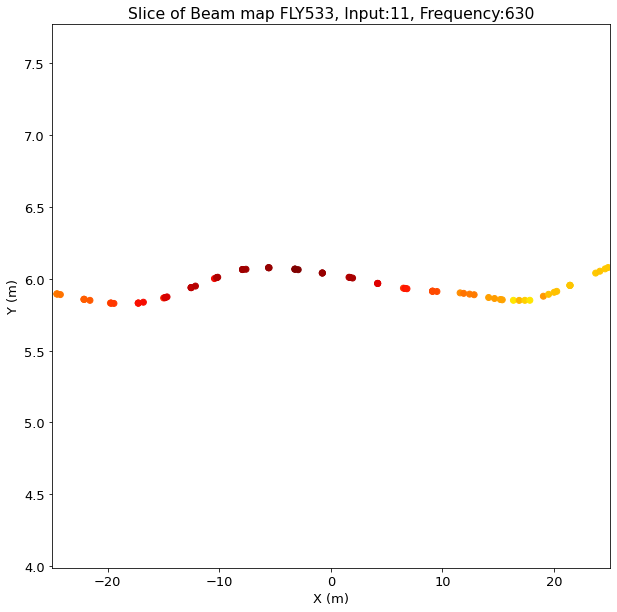

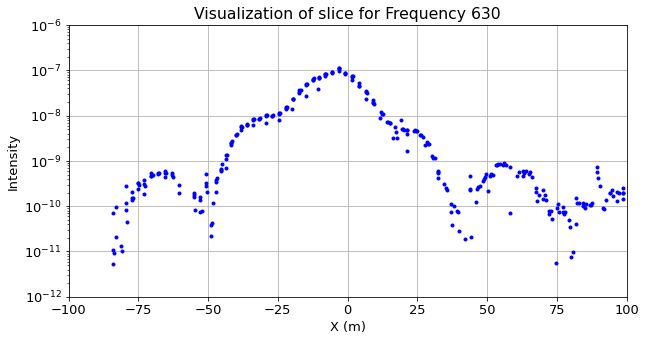

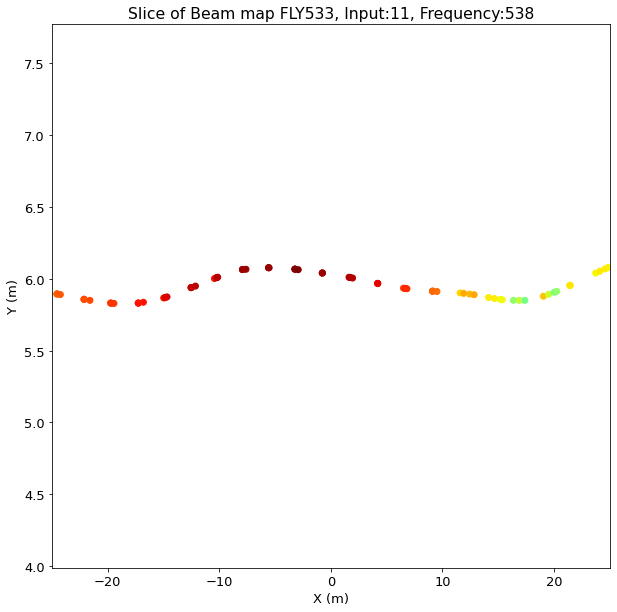

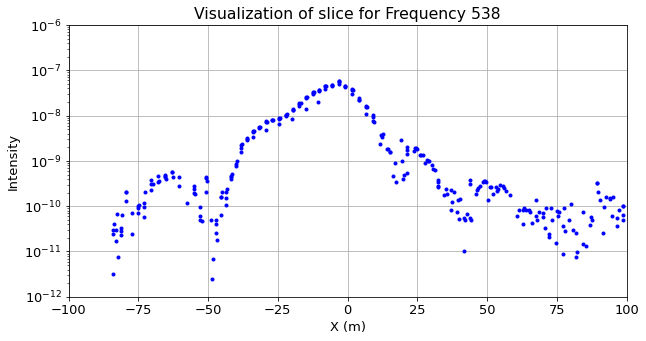

In [36]:
# Flight 533 Input:9

for f in goodfreqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,6,'y',2)


    
    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.xlim(-25,25)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(x[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title(f"Visualization of slice for Frequency {f}")
    plt.xlim(-100,100)
    plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

11


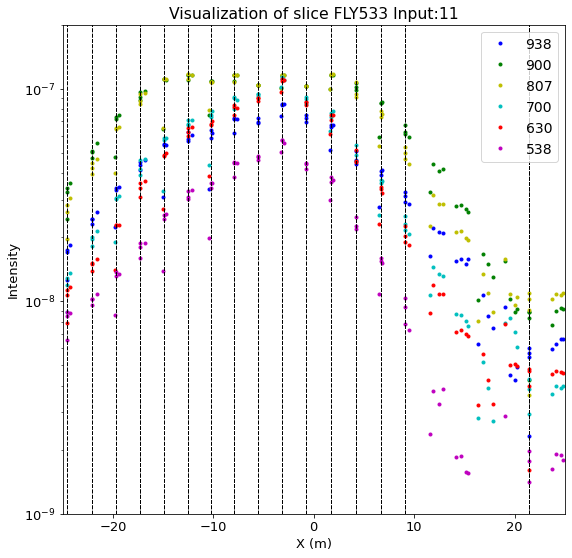

In [38]:
# Zooming in on center of peak and plotting all freqs together 

plt.figure(1,figsize=(9,9))
print(dish)

for f, color in zip(goodfreqlist, colors):

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,6,'y',2)
    
    plt.semilogy(x[pp], z[pp], color,label=str(f))

# Finding where X values have multiple y values 
# These values occur for every frequency so don't have to put this bit in the loop 
    
xmult_y=[]

for x_val in x[pp]:
    if np.count_nonzero(np.isclose(x, x_val, atol=.000001)) > 1:
        xmult_y.append(x_val)

# print(xmult_y)
    
# Creating vertical lines where there are multiple values per x 
    
for p in xmult_y:
    
    plt.axvline(p, color='k', linestyle='--',linewidth=1)


plt.legend(prop={'size': 14},loc='upper right')
plt.xlabel('X (m)')
plt.ylabel('Intensity')
plt.title("Visualization of slice FLY533 Input:" +str(dish))
plt.xlim(-25,25)
plt.ylim(1E-9, 2E-7)
# plt.grid()
plt.show()

frequency index:938
frequency:433.59375
input:15


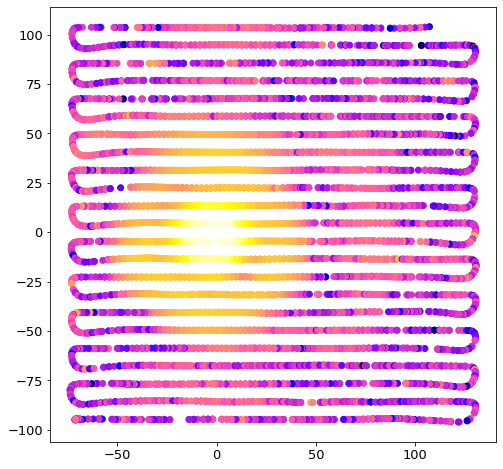

In [40]:
# Flight 533 Input:15 

plt.figure(1,figsize=(8,8))
 
freq = 938
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= pols[4]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

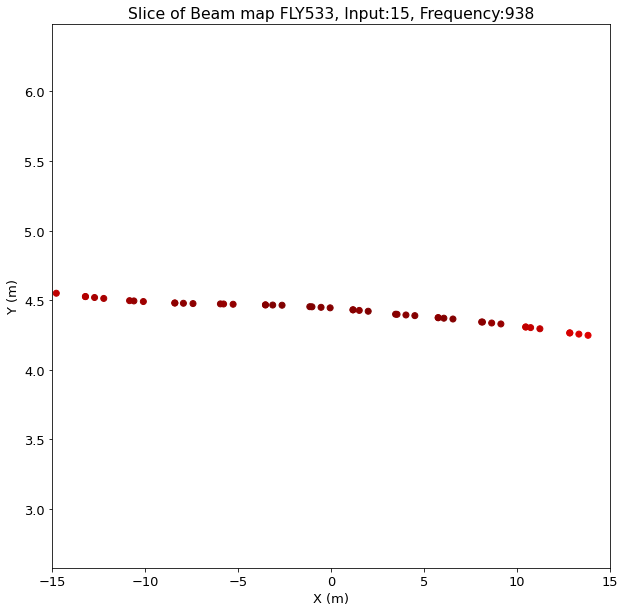

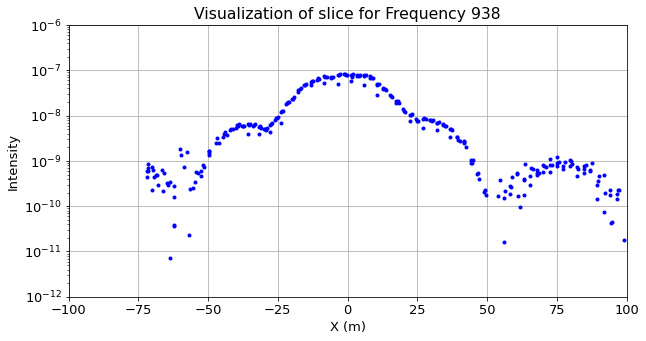

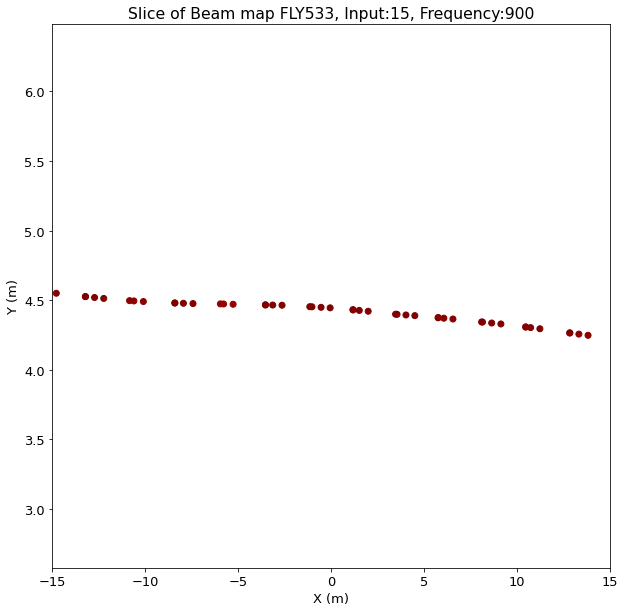

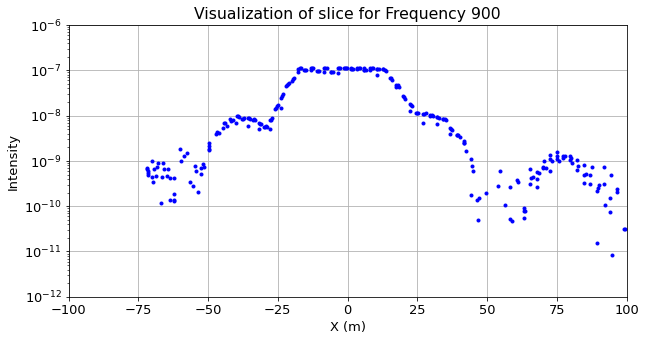

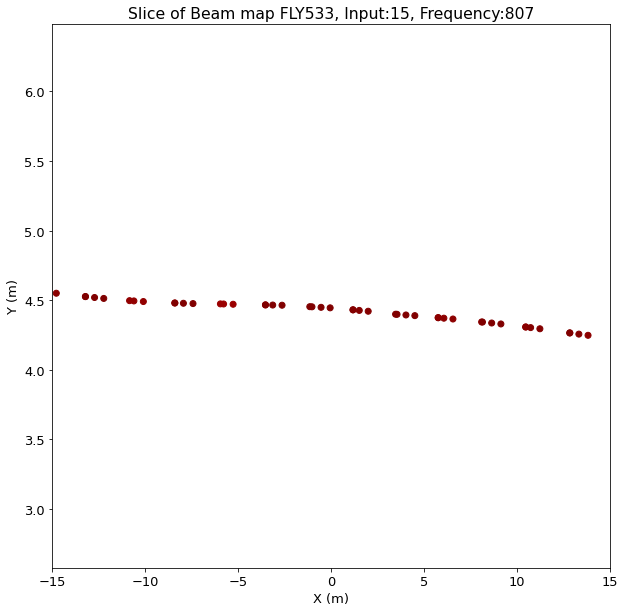

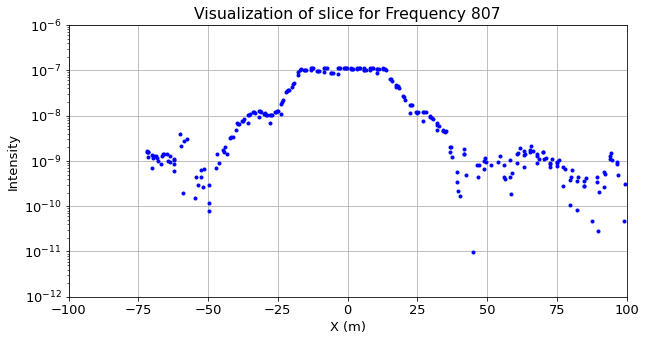

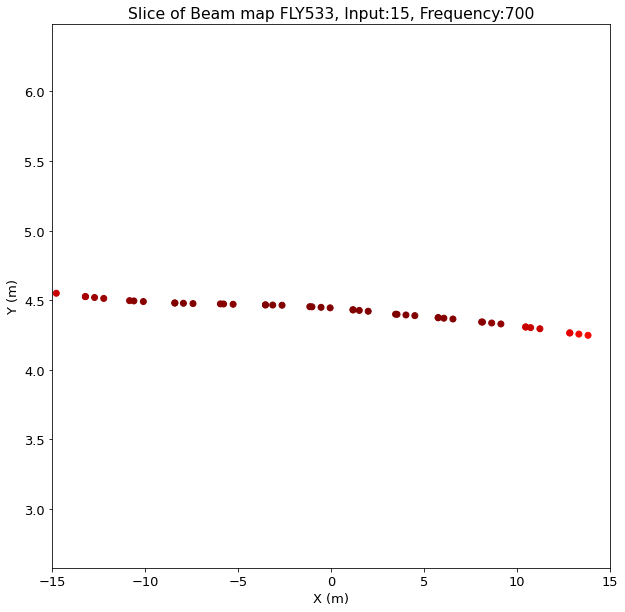

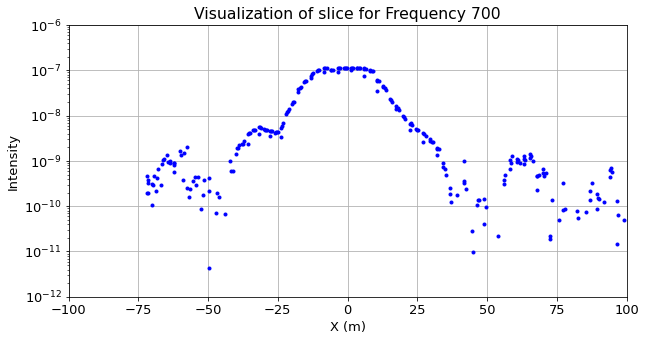

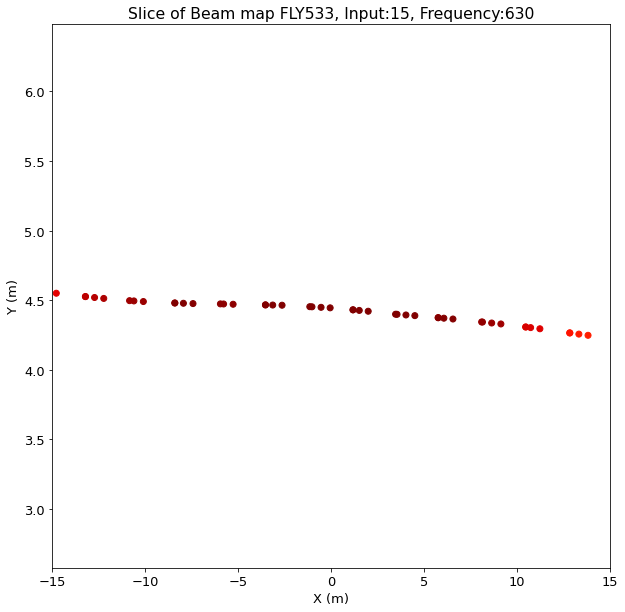

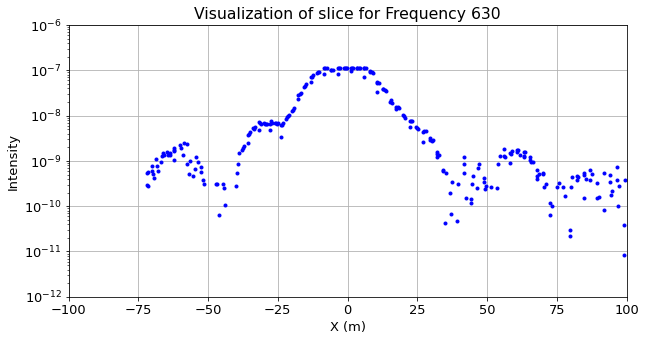

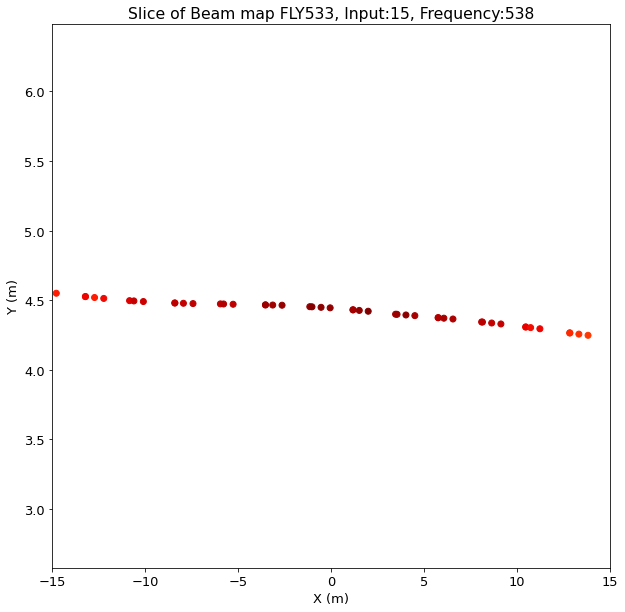

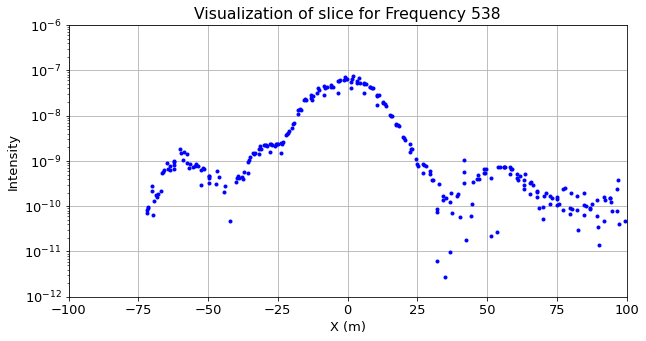

In [41]:
for f in goodfreqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,4.5,'y',2)

    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.xlim(-15,15)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))
    #plt.xlim(5.35,5.48)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(x[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title(f"Visualization of slice for Frequency {f}")
    plt.xlim(-100,100)
    plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

15
120


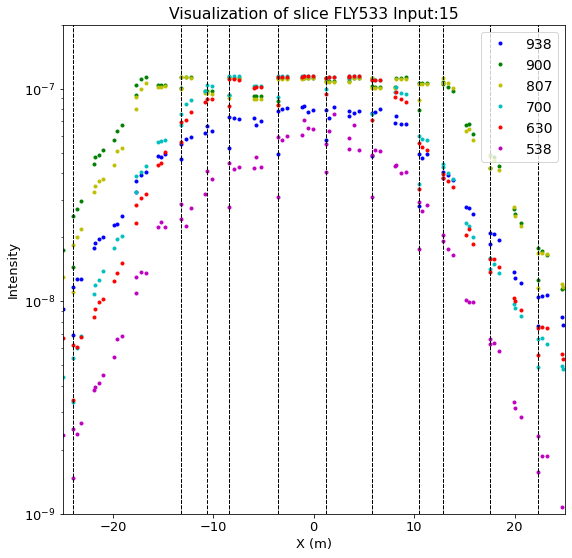

In [44]:
plt.figure(1,figsize=(9,9))
print(dish)


for f, color in zip(goodfreqlist, colors):

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,4.5,'y',2)
    
    plt.semilogy(x[pp], z[pp], color,label=str(f))

# Finding where X values have multiple y values
# These values occur for every frequency so don't have to put this bit in the loop 
    
xmult_y=[]

for x_val in x[pp]:
    if np.count_nonzero(np.isclose(x, x_val, atol=.000001)) > 1:
        xmult_y.append(x_val)

# print(xmult_y)
    
# Creating vertical lines where there are multiple values per x 
    
for p in xmult_y:
    
    plt.axvline(p, color='k', linestyle='--',linewidth=1)


plt.legend(prop={'size': 14},loc='upper right')
plt.xlabel('X (m)')
plt.ylabel('Intensity')
plt.title("Visualization of slice FLY533 Input:" +str(dish))
plt.xlim(-25,25)
plt.ylim(1E-9, 2E-7)
# plt.grid()
plt.show()

frequency index:938
frequency:433.59375
input:8


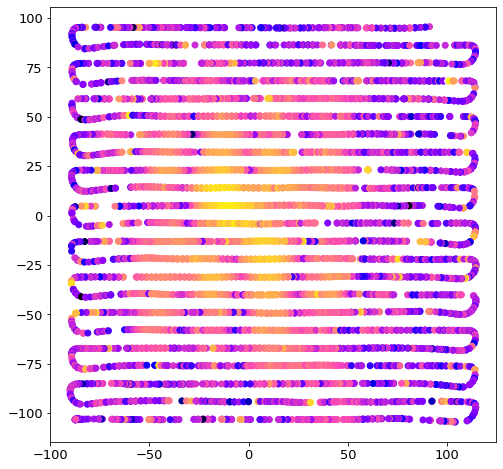

In [46]:
# Flight 533 Input:8
# This is a crosspol input for this flight 

plt.figure(1,figsize=(8,8))

freq = 938
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= cpols[2]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

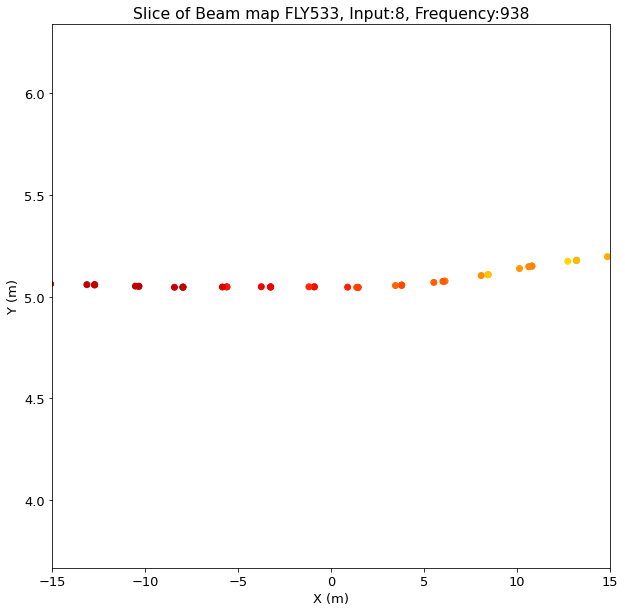

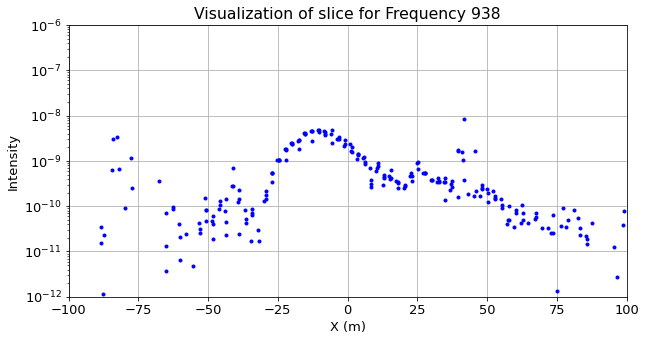

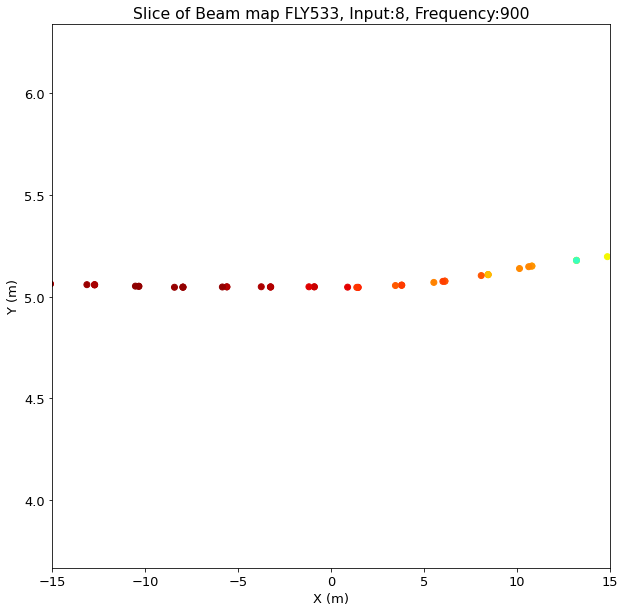

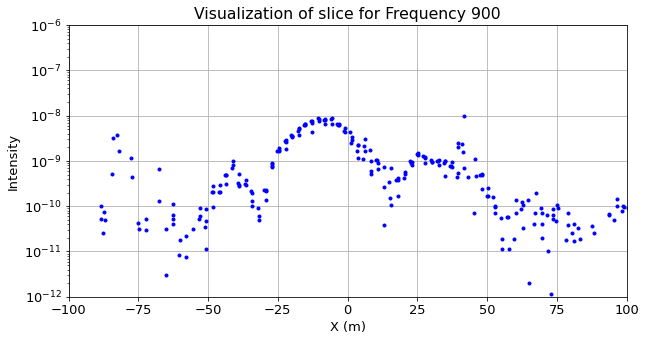

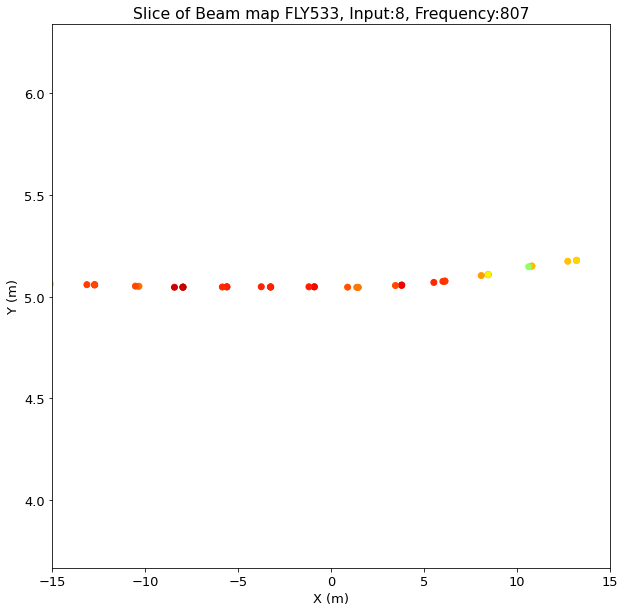

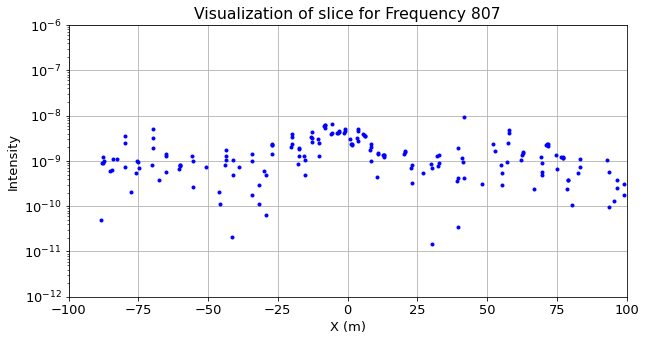

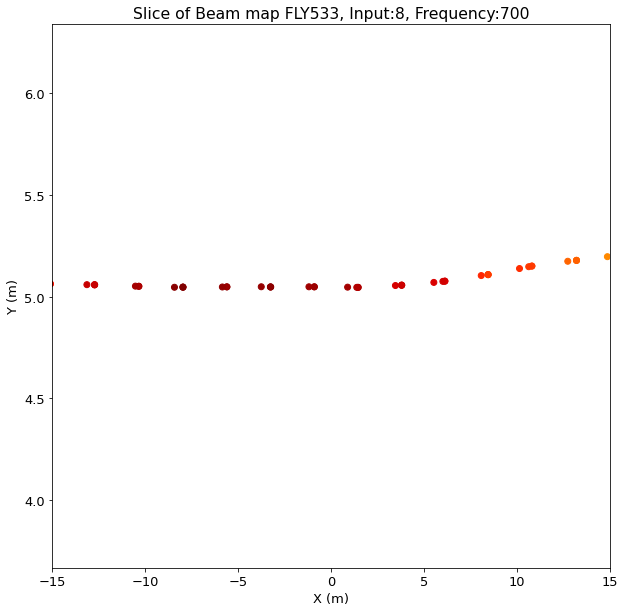

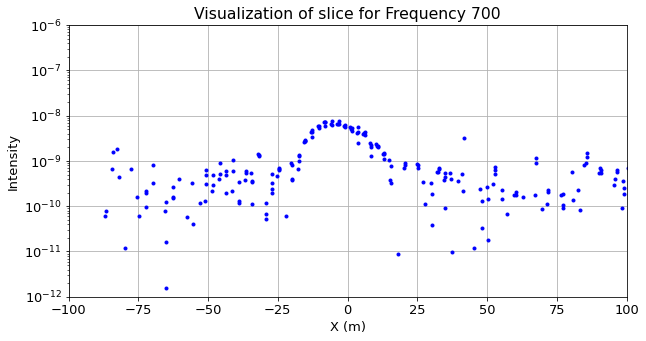

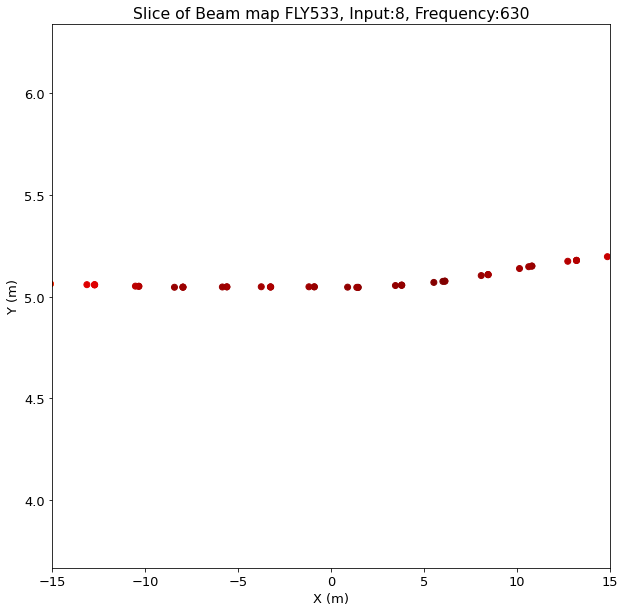

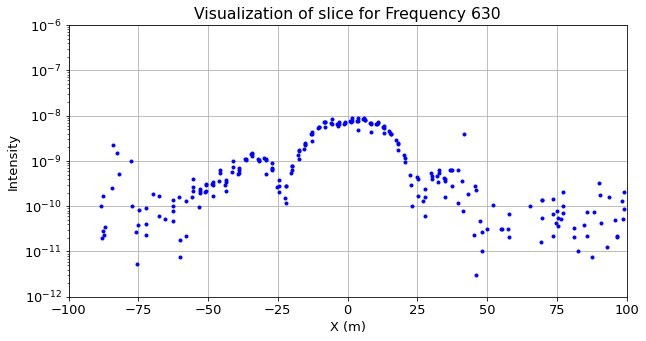

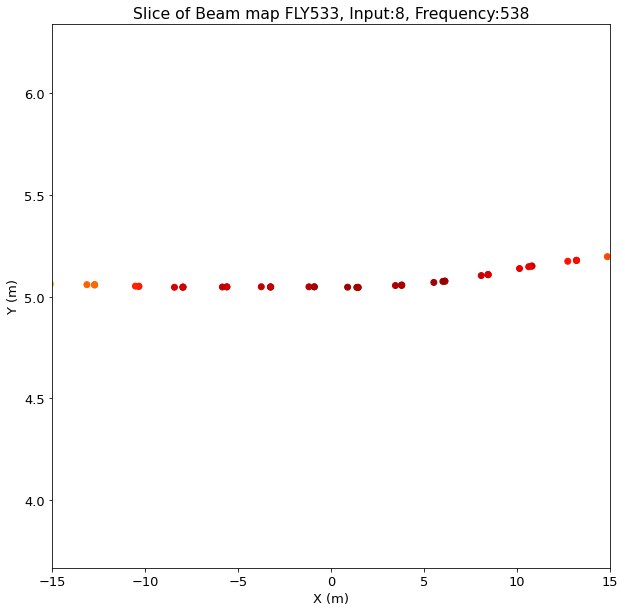

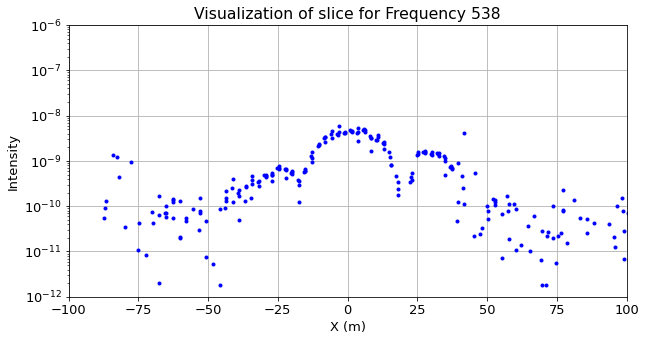

In [47]:
for f in goodfreqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,5,'y',2)

    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.xlim(-15,15)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))
    #plt.xlim(5.35,5.48)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(x[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title(f"Visualization of slice for Frequency {f}")
    plt.xlim(-100,100)
    plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

8


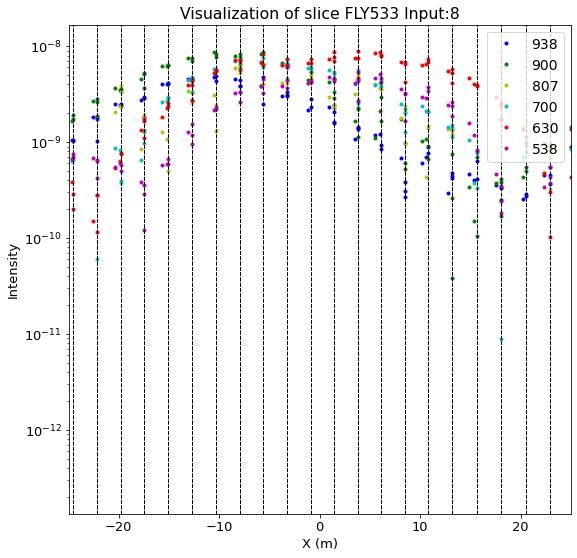

In [50]:
plt.figure(1,figsize=(9,9))
print(dish)


for f, color in zip(goodfreqlist, colors):

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,5,'y',2)
    
    plt.semilogy(x[pp], z[pp], color,label=str(f))

# Finding where X values have multiple y values
# These values occur for every frequency so don't have to put this bit in the loop 
    
xmult_y=[]

for x_val in x[pp]:
    if np.count_nonzero(np.isclose(x, x_val, atol=.000001)) > 1:
        xmult_y.append(x_val)

# print(xmult_y)
    
# Creating vertical lines where there are multiple values per x 
    
for p in xmult_y:
    
    plt.axvline(p, color='k', linestyle='--',linewidth=1)


plt.legend(prop={'size': 14},loc='upper right')
plt.xlabel('X (m)')
plt.ylabel('Intensity')
plt.title("Visualization of slice FLY533 Input:" +str(dish))
plt.xlim(-25,25)
# plt.ylim(1E-9, 2E-7)
# plt.grid()
plt.show()

In [51]:
# Reading in File for Flight 534
# This flight was only for inputs 0-7 which limits the valid inputs that can be plot
# Matching inputs from Audrey's slides I'll graph pols:0,2 and cpols:3

fly = '534'

pklfile = glob.glob(pckldir+'*'+fly+'*')[0]
print(pklfile)

with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]

for fi in range(0,len(documents["flight_info"]["flights"])):
    if fly == flights[fi]: f = fi
print('FLIGHT: ', documents["flight_info"]["flights"][f])

pol = documents["flight_info"]["pols"][f]

if pol=='N':
    pols = N_pols
    cpols = E_pols
else:
    pols = E_pols
    cpols = N_pols
    
    
print(fly,pol,pols,cpols)

/hirax/GBO_Analysis_Outputs/flight_pickles/FLY534_20210826T185621Z_ver_20230412T212230_concat.pkl
FLIGHT:  534
534 E [0, 2, 8, 10, 14] [1, 3, 9, 11, 15]


frequency index:938
frequency:433.59375
input:0


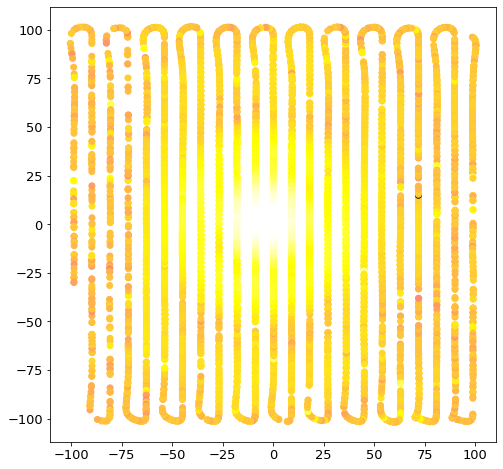

In [56]:
# Flight 534 Input:0

plt.figure(1,figsize=(8,8))

freq = 938
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= pols[0]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

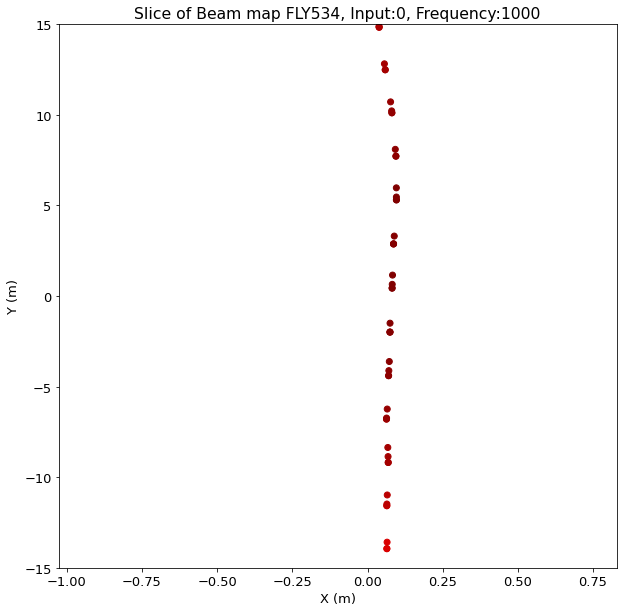

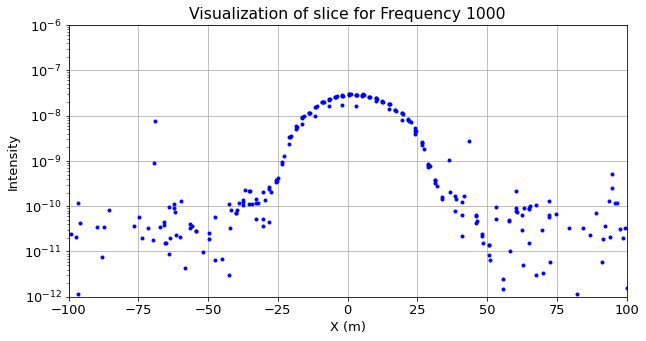

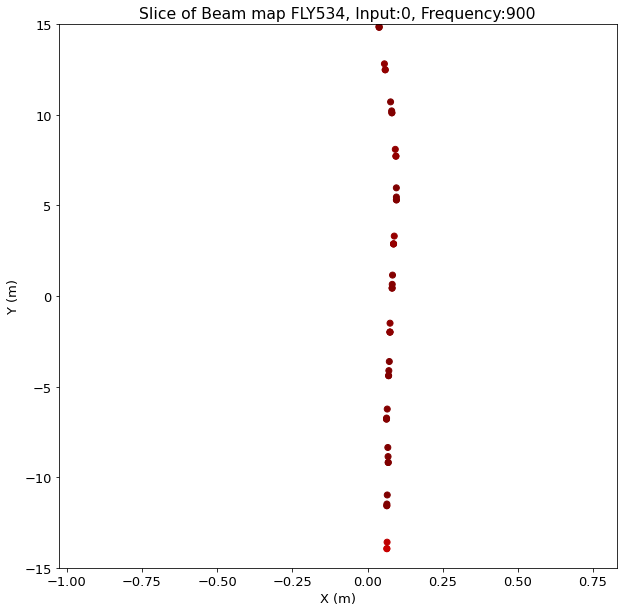

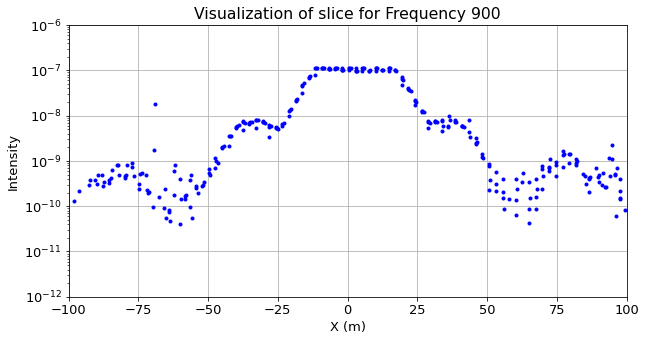

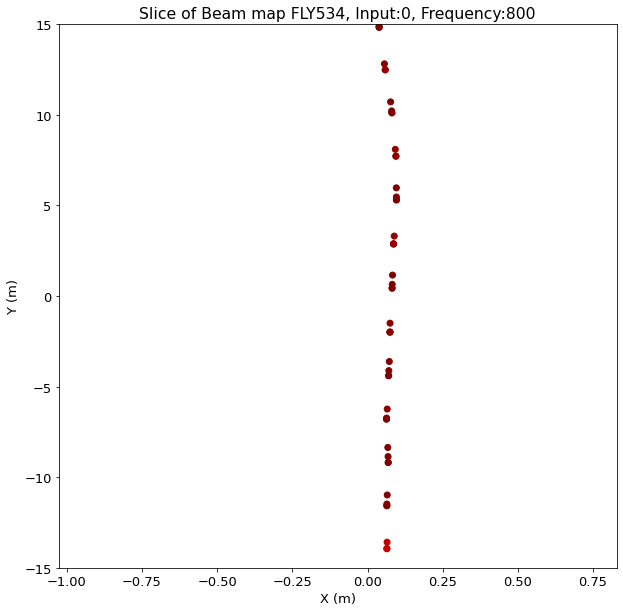

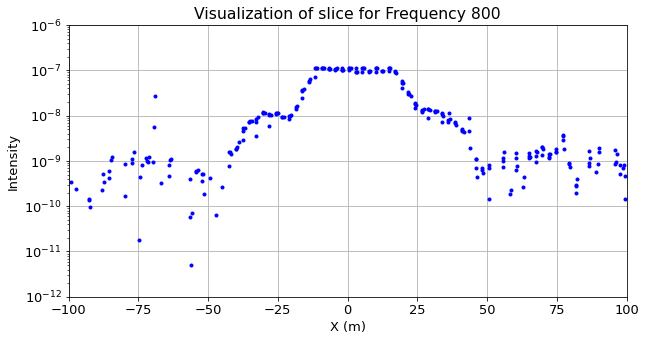

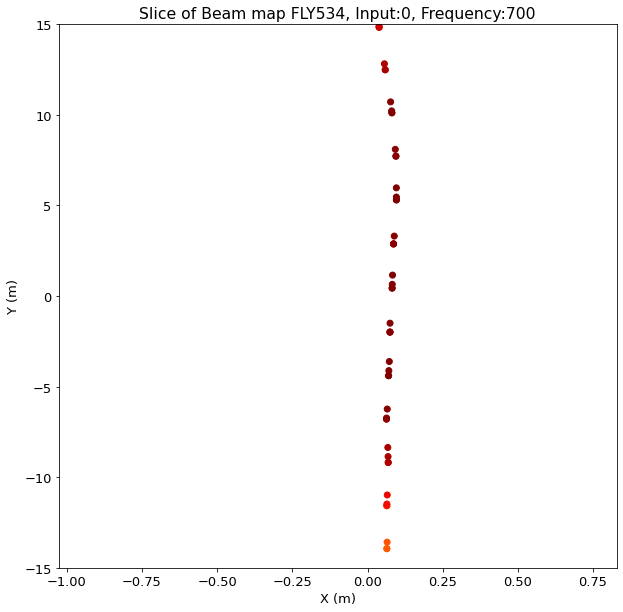

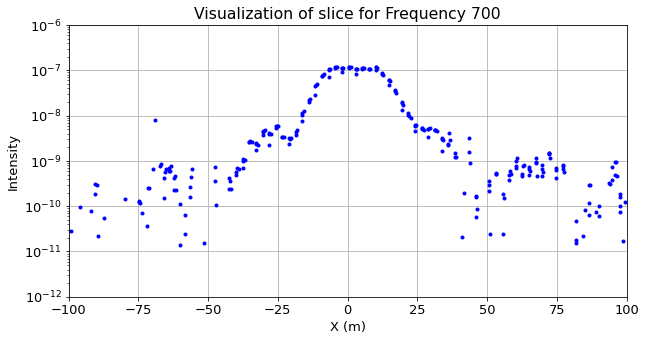

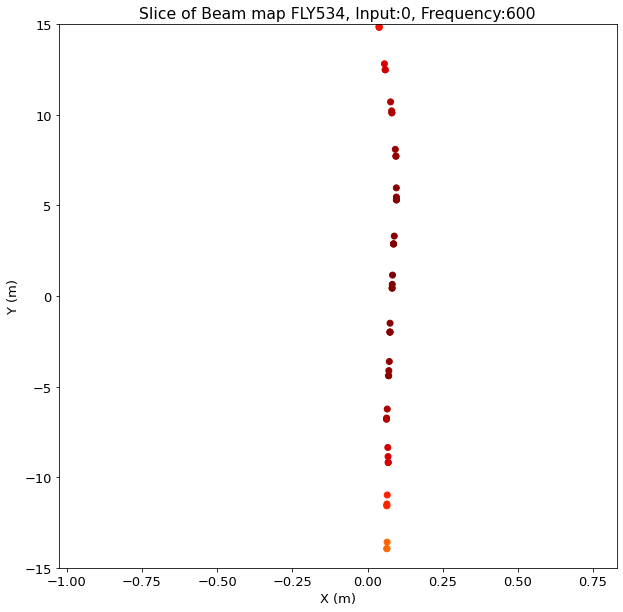

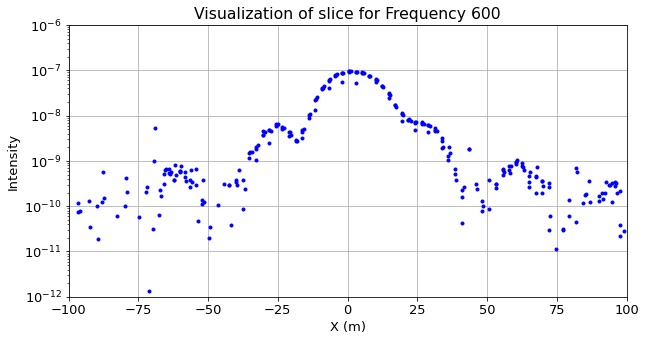

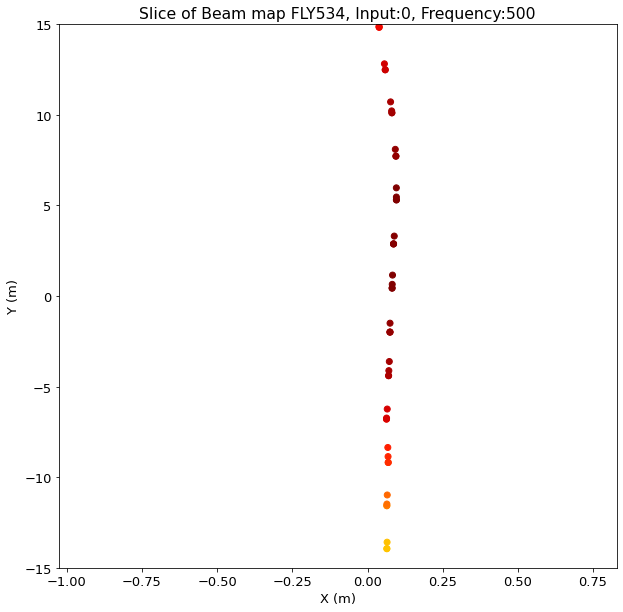

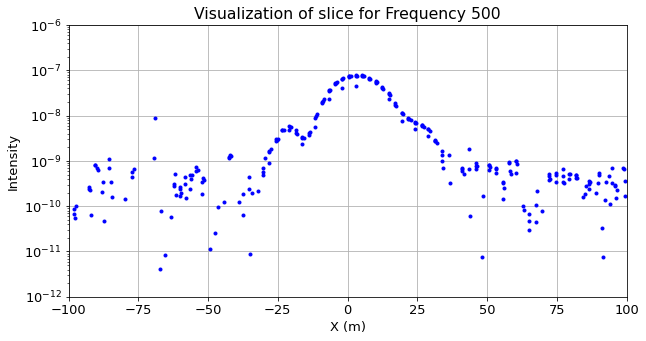

In [57]:
# Flight 534 Input:0

for f in freqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,0,'x',1)

    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.ylim(-15,15)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))
    #plt.xlim(5.35,5.48)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(y[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title(f"Visualization of slice for Frequency {f}")
    plt.xlim(-100,100)
    plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

0


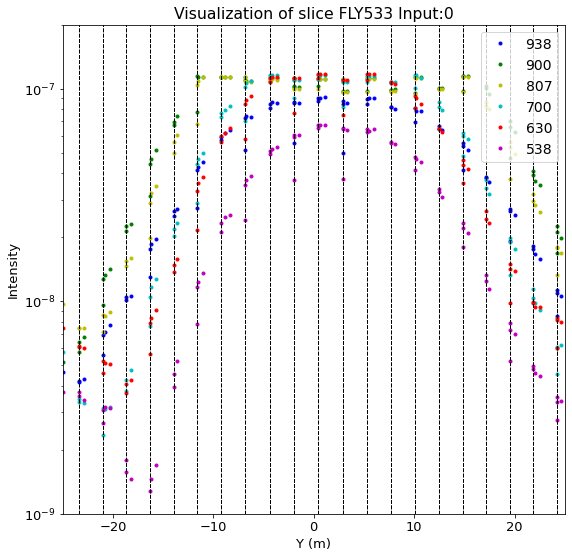

In [66]:
plt.figure(1,figsize=(9,9))
print(dish)


for f, color in zip(goodfreqlist, colors):

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,0,'x',2)
    
    plt.semilogy(y[pp], z[pp], color,label=str(f))

# Finding where Y values have multiple x values
# These values occur for every frequency so don't have to put this bit in the loop 
    
ymult_x=[]

for y_val in y[pp]:
    if np.count_nonzero(np.isclose(y, y_val, atol=.000001)) > 1:
        ymult_x.append(y_val)


# Creating vertical lines where there are multiple values per y 
    
for p in ymult_x:
    
    plt.axvline(p, color='k', linestyle='--',linewidth=1)


plt.legend(prop={'size': 14},loc='upper right')
plt.xlabel('Y (m)')
plt.ylabel('Intensity')
plt.title("Visualization of slice FLY533 Input:" +str(dish))
plt.xlim(-25,25)
plt.ylim(1E-9, 2E-7)
# plt.grid()
plt.show()

frequency index:1000
frequency:409.375
input:2


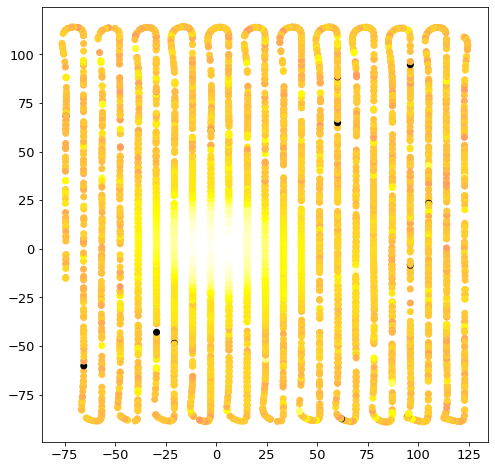

In [67]:
# Flight 534 Input:2

plt.figure(1,figsize=(8,8))

freq = 1000
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= pols[1]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

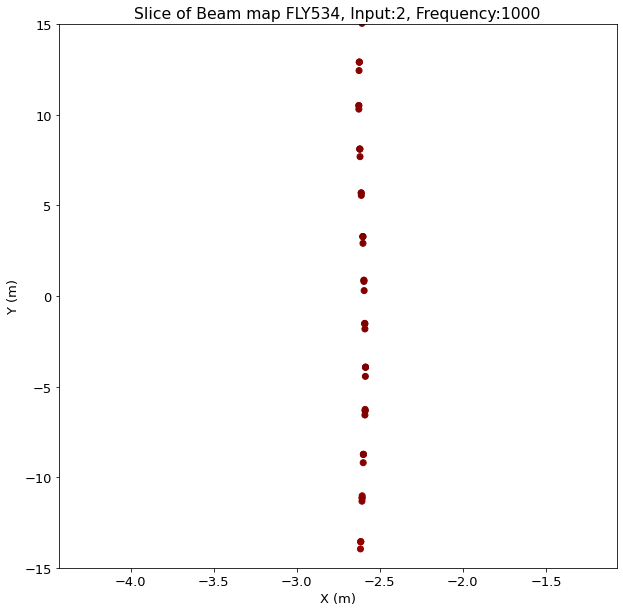

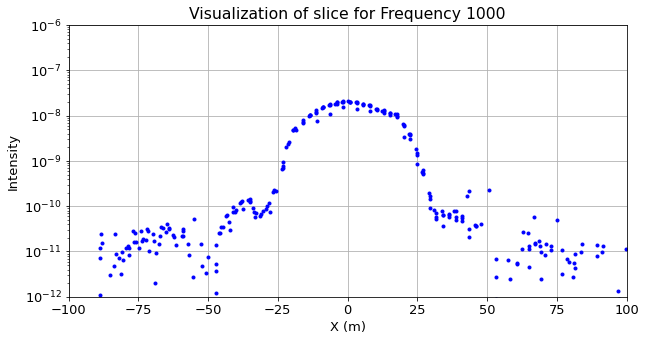

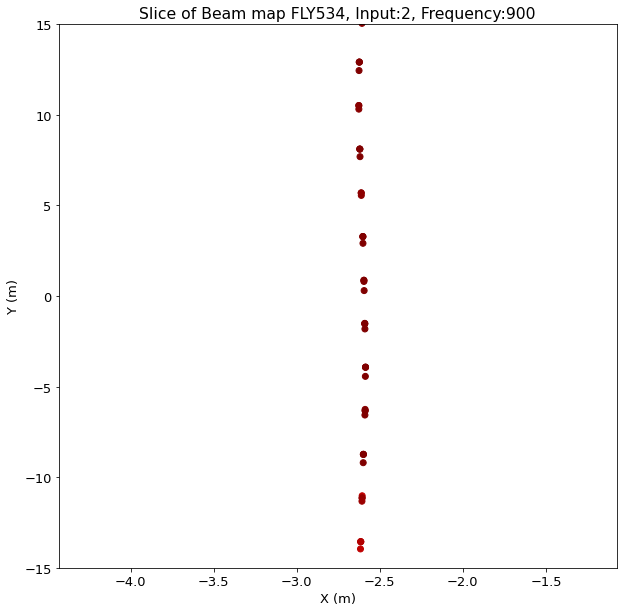

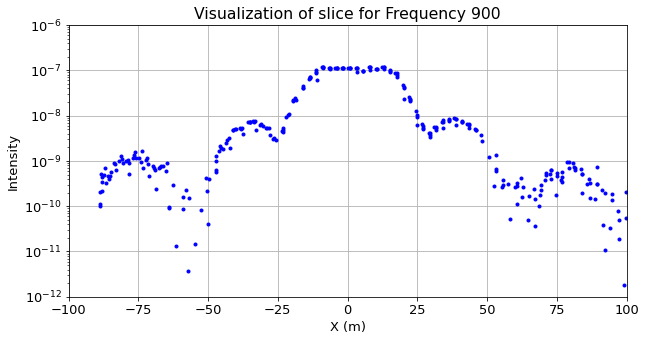

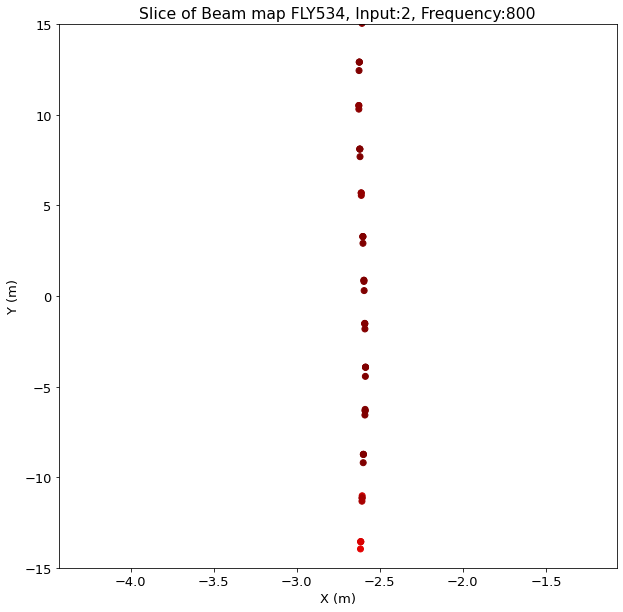

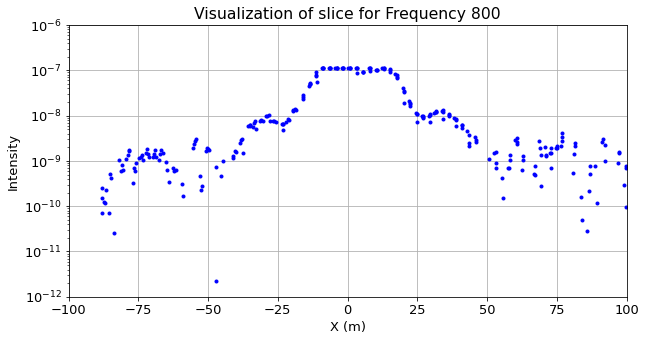

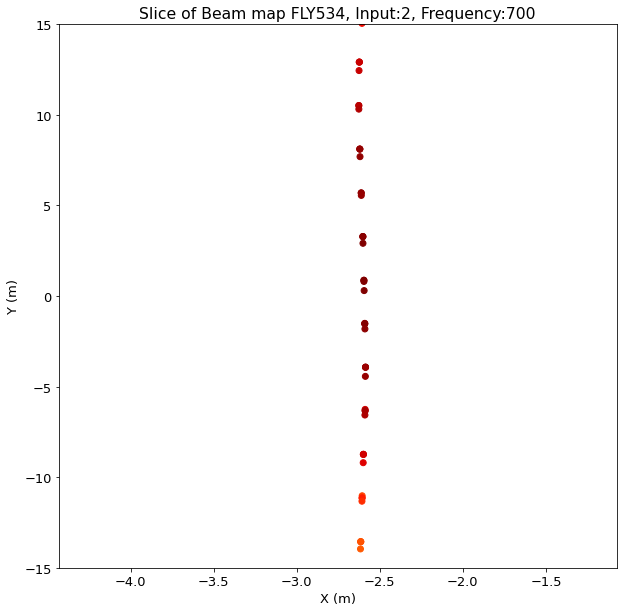

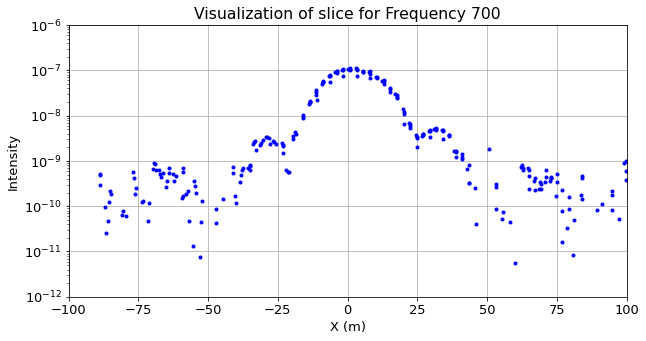

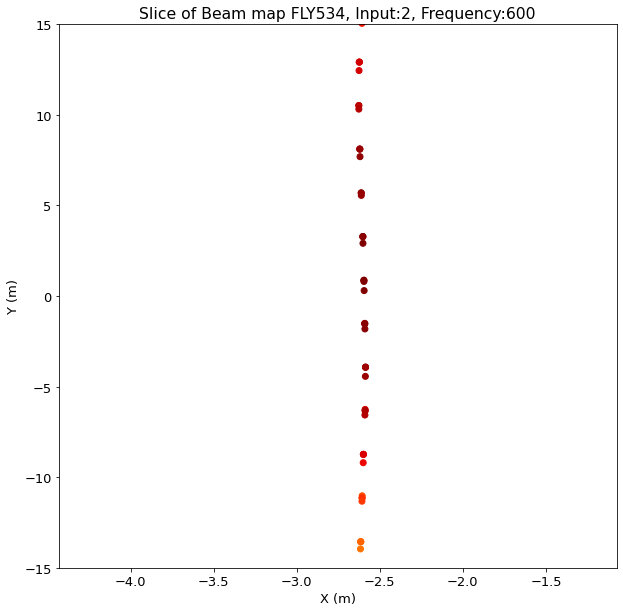

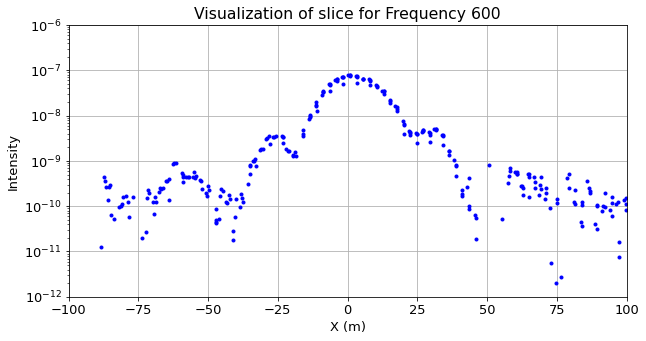

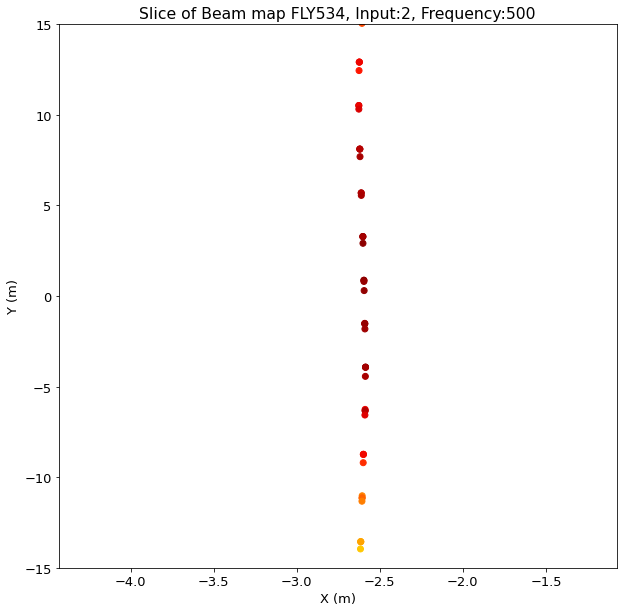

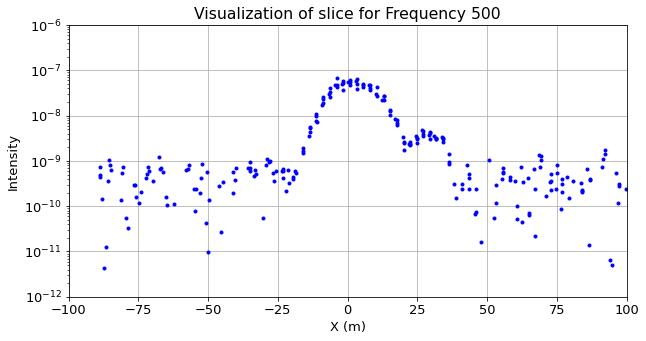

In [68]:
# Flight 534 Input:2

for f in goodfreqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


 

    pp = get_slice_xy(x,y,z,-2.5,'x',2)

    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.ylim(-15,15)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))

    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(y[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title('Visualization of slice for Frequency ' + str(f))
    plt.xlim(-100,100)
    plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

frequency index:938
frequency:433.59375
input:3


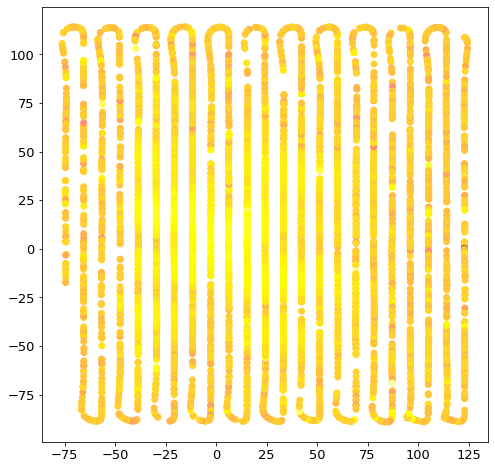

In [69]:
# Flight 534 Input:3
# Input 3 is a cpol for this flight

plt.figure(1,figsize=(8,8))

freq = 938
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= cpols[1]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

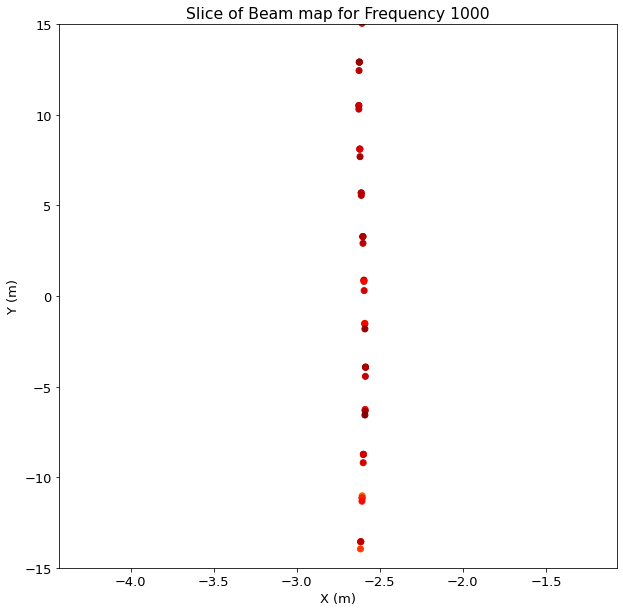

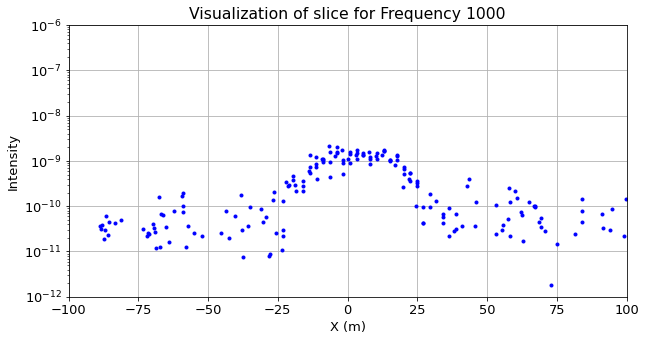

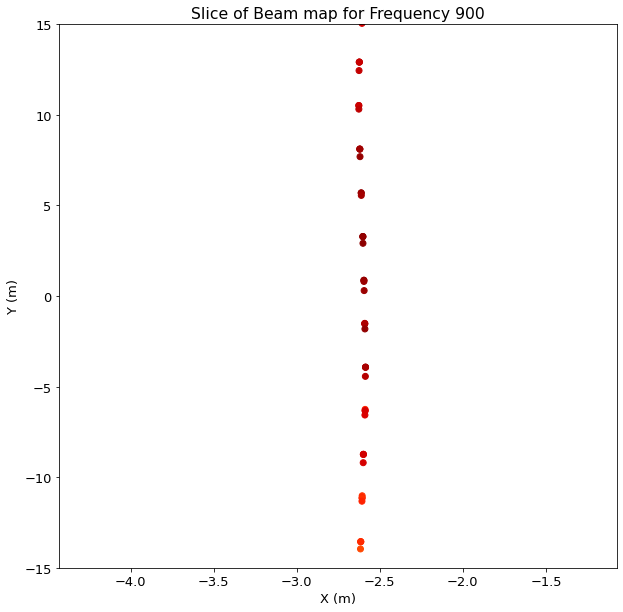

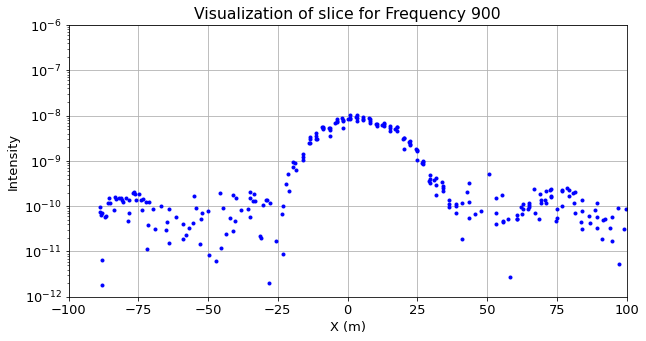

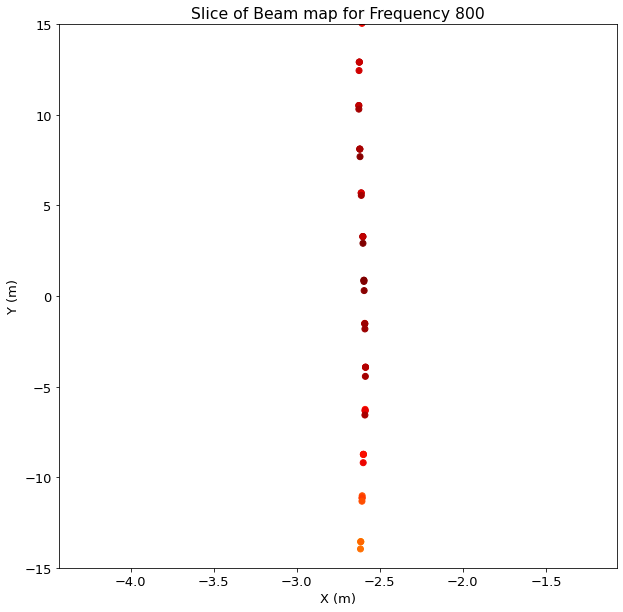

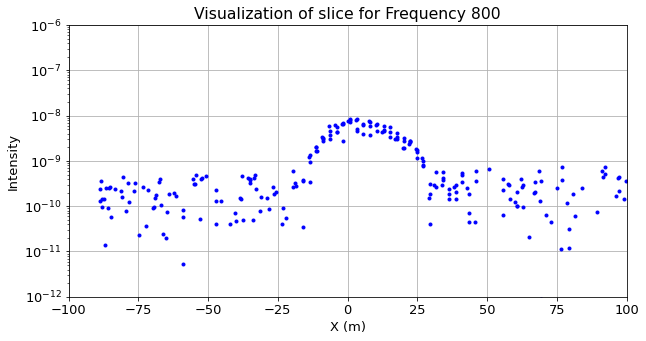

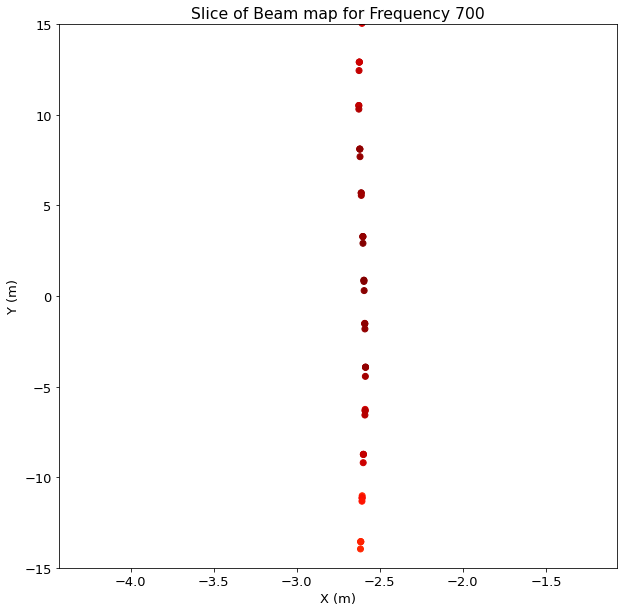

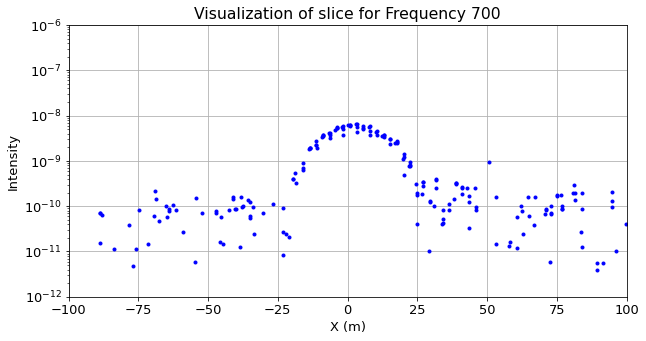

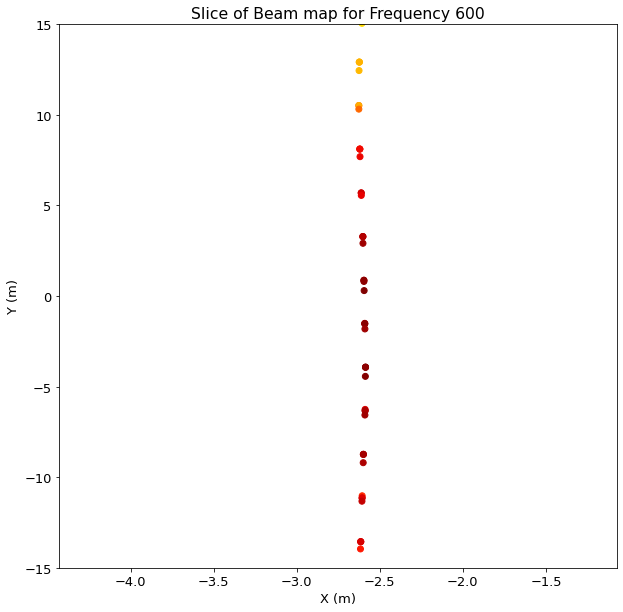

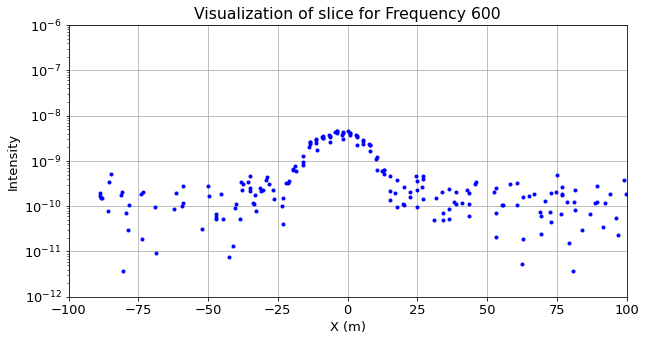

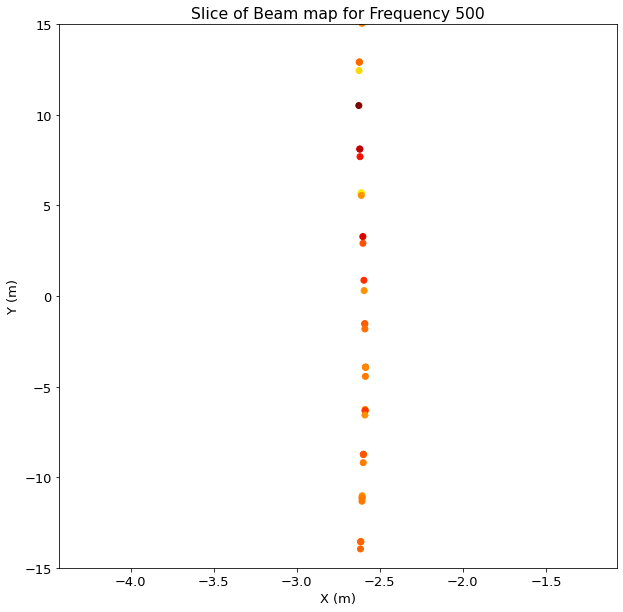

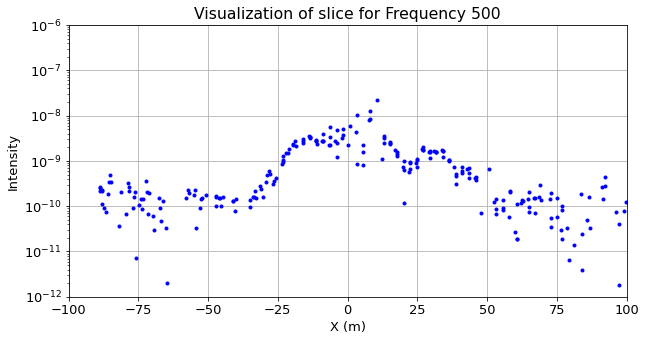

In [70]:
# Flight 534 Input:3
# Input 3 is a cpol for this flight 


for f in goodfreqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,-2.5,'x',2)

    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.ylim(-15,15)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))
    #plt.xlim(5.35,5.48)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(y[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title('Visualization of slice for Frequency ' + str(f))
    plt.xlim(-100,100)
    plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

In [71]:
# Reading in file for Flight 535
# Matching inputs from Audrey's slides I'll graph pols:0,10,14 and cpols:3,9

fly = '535'

pklfile = glob.glob(pckldir+'*'+fly+'*')[0]
print(pklfile)

with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]

for fi in range(0,len(documents["flight_info"]["flights"])):
    if fly == flights[fi]: f = fi
print('FLIGHT: ', documents["flight_info"]["flights"][f])

pol = documents["flight_info"]["pols"][f]

if pol=='N':
    pols = N_pols
    cpols = E_pols
else:
    pols = E_pols
    cpols = N_pols
    
    
print(fly,pol,pols,cpols)

/hirax/GBO_Analysis_Outputs/flight_pickles/FLY535_20210826T192056Z_ver_20230412T213957_concat.pkl
FLIGHT:  535
535 E [0, 2, 8, 10, 14] [1, 3, 9, 11, 15]


frequency index:938
frequency:433.59375
input:0


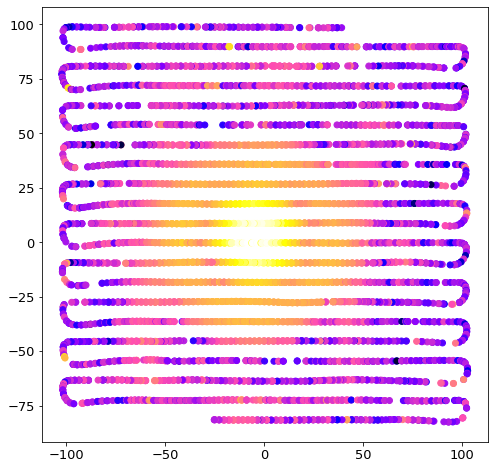

In [72]:
# Flight 535 Input:0

plt.figure(1,figsize=(8,8))

freq = 938
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= pols[0]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

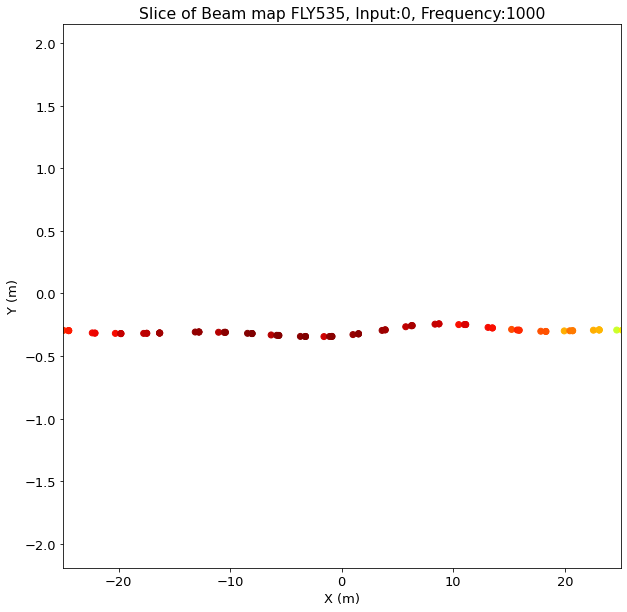

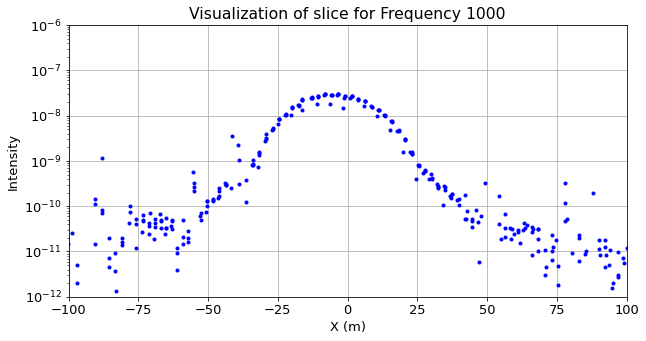

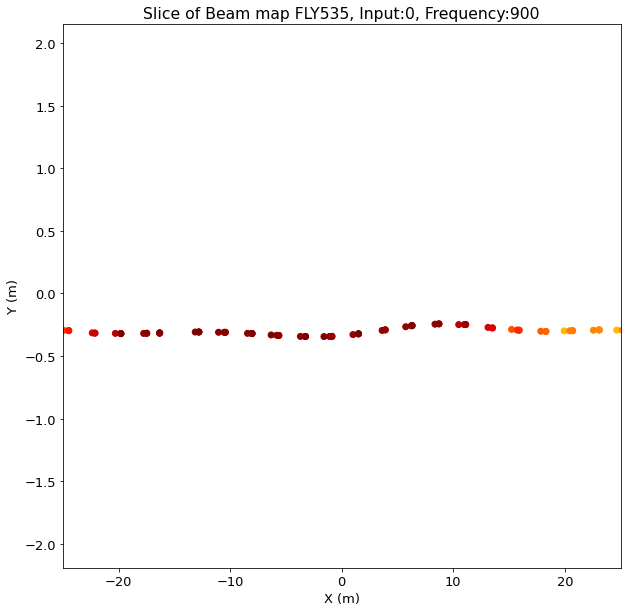

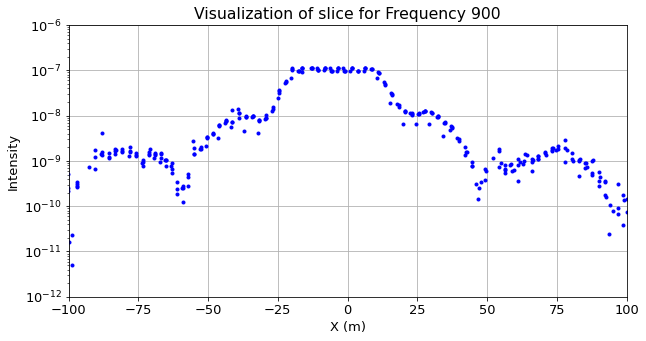

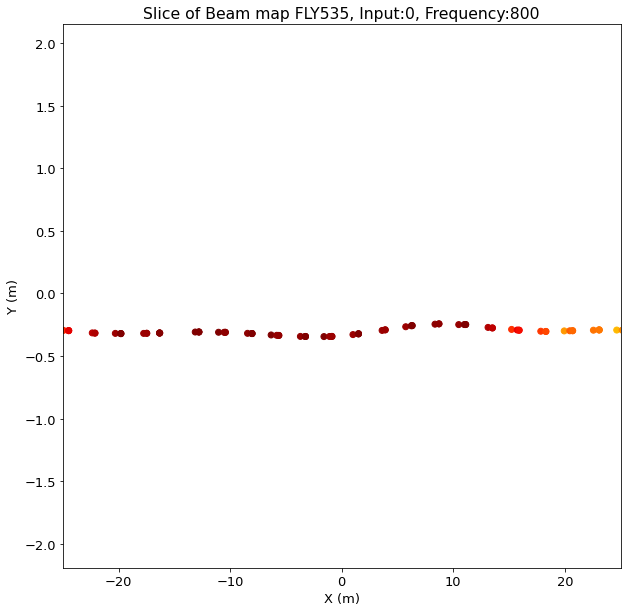

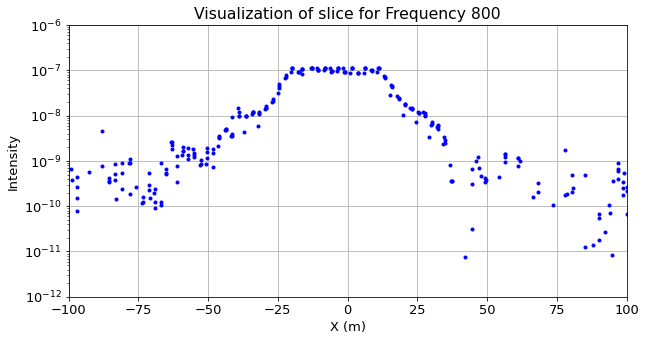

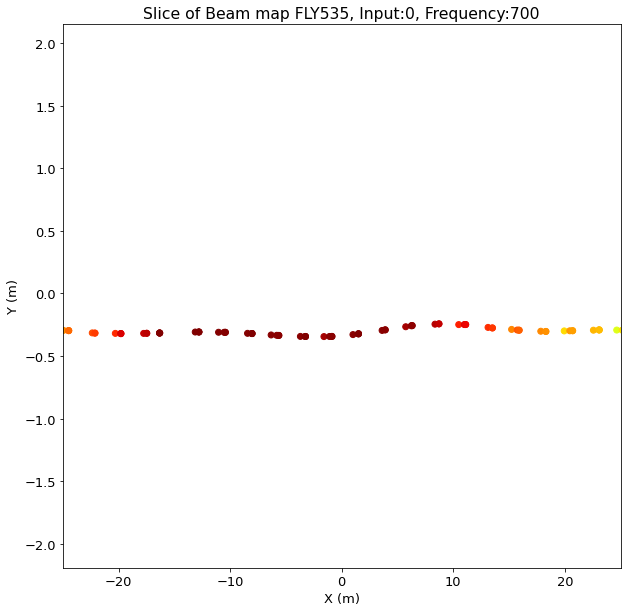

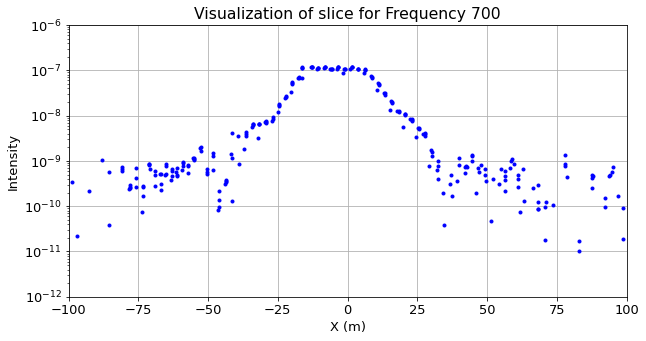

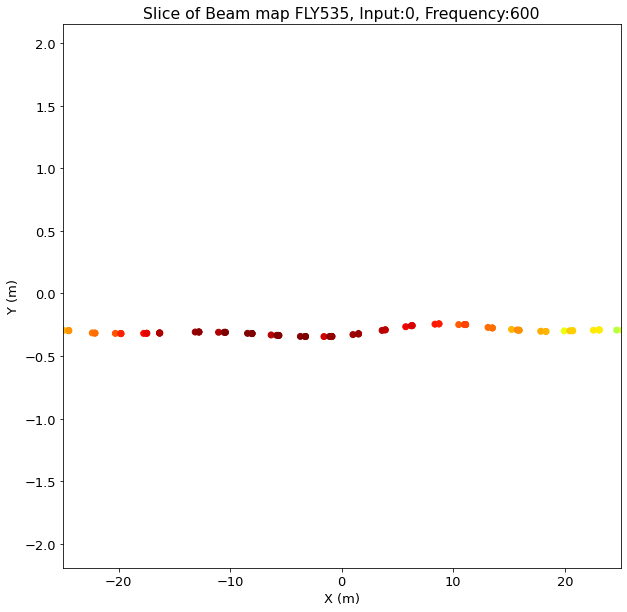

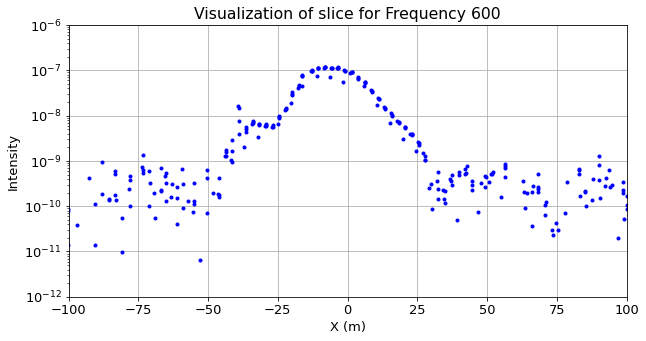

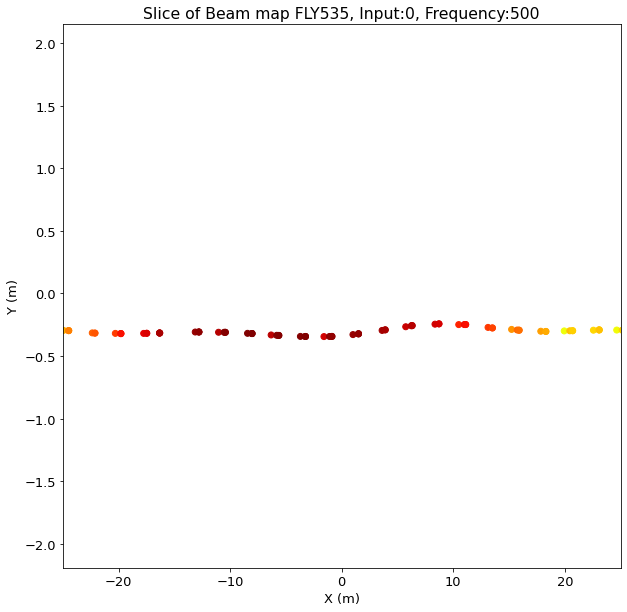

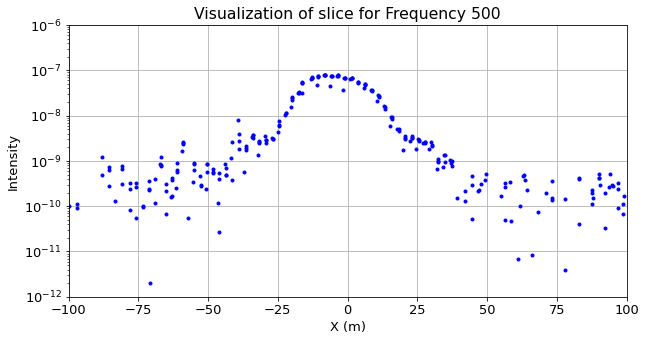

In [73]:
# Flight 535 Input:0


for f in goodfreqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,0,'y',2)

    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.xlim(-25,25)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))
    #plt.xlim(5.35,5.48)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(x[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title('Visualization of slice for Frequency ' + str(f))
    plt.xlim(-100,100)
    plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

frequency index:938
frequency:433.59375
input:10


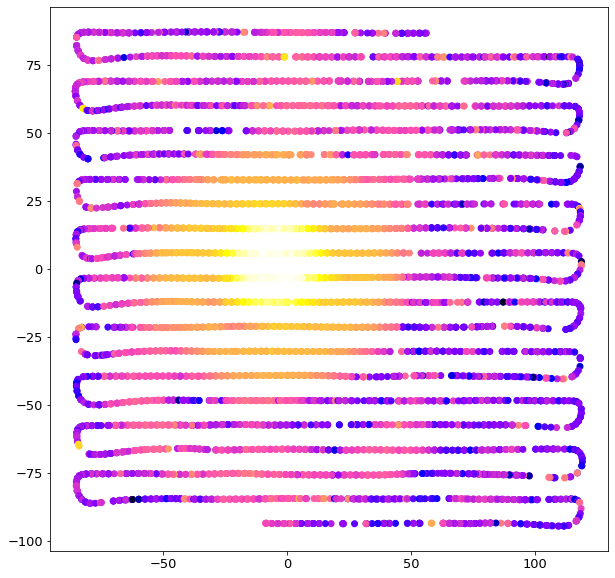

In [74]:
# Flight 535 Input:10

plt.figure(1,figsize=(8,8))

freq = 938
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= pols[3]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

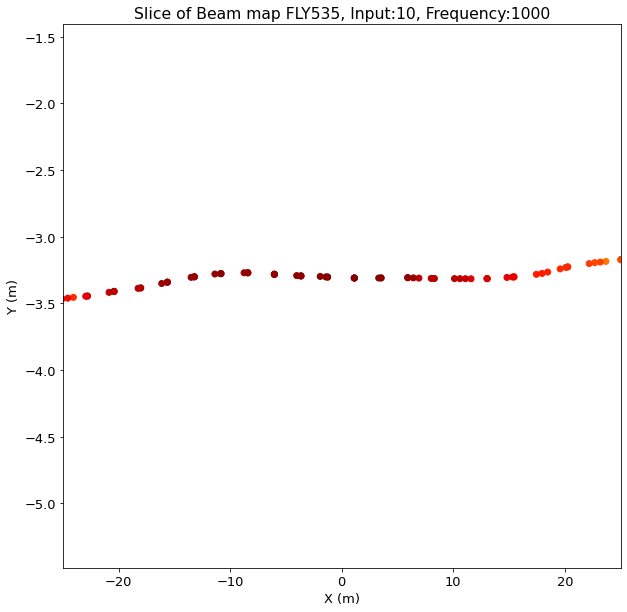

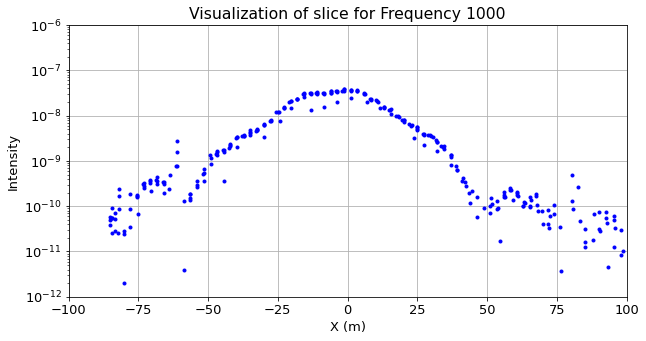

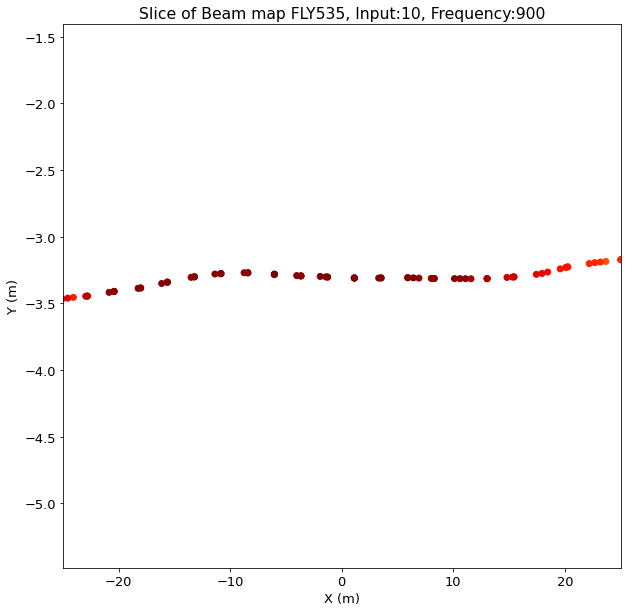

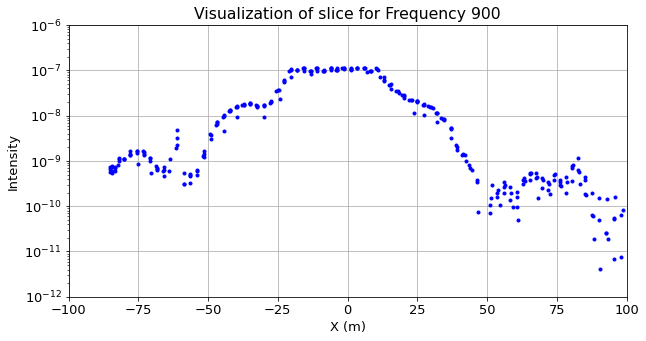

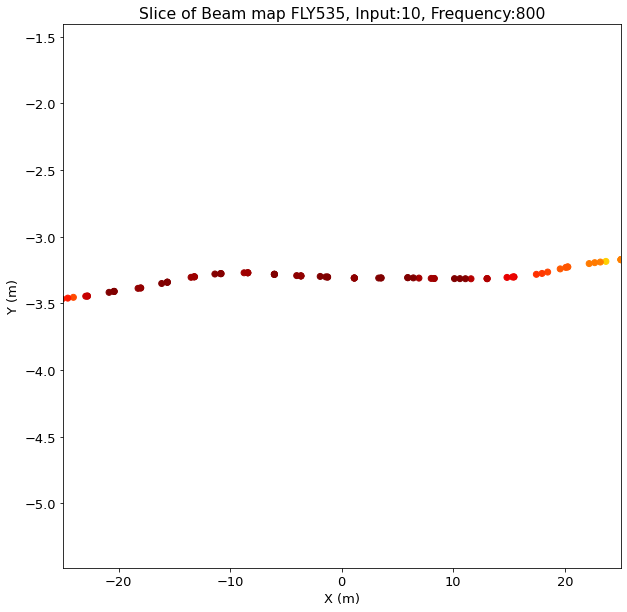

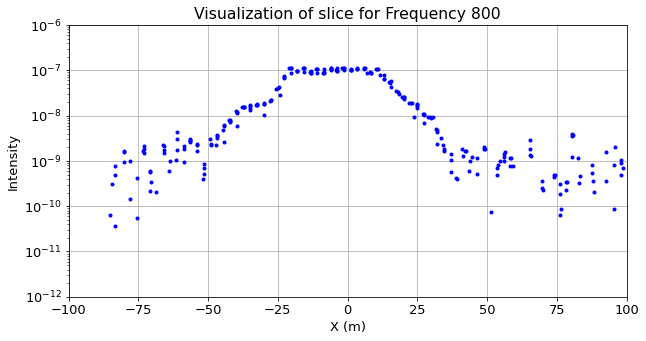

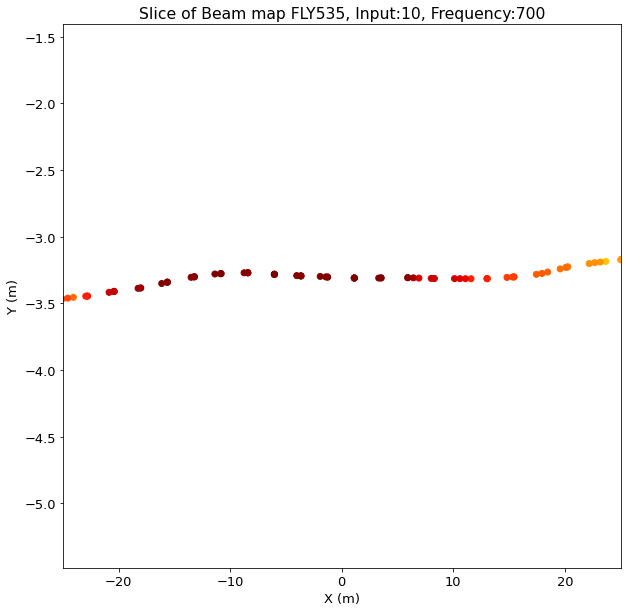

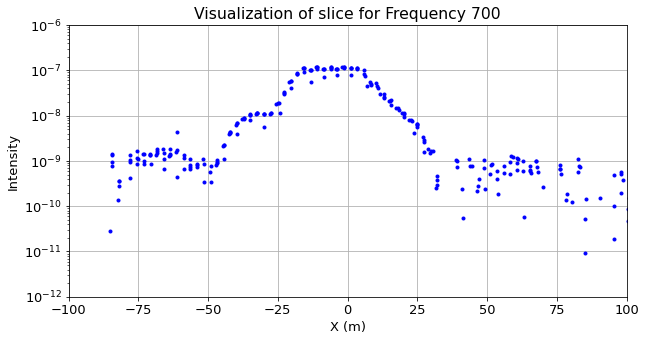

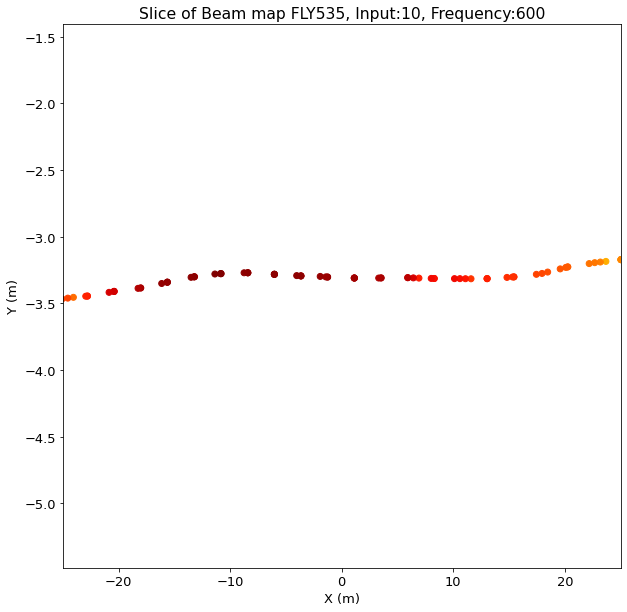

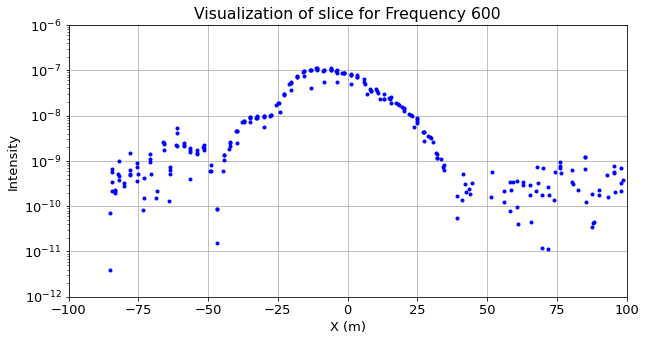

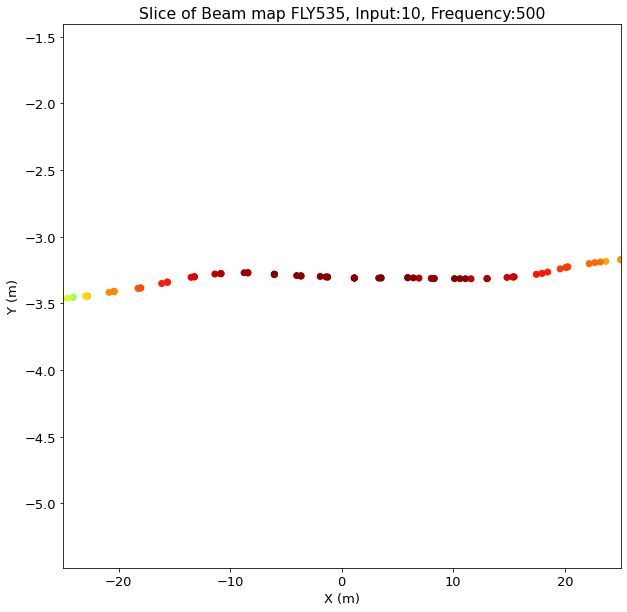

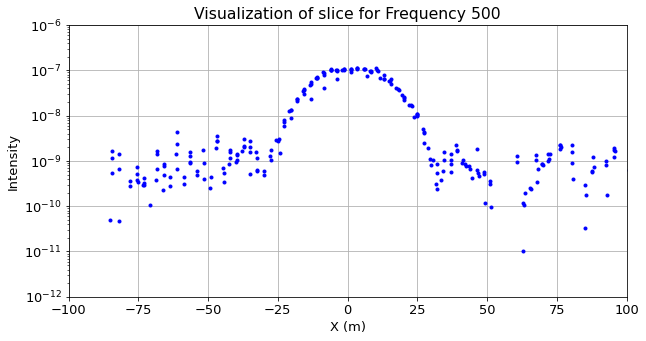

In [75]:
# Flight 535 Input:10

for f in goodfreqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,-3.5,'y',2)

    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.xlim(-25,25)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(x[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title('Visualization of slice for Frequency ' + str(f))
    plt.xlim(-100,100)
    plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

frequency index:938
frequency:433.59375
input:14


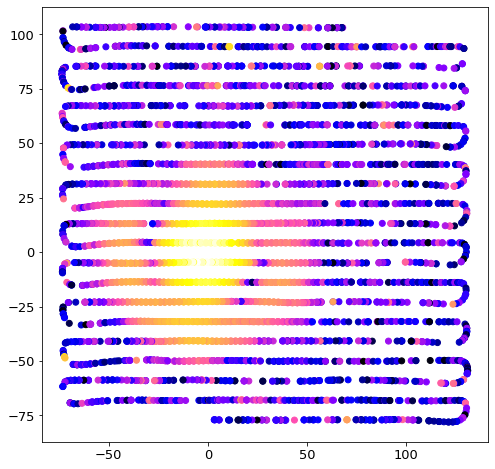

In [76]:
# Flight 535 Input:14

plt.figure(1,figsize=(8,8))

freq = 938
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= pols[4]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

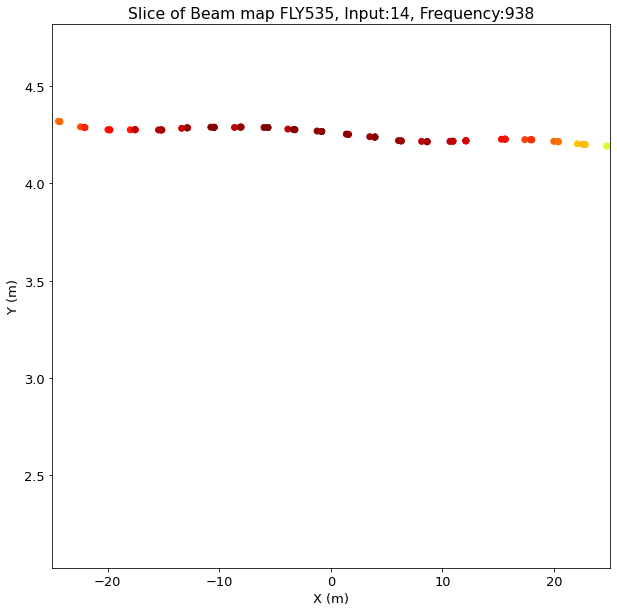

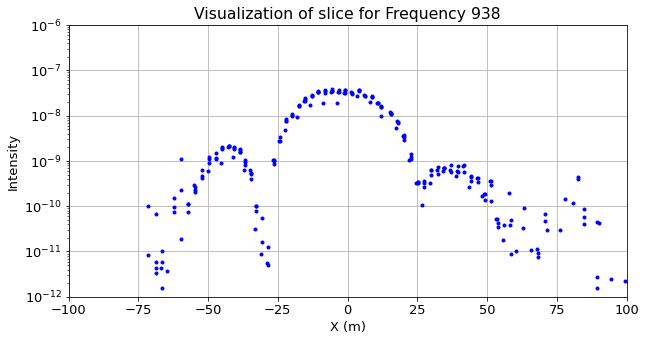

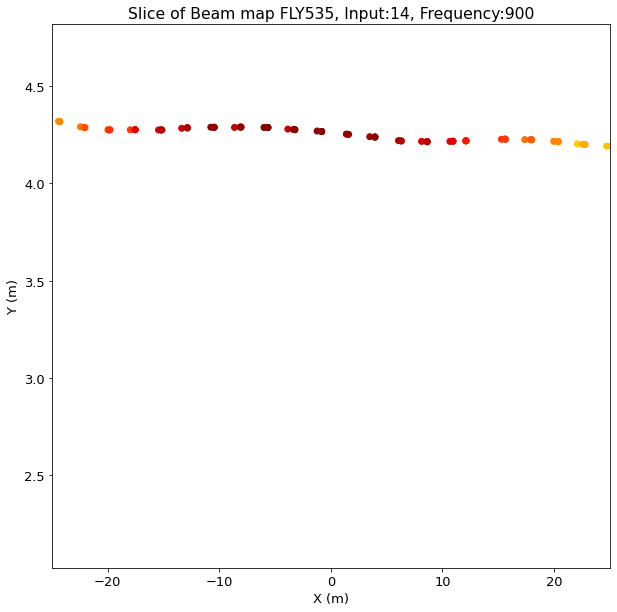

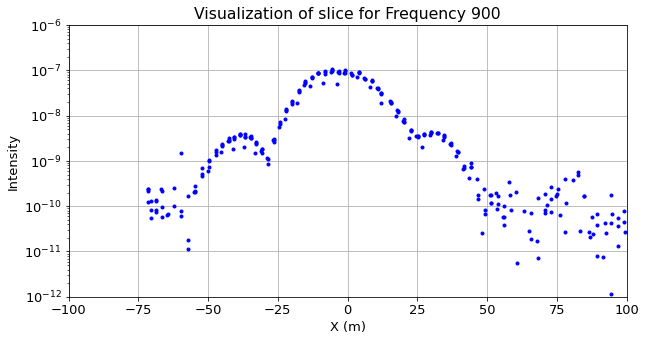

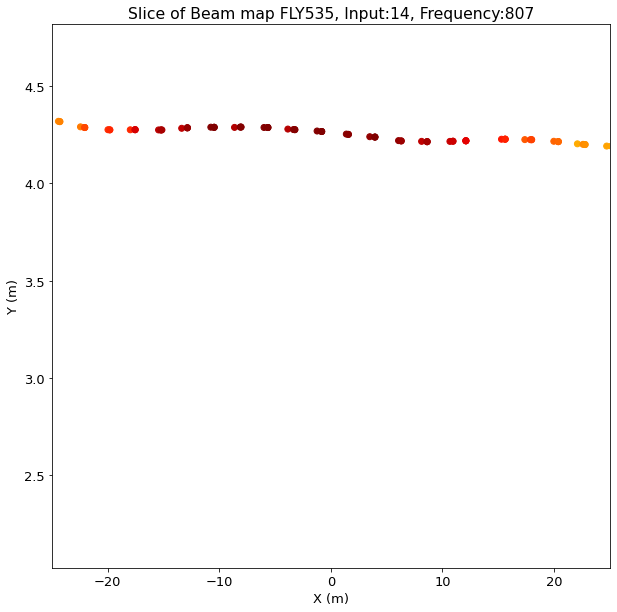

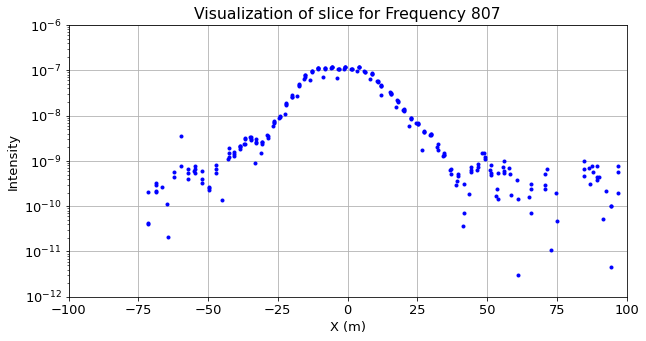

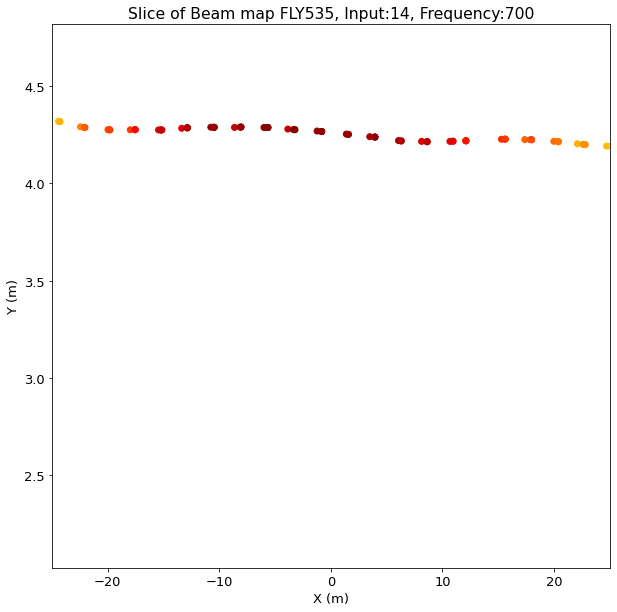

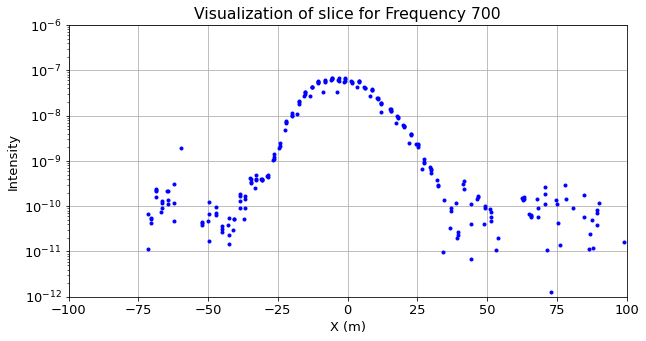

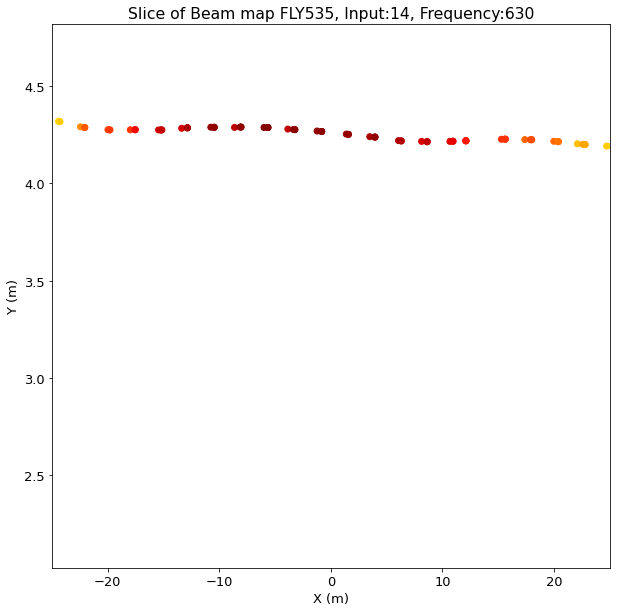

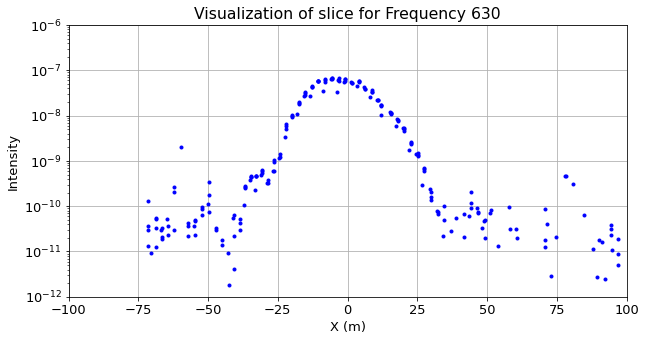

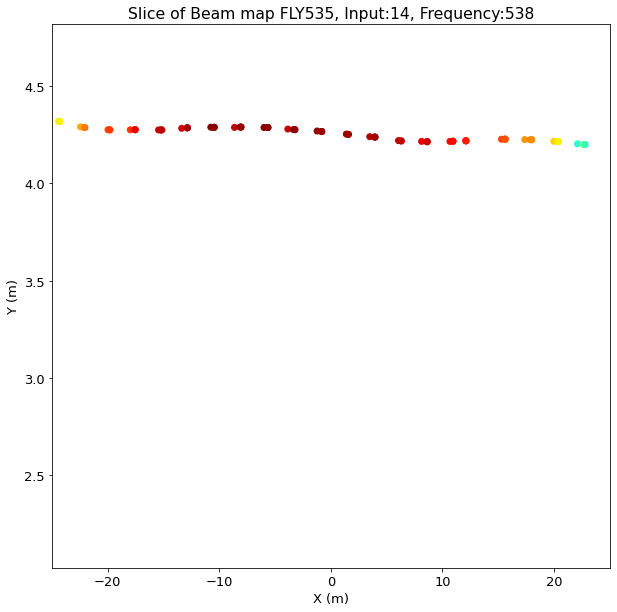

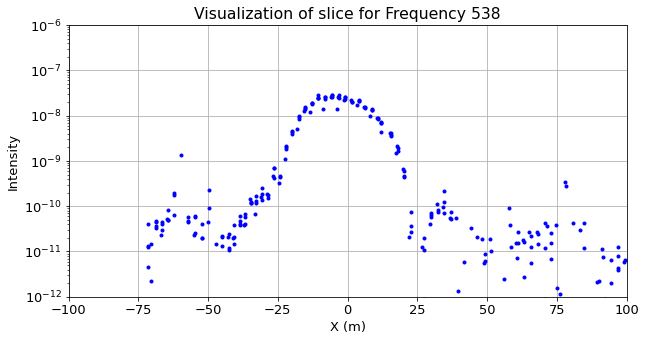

In [78]:
# Flight 535 Input:14

for f in goodfreqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]

    pp = get_slice_xy(x,y,z,4,'y',2)

    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.xlim(-25,25)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))

    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(x[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title('Visualization of slice for Frequency ' + str(f))
    plt.xlim(-100,100)
    plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

frequency index:938
frequency:433.59375
input:3


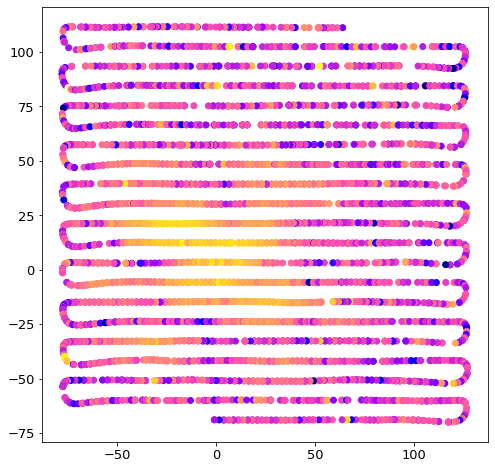

In [79]:
# Flight 535 Input:3
# Input 3 is a cpol for this flight 

plt.figure(1,figsize=(8,8))

freq = 938
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= cpols[1]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

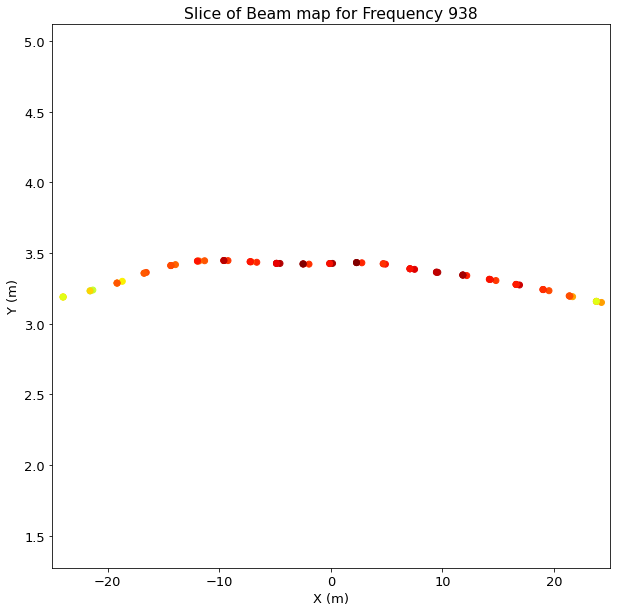

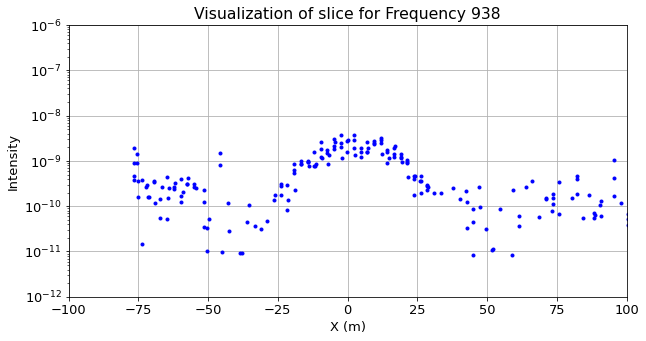

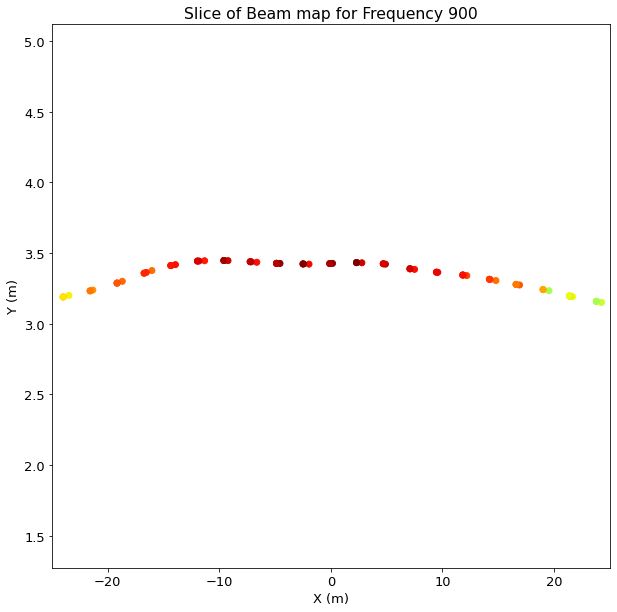

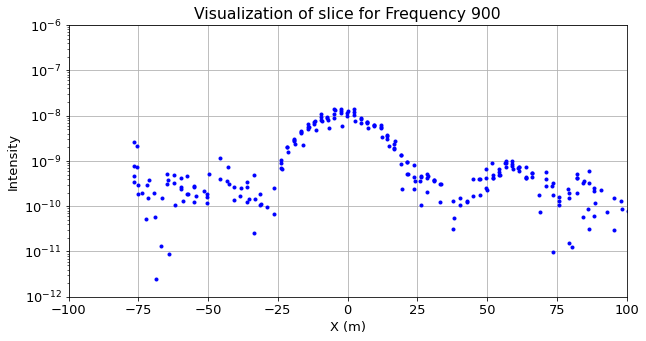

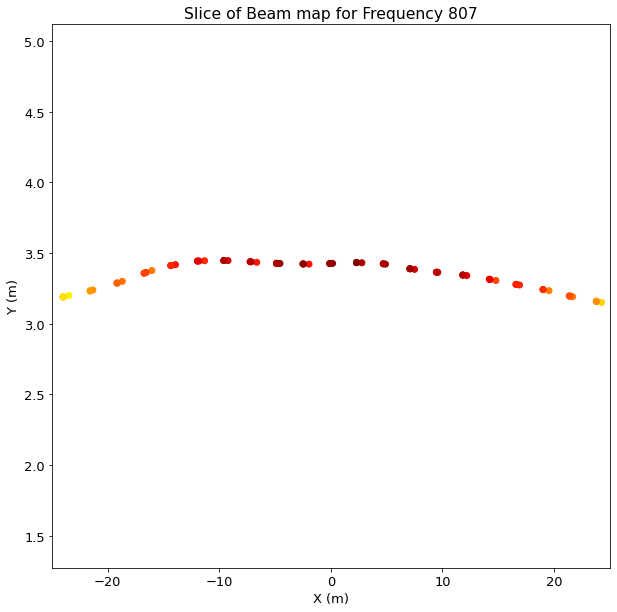

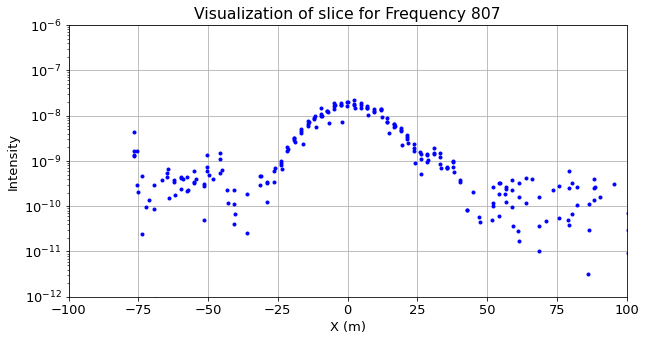

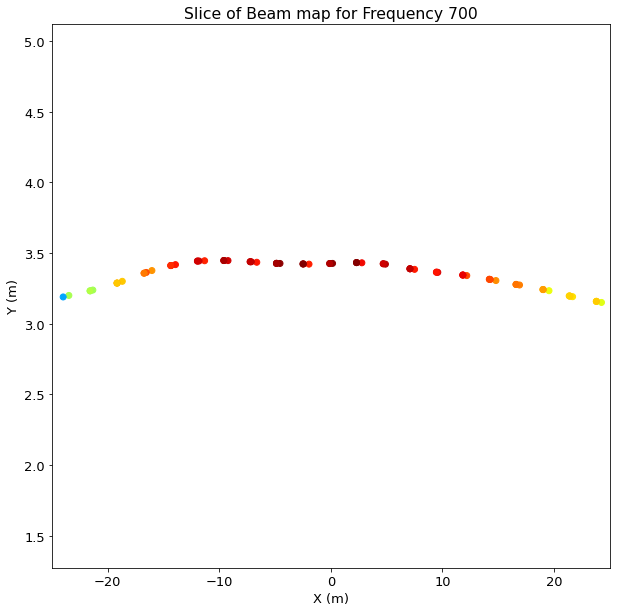

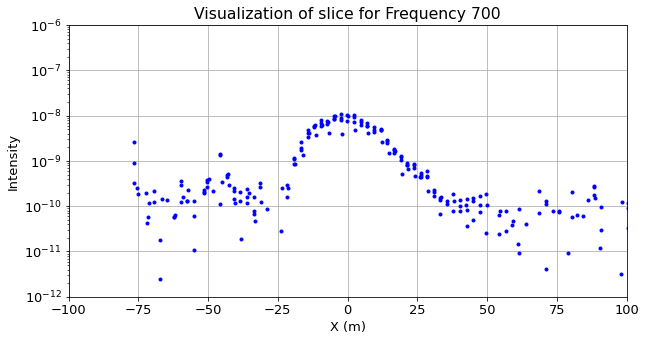

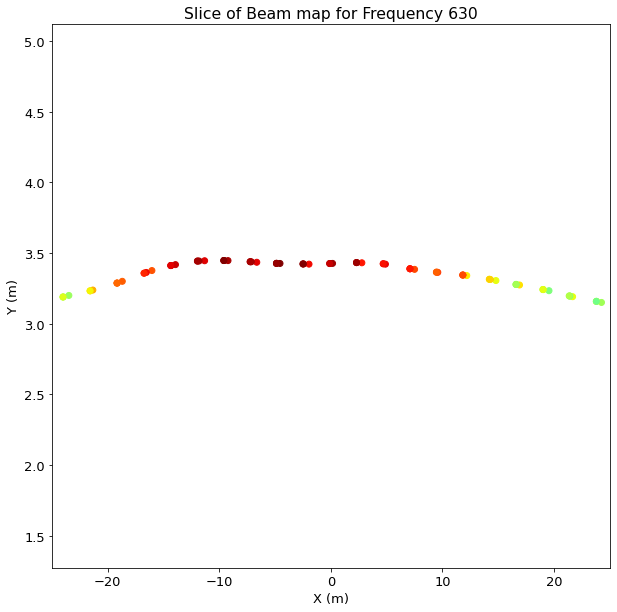

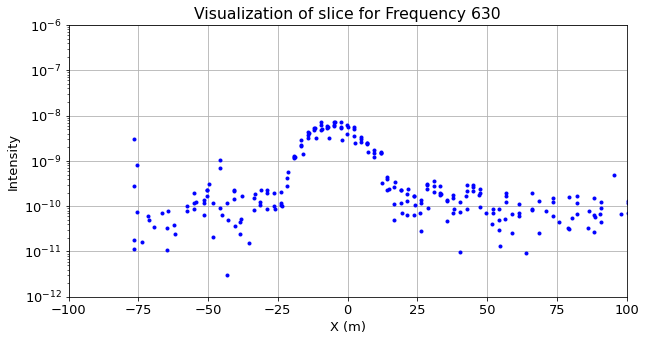

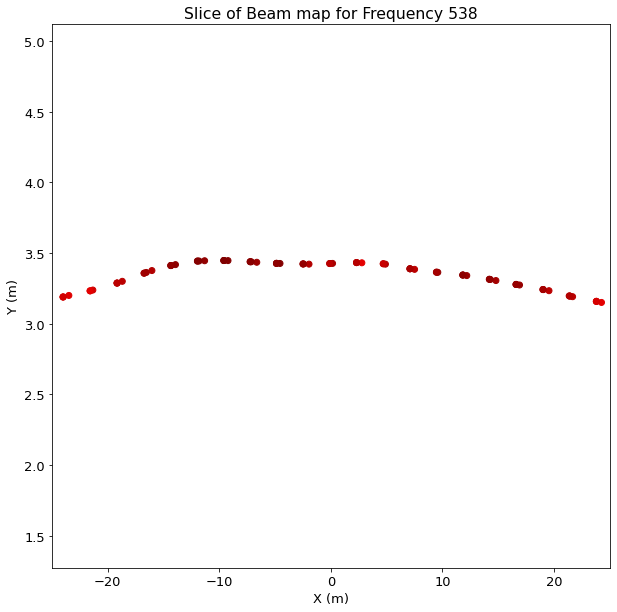

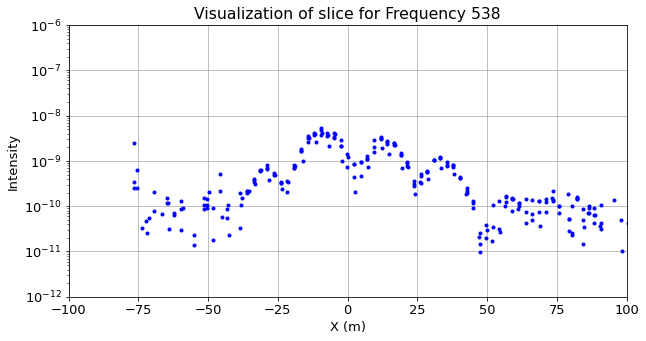

In [80]:
# Flight 535 Input:3


for f in goodfreqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]

    pp = get_slice_xy(x,y,z,3,'y',2)

    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.xlim(-25,25)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map for Frequency ' + str(f))
#     plt.xlim(5.35,5.48)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(x[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title('Visualization of slice for Frequency ' + str(f))
    plt.xlim(-100,100)
    plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

frequency index:938
frequency:433.59375
input:9


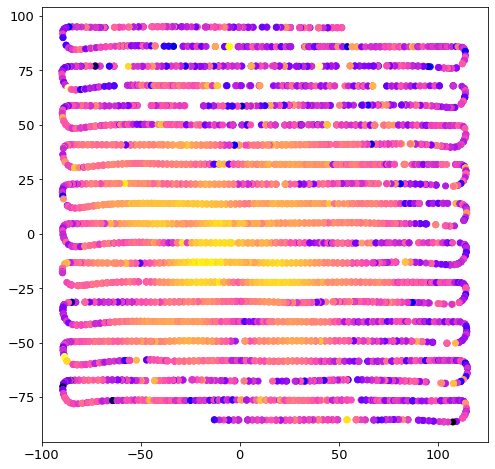

In [81]:
# Flight 535 Input:9
# Input 9 is a cpol for this flight 

plt.figure(1,figsize=(8,8))

freq = 938
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= cpols[2]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

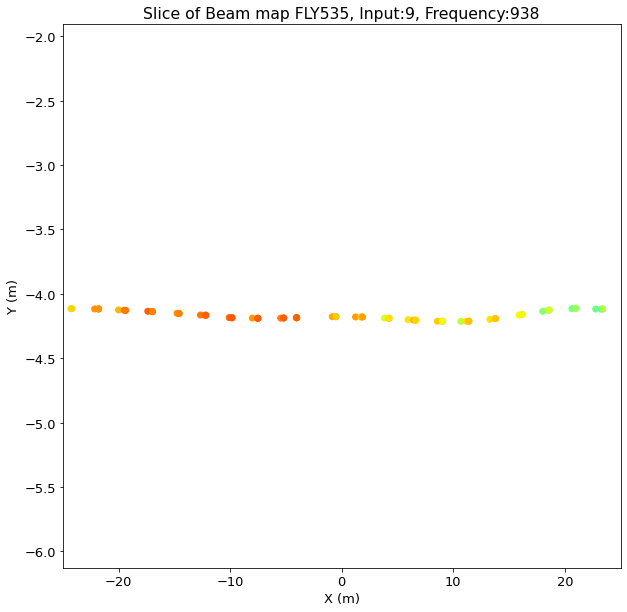

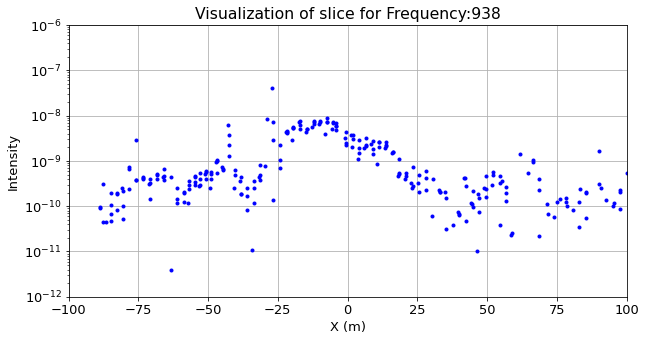

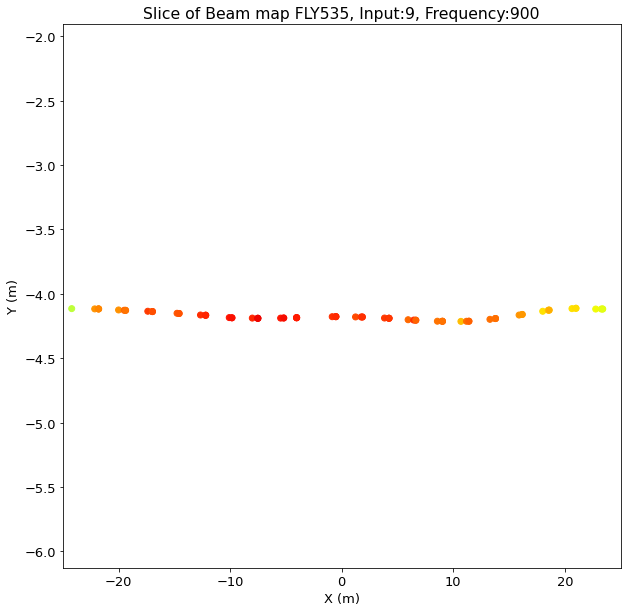

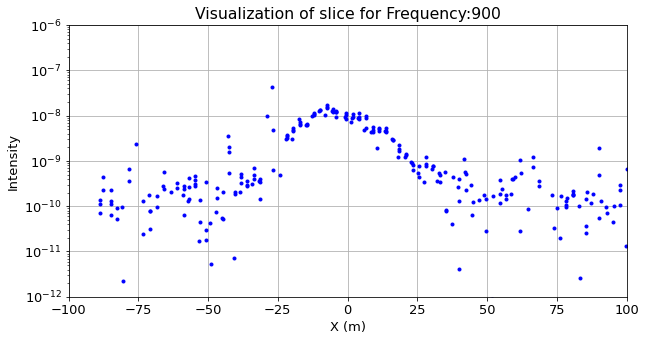

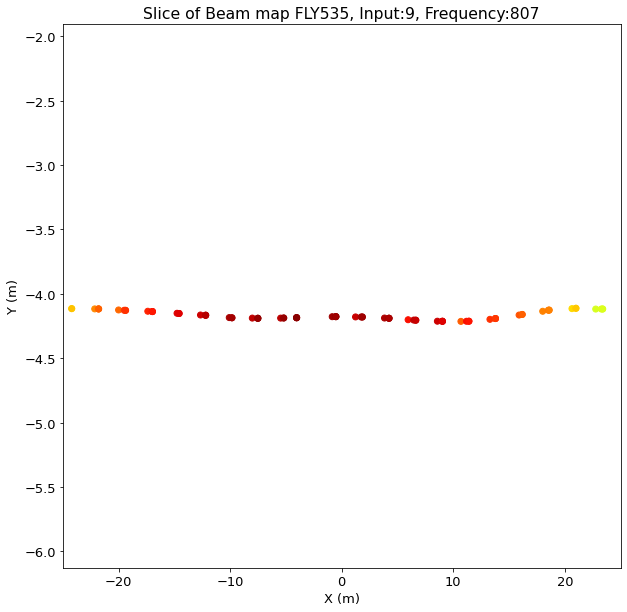

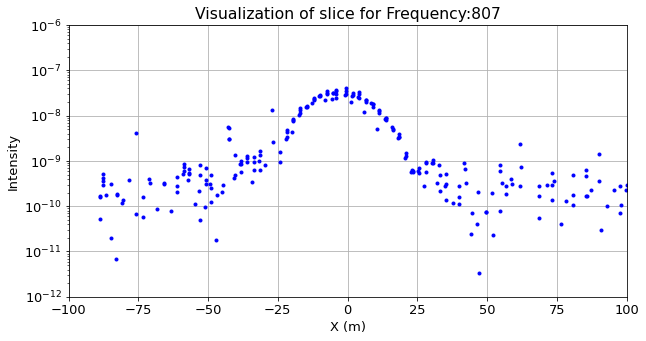

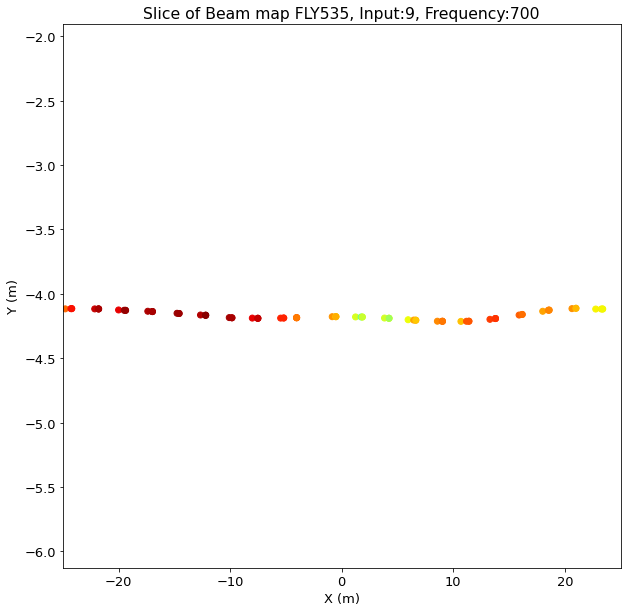

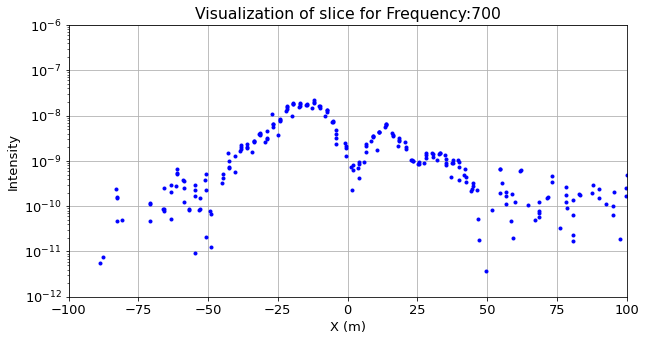

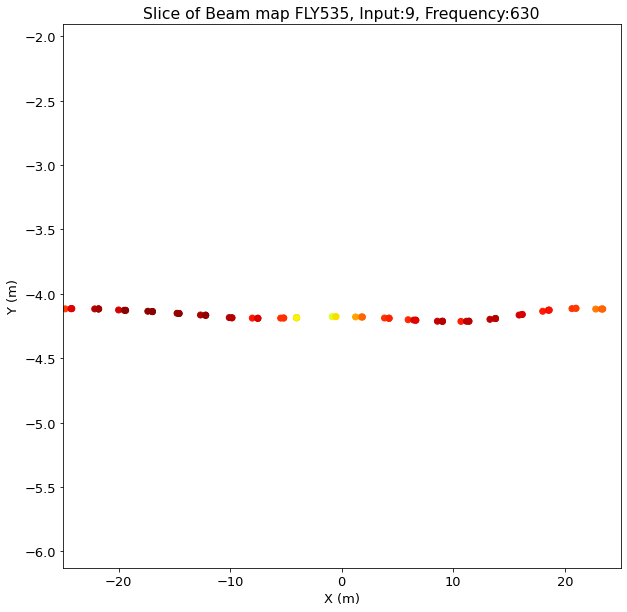

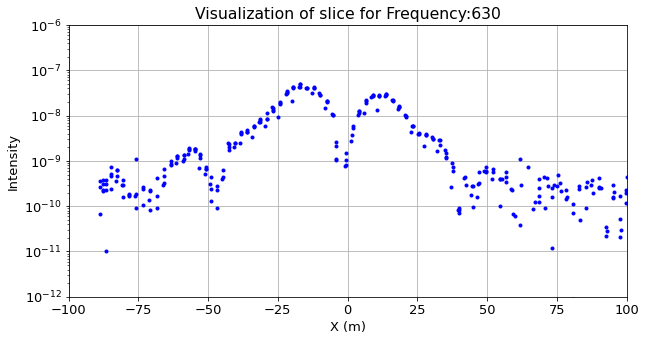

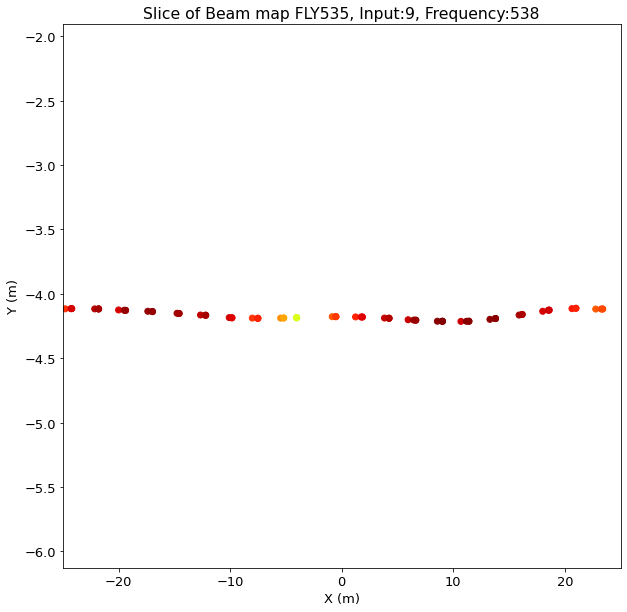

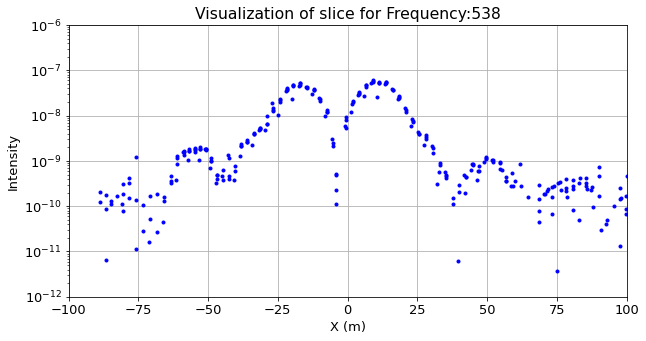

In [82]:
# Flight 535 Input:9

for f in goodfreqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,-4,'y',2)

    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.xlim(-25,25)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(x[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title('Visualization of slice for Frequency:' + str(f))
    plt.xlim(-100,100)
    plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

In [83]:
# Reading in file for Flight 618
# Checking bright October flights

fly = '618'

pklfile = glob.glob(pckldir+'*'+fly+'*')[0]
print(pklfile)

with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]

for fi in range(0,len(documents["flight_info"]["flights"])):
    if fly == flights[fi]: f = fi
print('FLIGHT: ', documents["flight_info"]["flights"][f])

pol = documents["flight_info"]["pols"][f]

if pol=='N':
    pols = N_pols
    cpols = E_pols
else:
    pols = E_pols
    cpols = N_pols
    
    
print(fly,pol,pols,cpols)

/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl
FLIGHT:  618
618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14]


frequency index:938
frequency:433.59375
input:1


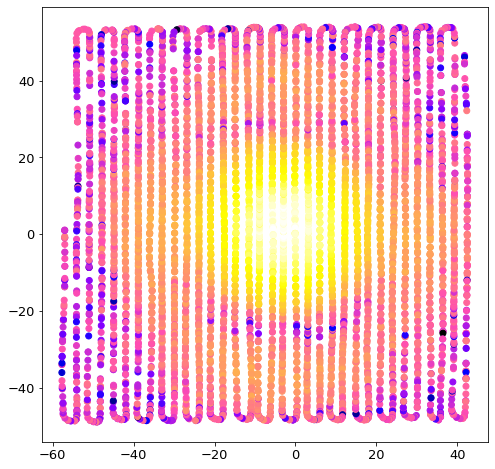

In [84]:
# Flight 618 Input:1

plt.figure(1,figsize=(8,8))

freq = 938
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= pols[0]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

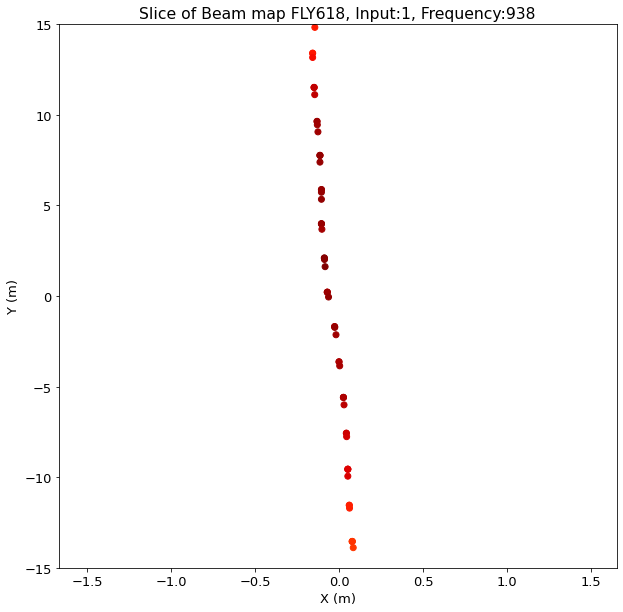

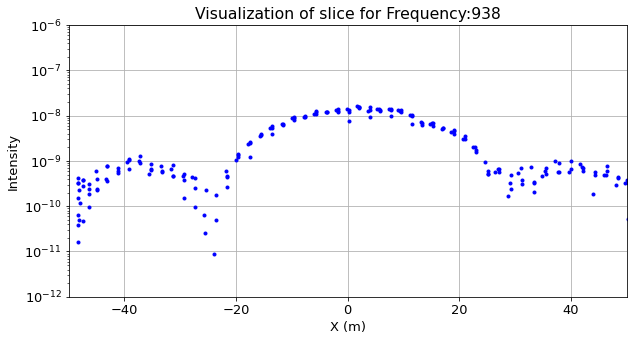

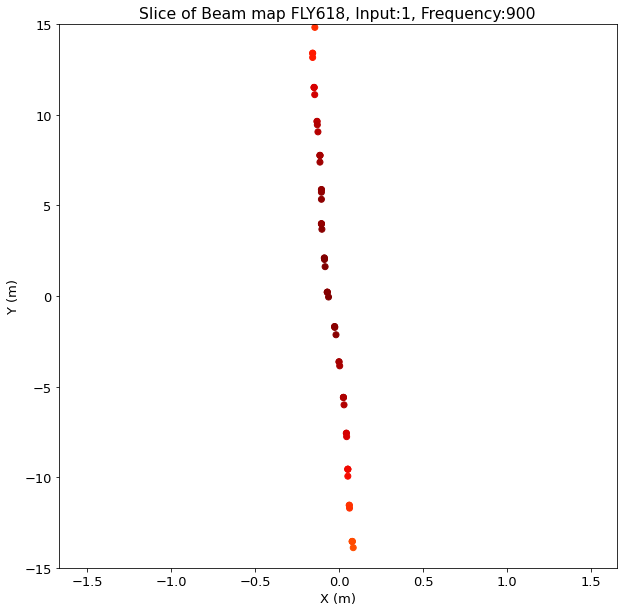

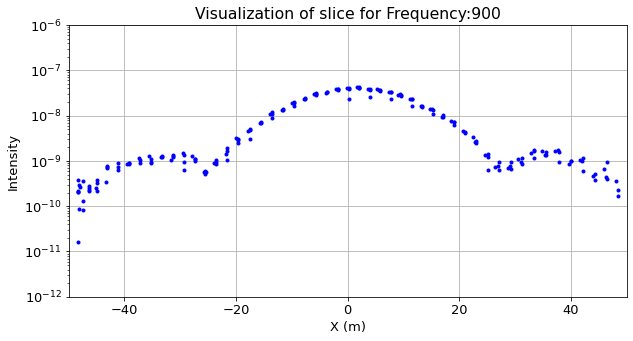

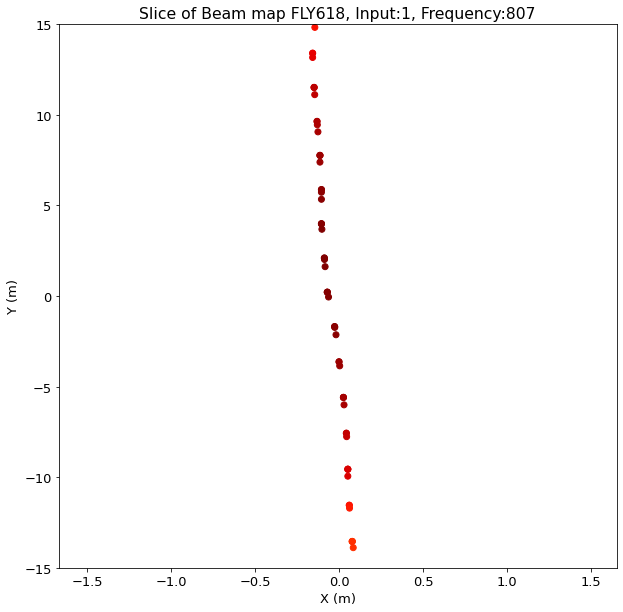

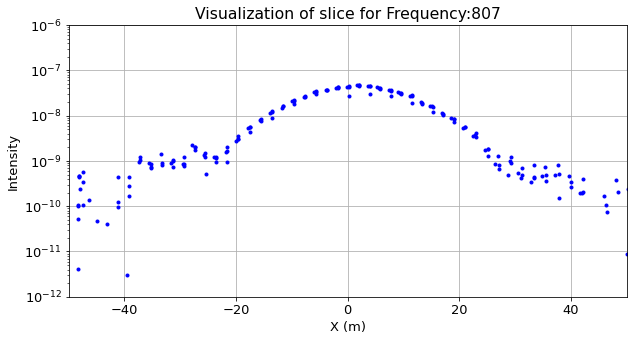

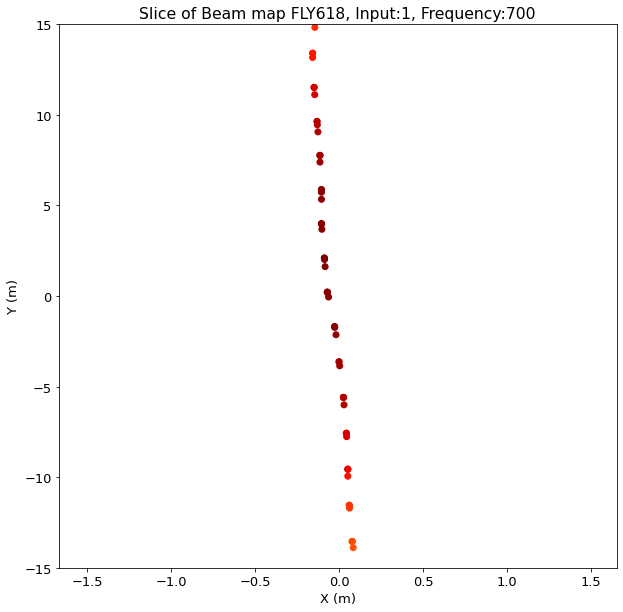

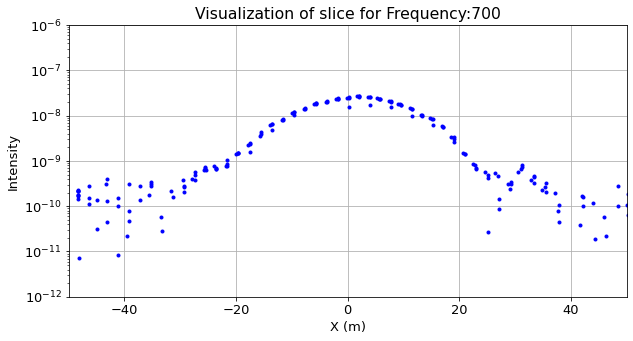

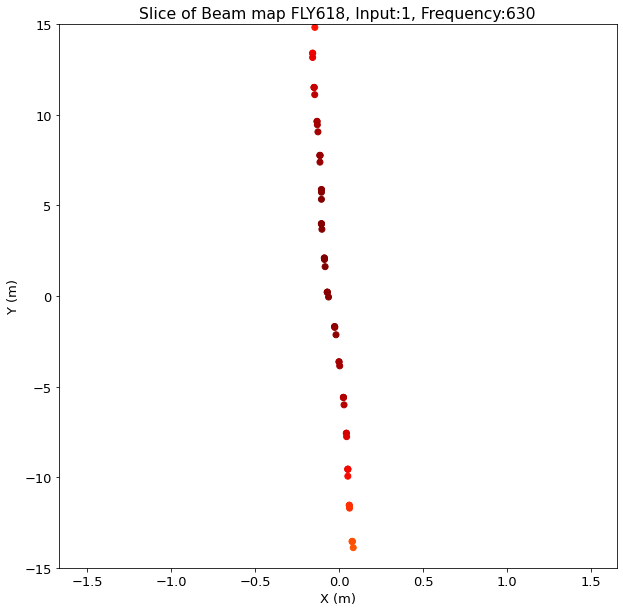

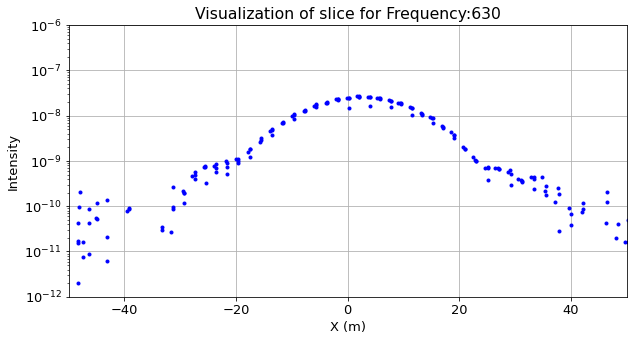

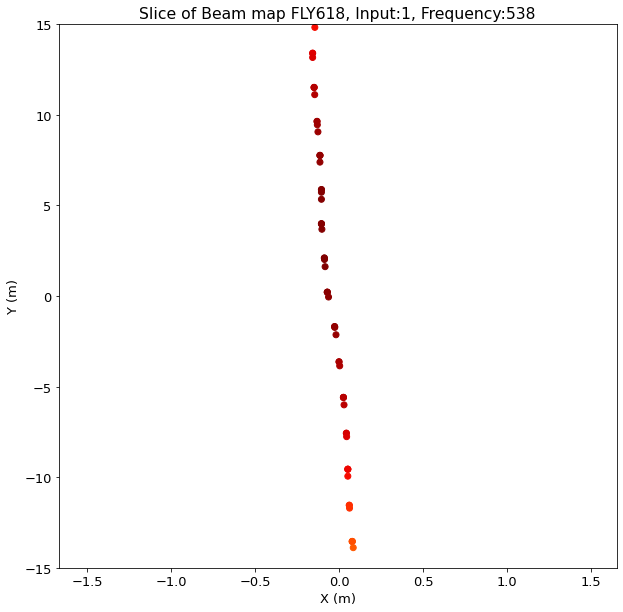

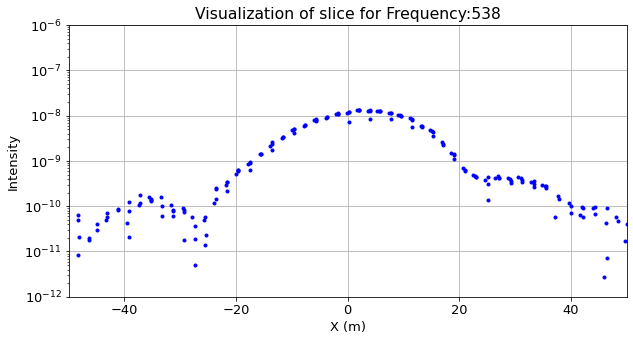

In [87]:
# Flight 618 Input:1

for f in goodfreqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]

    pp = get_slice_xy(x,y,z,0,'x',2)

    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.ylim(-15,15)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))
#     plt.xlim(5.35,5.48)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(y[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title('Visualization of slice for Frequency:' + str(f))
    plt.xlim(-50,50)
    plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

In [88]:
# Reading in file for Flight 619

fly = '619'

pklfile = glob.glob(pckldir+'*'+fly+'*')[0]
print(pklfile)

with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]

for fi in range(0,len(documents["flight_info"]["flights"])):
    if fly == flights[fi]: f = fi
print('FLIGHT: ', documents["flight_info"]["flights"][f])

pol = documents["flight_info"]["pols"][f]

if pol=='N':
    pols = N_pols
    cpols = E_pols
else:
    pols = E_pols
    cpols = N_pols
    
    
print(fly,pol,pols,cpols)

/hirax/GBO_Analysis_Outputs/flight_pickles/FLY619_20211021T185805Z_ver_20230412T222348_concat.pkl
FLIGHT:  619
619 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14]


frequency index:938
frequency:433.59375
input:1


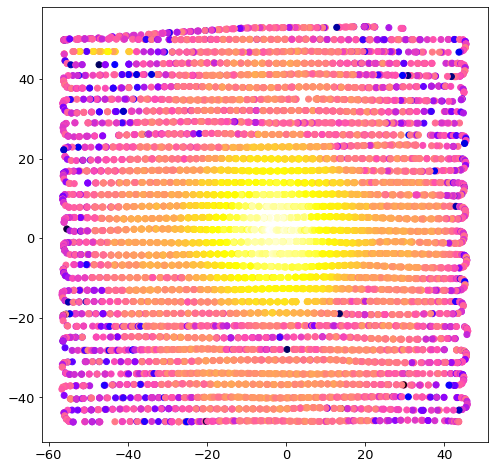

In [89]:
# Flight 619 Input:1

plt.figure(1,figsize=(8,8))

freq = 938
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= pols[0]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

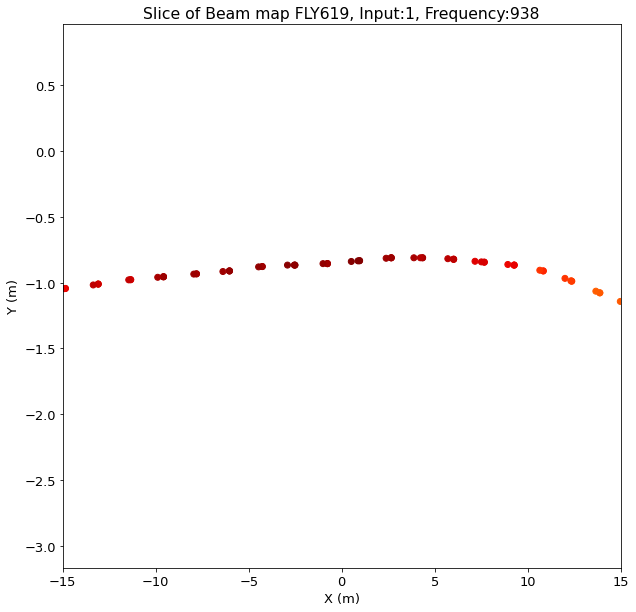

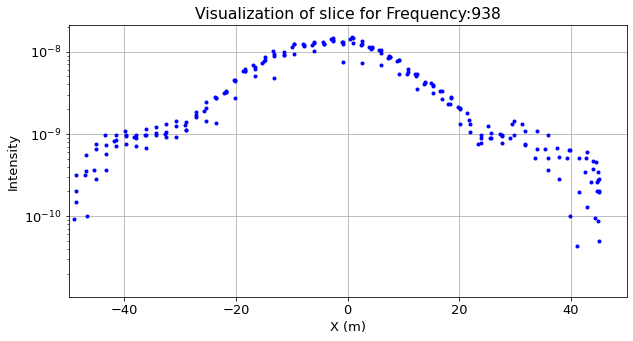

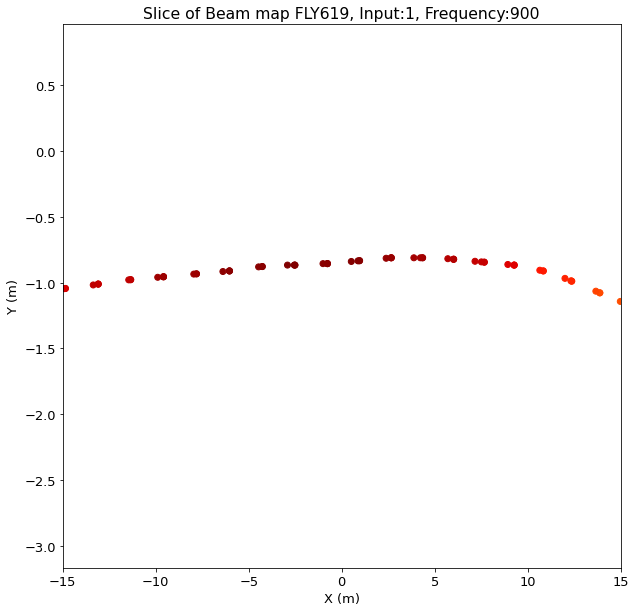

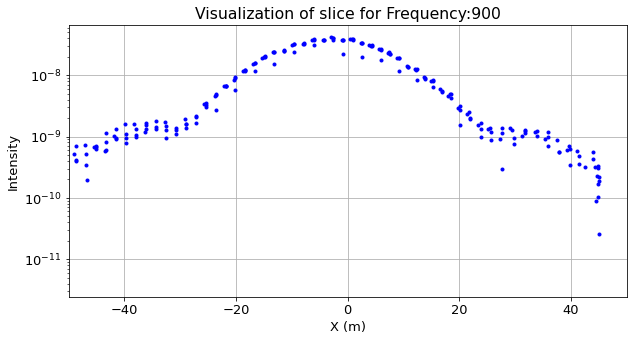

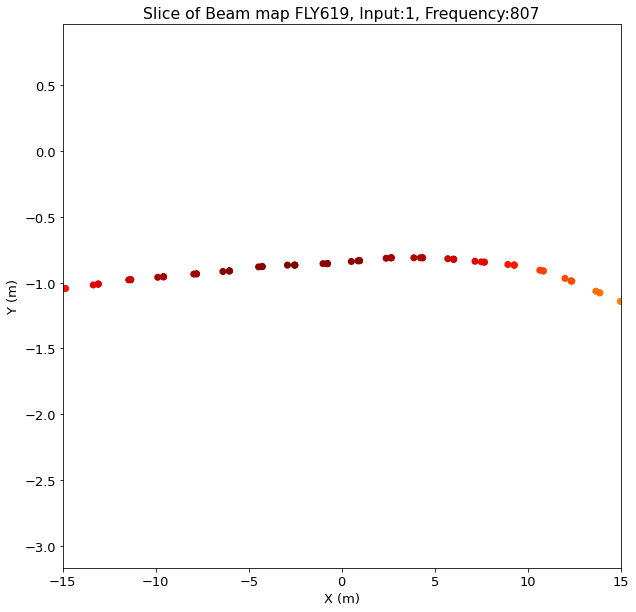

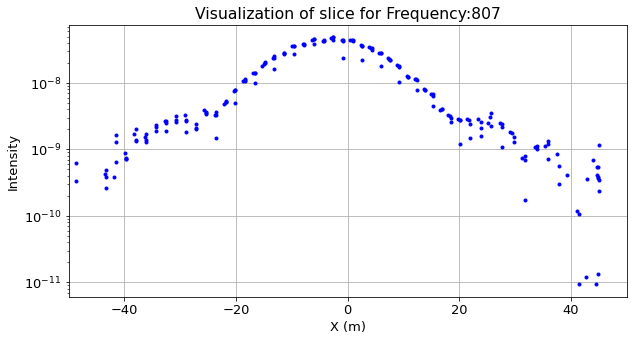

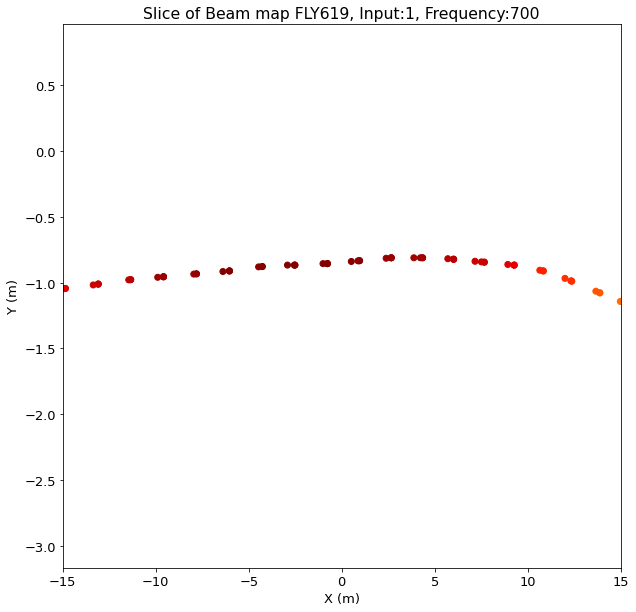

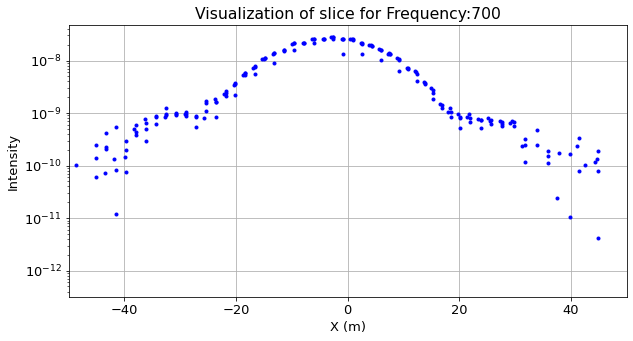

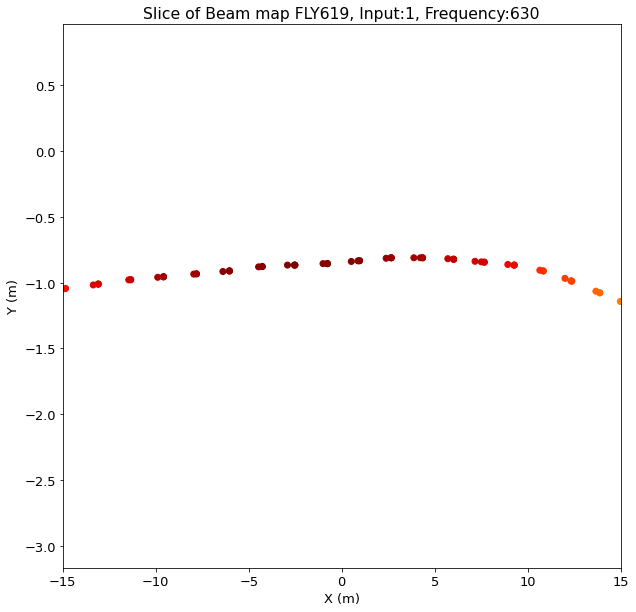

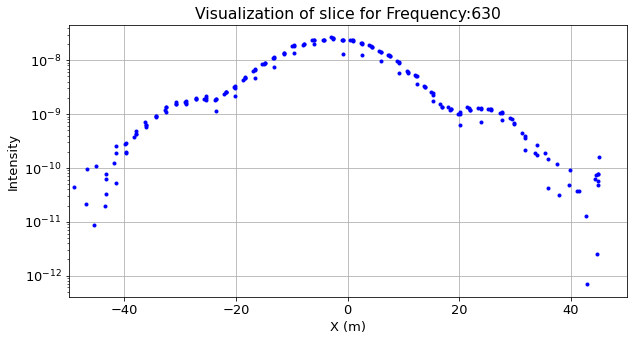

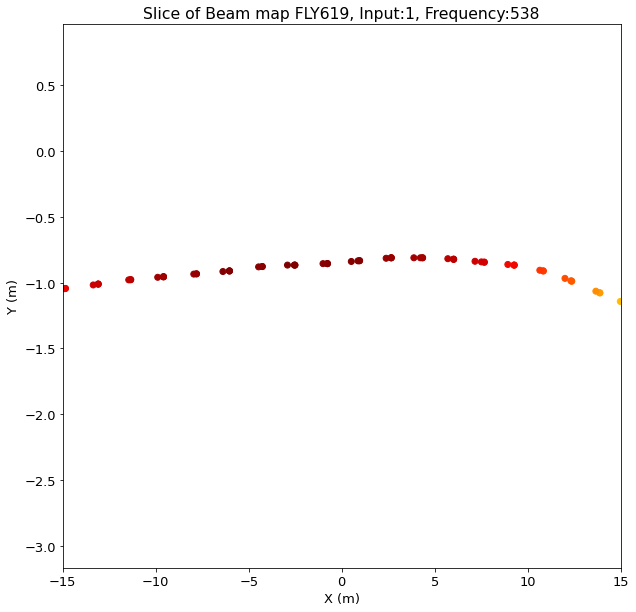

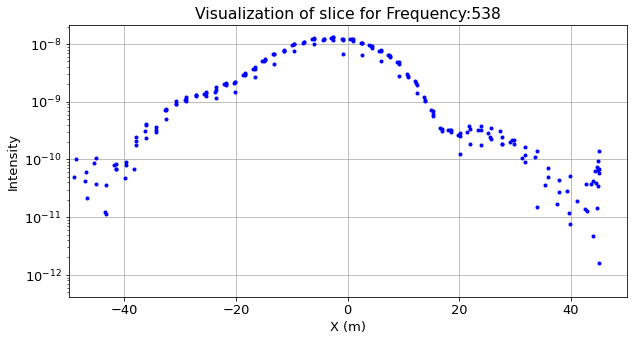

In [91]:
# Flight 619 Input:1


for f in goodfreqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]

    pp = get_slice_xy(x,y,z,-1,'y',2)

    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.xlim(-15,15)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))
#     plt.xlim(5.35,5.48)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(x[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title('Visualization of slice for Frequency:' + str(f))
    plt.xlim(-50,50)
#     plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

1


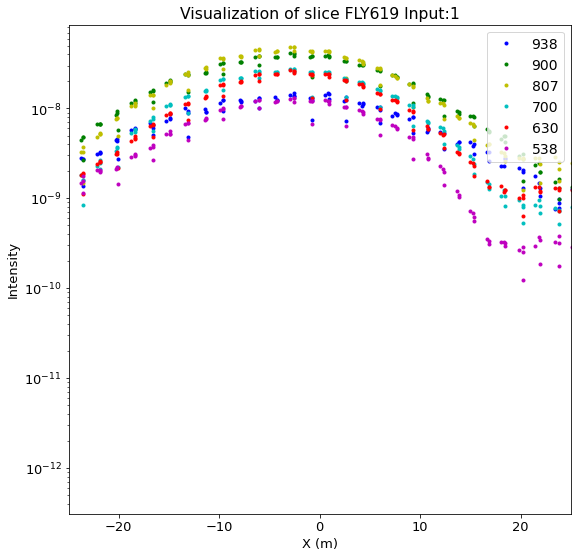

In [98]:
plt.figure(1,figsize=(9,9))
print(dish)


for f, color in zip(goodfreqlist, colors):

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]

    pp = get_slice_xy(x,y,z,-1,'y',2)
    
    plt.semilogy(x[pp], z[pp], color,label=str(f))

# Finding where X values have multiple y values, could be evidence that some on data is making it into the off data 
# These values occur for every frequency so don't have to put this bit in the loop 
    
xmult_y=[]

for x_val in x[pp]:
    if np.count_nonzero(np.isclose(x, x_val, atol=.000001)) > 1:
        xmult_y.append(x_val)

# print(xmult_y)
    
# Creating vertical lines where there are multiple values per x 
    
# for p in xmult_y:
    
#     plt.axvline(p, color='k', linestyle='--',linewidth=1)


plt.legend(prop={'size': 14},loc='upper right')
plt.xlabel('X (m)')
plt.ylabel('Intensity')
plt.title("Visualization of slice FLY619 Input:" +str(dish))
plt.xlim(-25,25)
# plt.ylim(1E-9, 2E-7)
# plt.grid()
plt.show()

frequency index:938
frequency:433.59375
input:3


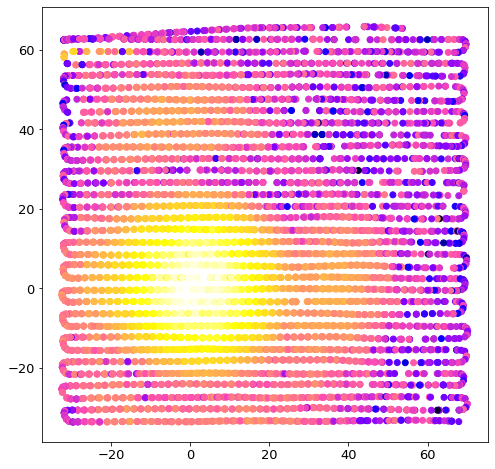

In [99]:
# Flight 619 Input:3

plt.figure(1,figsize=(8,8))

freq = 938
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= pols[1]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

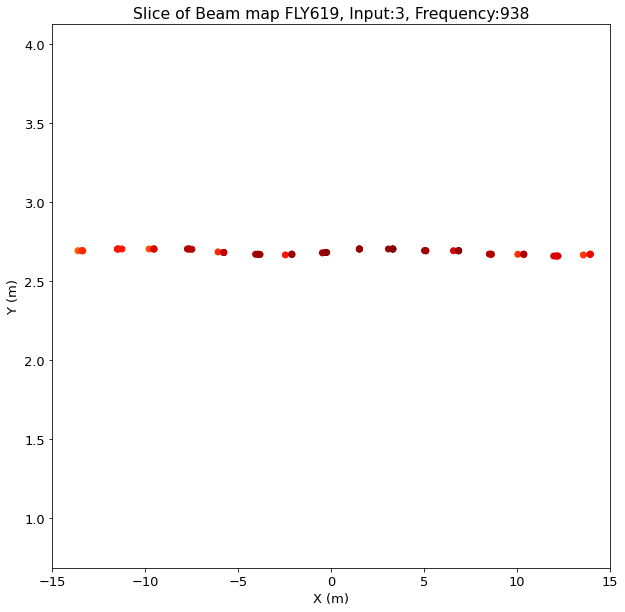

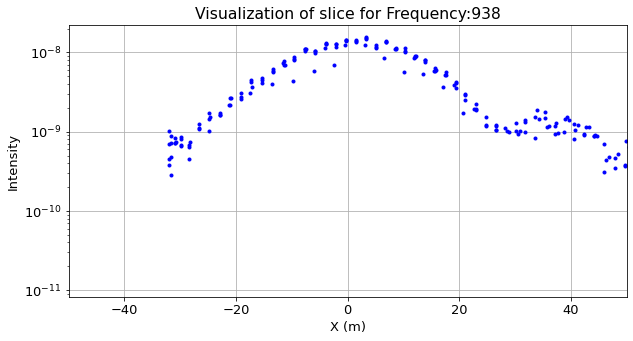

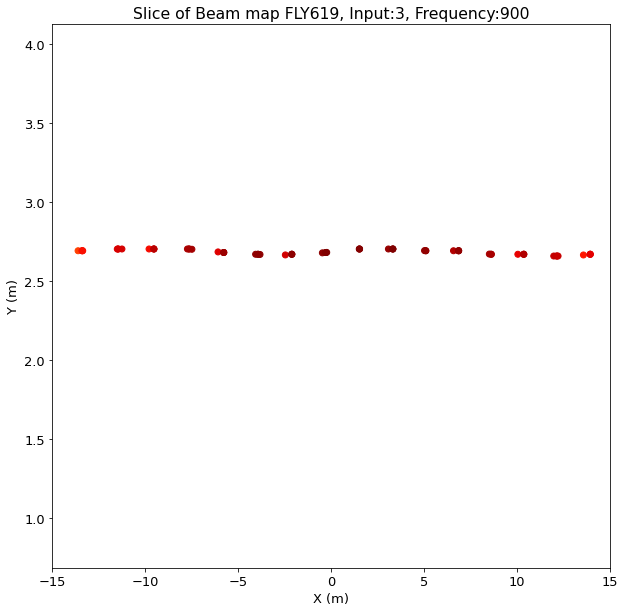

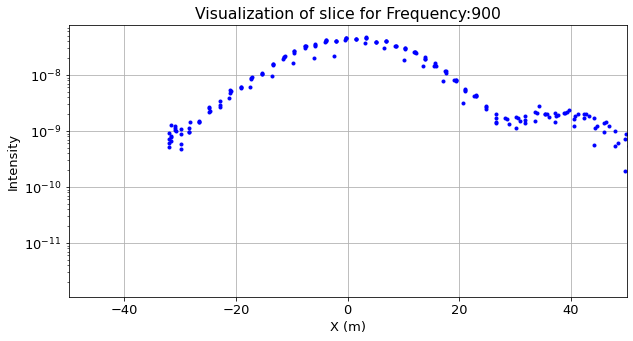

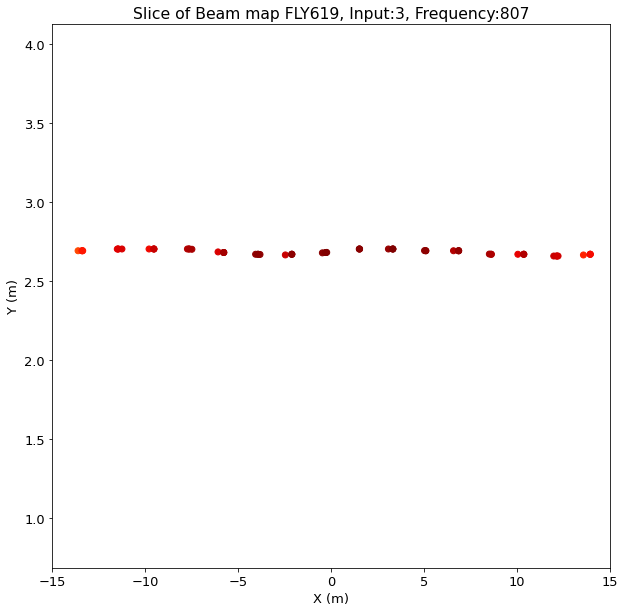

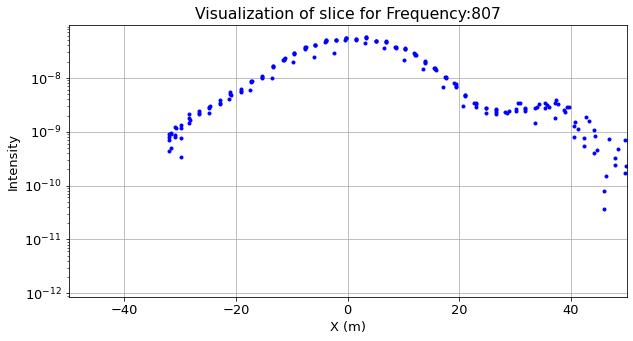

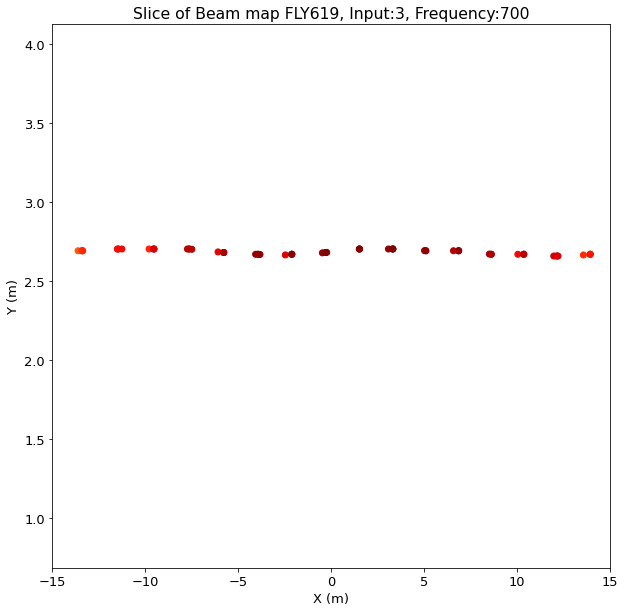

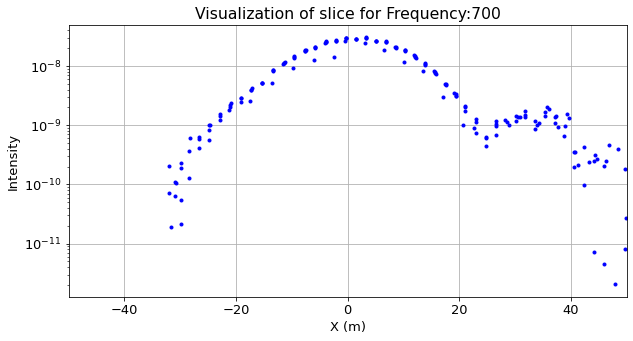

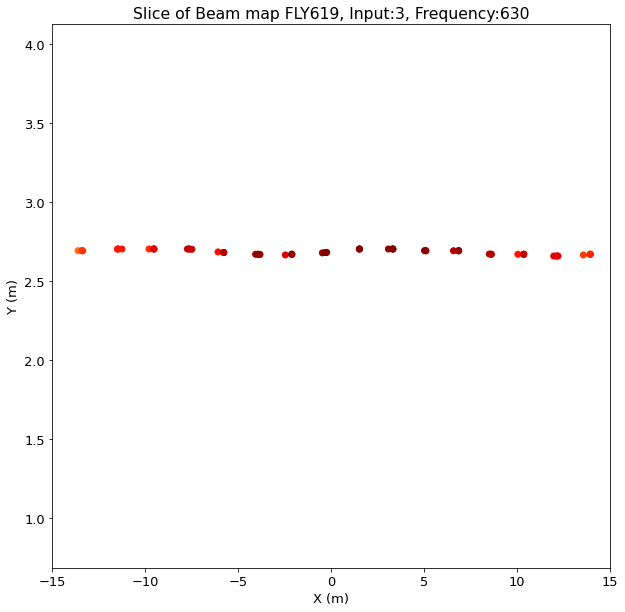

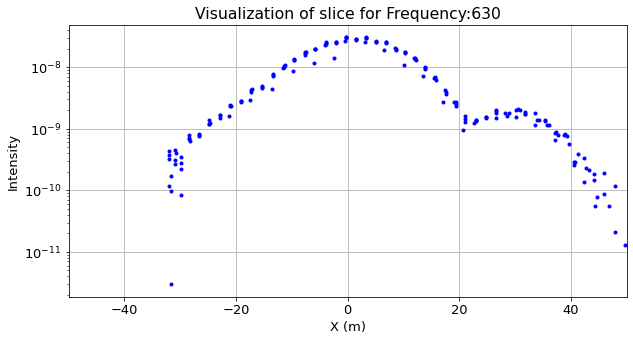

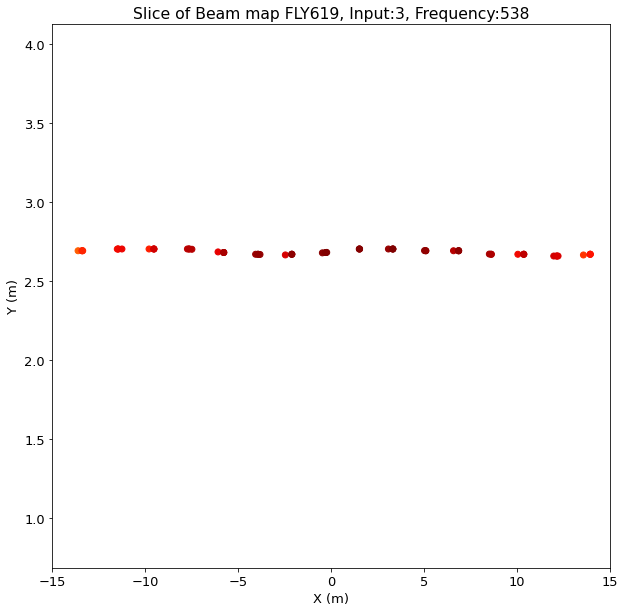

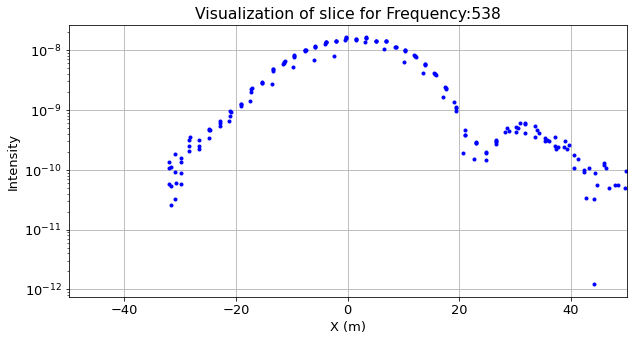

In [101]:
# Flight 619 Input:3


for f in goodfreqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,2.5,'y',2)

    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.xlim(-15,15)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))
#     plt.xlim(5.35,5.48)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(x[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title('Visualization of slice for Frequency:' + str(f))
    plt.xlim(-50,50)
#     plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()

3


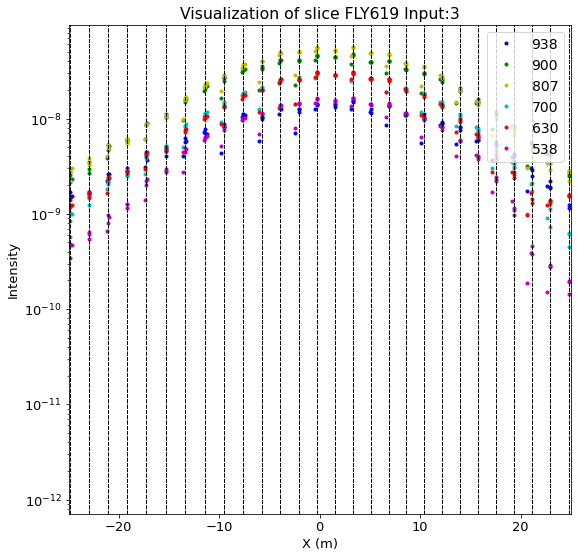

In [103]:
plt.figure(1,figsize=(9,9))
print(dish)

for f, color in zip(goodfreqlist, colors):

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,2.5,'y',2)
    
    plt.semilogy(x[pp], z[pp], color,label=str(f))

# Finding where X values have multiple y values, could be evidence that some on data is making it into the off data 
# These values occur for every frequency so don't have to put this bit in the loop 
    
xmult_y=[]

for x_val in x[pp]:
    if np.count_nonzero(np.isclose(x, x_val, atol=.000001)) > 1:
        xmult_y.append(x_val)

# print(xmult_y)
    
# Creating vertical lines where there are multiple values per x 
    
for p in xmult_y:
    
    plt.axvline(p, color='k', linestyle='--',linewidth=1)

# text_box = "Bad positition approx= "
# plt.text(0.05, 0.05, text_box, transform=plt.gca().transAxes,
#          fontsize=16, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5))

plt.legend(prop={'size': 14},loc='upper right')
plt.xlabel('X (m)')
plt.ylabel('Intensity')
plt.title("Visualization of slice FLY619 Input:" +str(dish))
plt.xlim(-25,25)
# plt.ylim(1E-9, 2E-7)
# plt.grid()
plt.show()

In [104]:
# Reading in file for Flight 625
# Checking bright October flights to make sure these is no fuzz

fly = '625'

pklfile = glob.glob(pckldir+'*'+fly+'*')[0]
print(pklfile)

with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]

for fi in range(0,len(documents["flight_info"]["flights"])):
    if fly == flights[fi]: f = fi
print('FLIGHT: ', documents["flight_info"]["flights"][f])

pol = documents["flight_info"]["pols"][f]

if pol=='N':
    pols = N_pols
    cpols = E_pols
else:
    pols = E_pols
    cpols = N_pols
    
    
print(fly,pol,pols,cpols)

/hirax/GBO_Analysis_Outputs/flight_pickles/FLY625_20211021T214028Z_ver_20230412T232657_concat.pkl
FLIGHT:  625
625 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14]


frequency index:938
frequency:433.59375
input:1


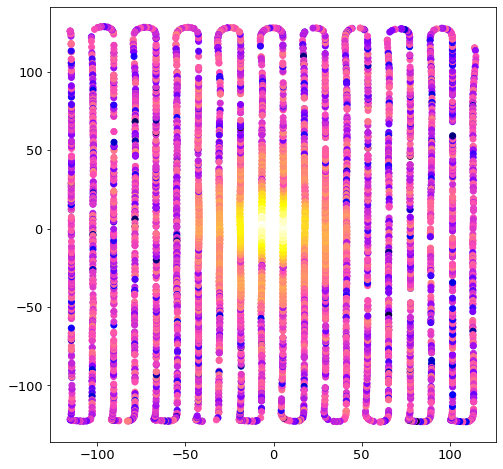

In [105]:
# Flight 625 Input:1

plt.figure(1,figsize=(8,8))

freq = 938
print('frequency index:'+str(freq))
print('frequency:'+str(freqs[freq]))

dish= pols[0]
print('input:'+str(dish))

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
# print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#     print(pfile)
    concattest1=pickle.load(pfile)
    
t_cut=concattest1.inds_on 


# print(concattest1.G_popt[dish,freq,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[dish,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[dish,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,freq,dish],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
z = concattest1.V_bgsub[t_cut,freq,dish]

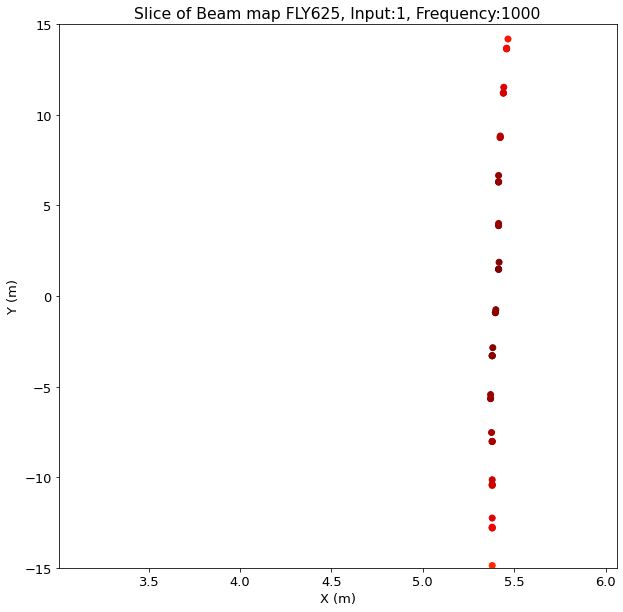

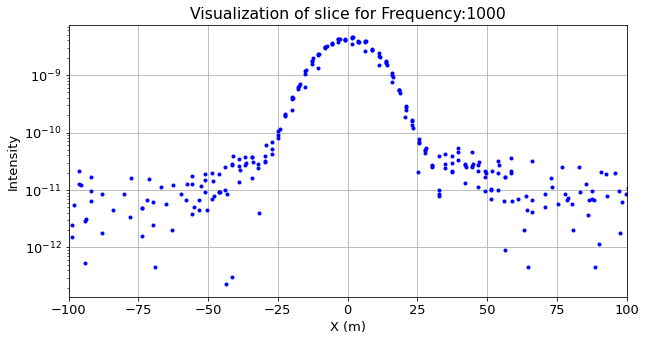

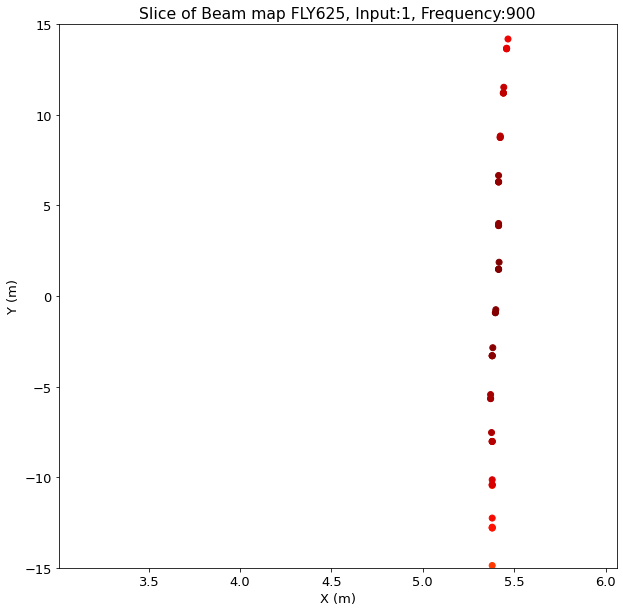

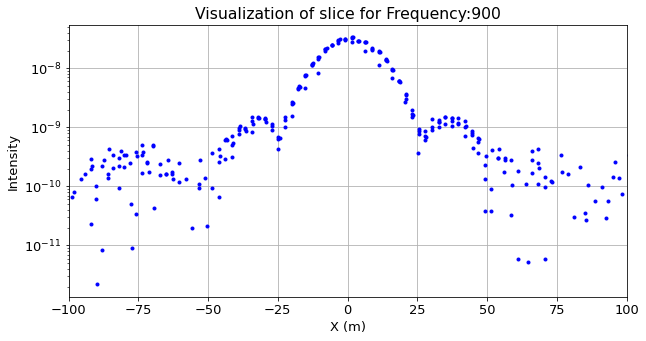

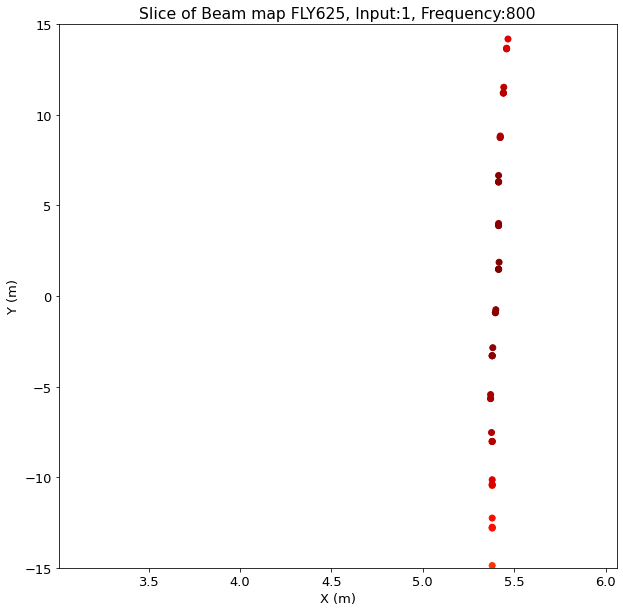

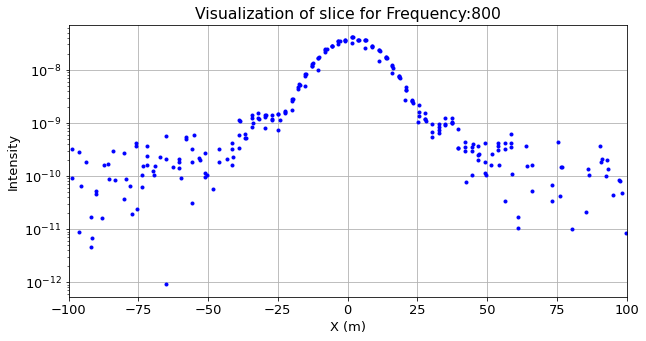

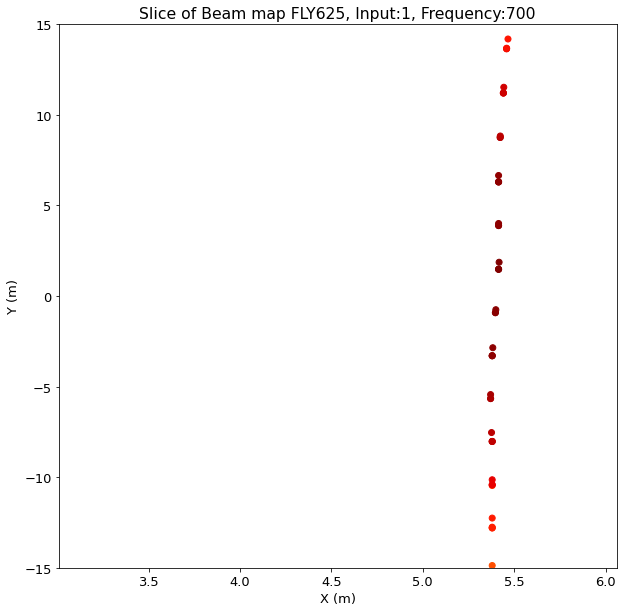

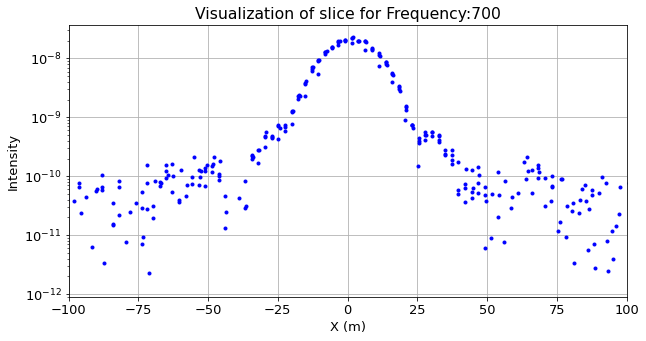

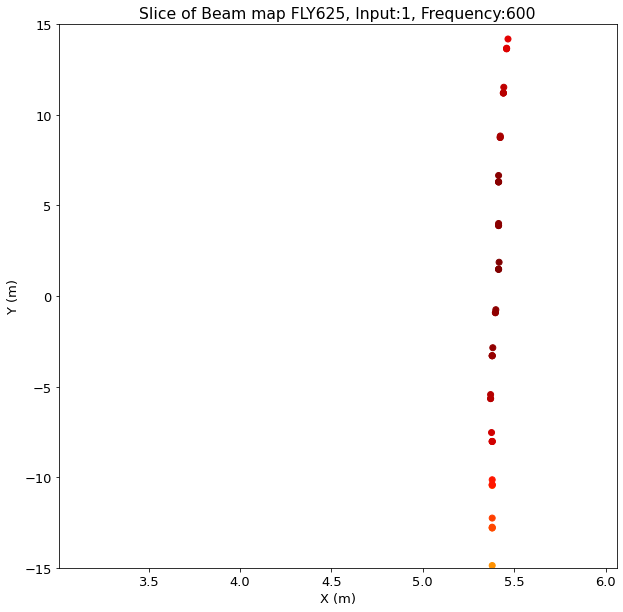

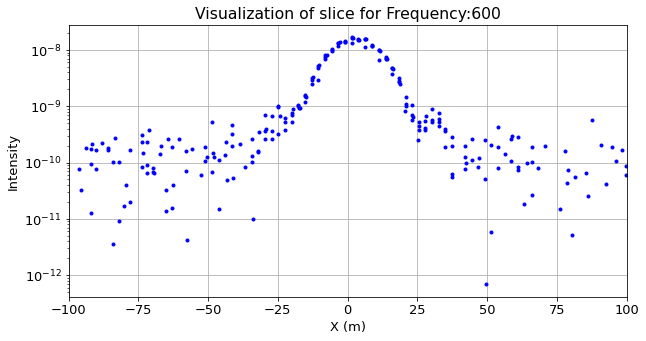

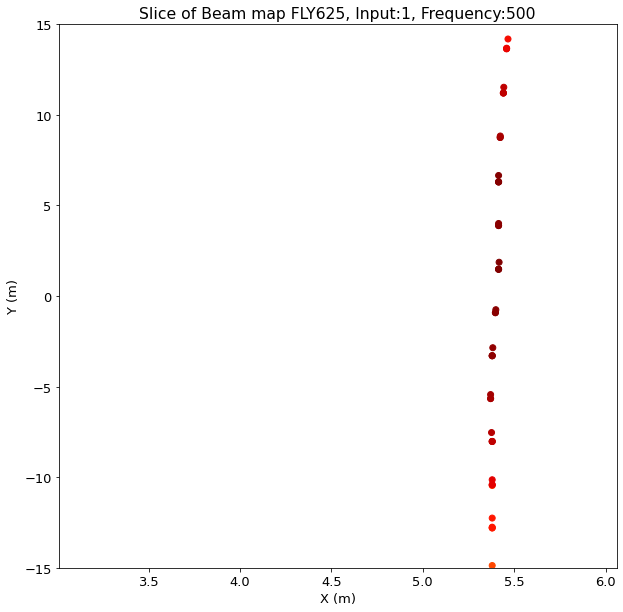

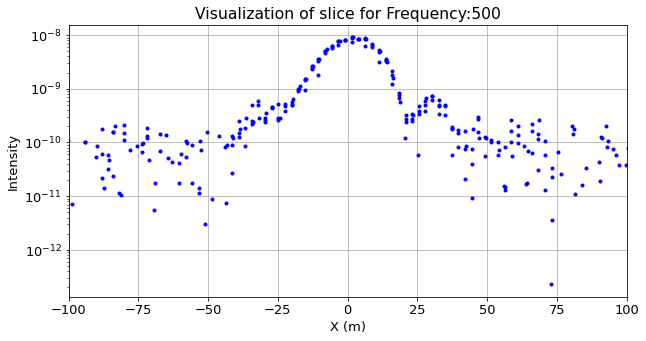

In [106]:
# Flight 625 Input:1


for f in freqlist:

    x = concattest1.drone_xyz_per_dish_interp[dish,t_cut,0]
    y = concattest1.drone_xyz_per_dish_interp[dish,t_cut,1]
    z = concattest1.V_bgsub[t_cut,f,dish]


    pp = get_slice_xy(x,y,z,5,'x',2)

    plt.figure(1,figsize=(10,10))
    plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
    plt.ylim(-15,15)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Slice of Beam map FLY'+str(fly)+', Input:'+str(dish)+', Frequency:'+ str(f))
#     plt.xlim(5.35,5.48)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(y[pp], z[pp], 'b.')
    plt.xlabel('X (m)')
    plt.ylabel('Intensity')
    plt.title('Visualization of slice for Frequency:' + str(f))
    plt.xlim(-100,100)
#     plt.ylim(10E-13,10E-7)
    plt.grid()
    plt.show()